generate hard-coded value function as dictionary

In [1]:
envParams = {
    "discount_factor": 0.2,
    "inventoryCost": [1000, 5, 1000],
    "stockoutCost": 10000
}

In [2]:
import numpy as np

In [3]:
from tqdm import tqdm_notebook

# devise value function

In [4]:
# def getReward(s, stockout=False):
#     inventoryCost = envParams["inventoryCost"][0] * s[0] + envParams["inventoryCost"][1] * s[1] 
#     stockoutCost = envParams["stockoutCost"] if stockout else 0
    
#     return -1 * (inventoryCost + stockoutCost)
# #     return (inventoryCost + stockoutCost)

In [5]:
s0 = np.array([0, 0, 4])

In [6]:
# possible path 1
a1_1 = np.array([20, 20, 0])
s1_1 = np.array([0, 10, 0])
a1_2 = np.array([10, 10, 0])
s1_2 = s1_1 #np.array([0, 10, 0])

In [7]:
# possible path 2
a2_1 = np.array([20, 10, 4])
s2_1 = np.array([10, 0, 4])
a2_2 = np.array([10, 10, 4])
s2_2 = s2_1 #np.array([10, 0, 4])

In [9]:
def getNewState(s, a):
    # new state
    newS = [s[0]+a[0]-a[1], s[1]+a[1]-10, a[2]]
    
    # inventoryCost
    inventoryCost = envParams["inventoryCost"][0] * s[0] + envParams["inventoryCost"][1] * s[1] 
    # stockOut
    if s[1] >= 10:
        stockoutCost = 0 if s[2] >= 0 else envParams["stockoutCost"]
    elif s[0] >= 10:
        stockoutCost = 0 if s[2] >= 4 else envParams["stockoutCost"]*(4-s[2])
    else:
        stockoutCost = 0 if s[2] >= 8 else envParams["stockoutCost"]*(8-s[2])
    
    reward = -1 * (inventoryCost + stockoutCost)
    
    return newS, reward
    
getNewState(s0, a2_1), getNewState(s2_1, a2_2)

(([10, 0, 4], -40000), ([10, 0, 4], -10000))

In [10]:
valuesDict = {}
for s_i in range(5):
    for s_j in tqdm_notebook(range(31)):
        for s_k in range(31):
            # try every state
            state = np.array([s_k, s_j, s_i])
            
            # for every state, find the best action
            bestReward = np.float("-inf")
            for a_i in range(4):
                for a_j in range(31):
                    for a_k in range(31):
                        action = np.array([a_k, a_j, a_i])
                        _, reward = getNewState(state, action)
                        
                        if reward >= bestReward:
                            bestReward = reward
                        
            valuesDict[str(state)] = reward

In [11]:
for s_i in range(5):
    for s_j in tqdm_notebook(range(31)):
        for s_k in range(31):
            # try every state
            state = np.array([s_k, s_j, s_i])
            
            # for every state, find the best action
            bestValue = np.float("-inf")
            rewardForBestValue = np.float("-inf")
            for a_i in range(4):
                for a_j in range(31):
                    for a_k in range(31):
                        action = np.array([a_k, a_j, a_i])
                        nextState, reward = getNewState(state, action)
                        
                        # skip invalid actions
                        if str(np.array(nextState)) not in valuesDict:
                            continue
                            
                        value = valuesDict[str(np.array(nextState))]
                        if value > bestValue:
                            bestValue = value
                            rewardForBestValue = reward
                            
            valuesDict[str(state)] = rewardForBestValue + envParams["discount_factor"] * bestValue 

In [12]:
import json

with open('valuesDict.json', 'w') as fp:
    json.dump(valuesDict, fp)

check if the two local optima a1_1 and a2_1 are very different. Perhaps need to try larger discount_factor

In [13]:
valuesDict[str(s0)], valuesDict[str(s1_1)], valuesDict[str(s2_1)]

(-40012.0, -60.0, -10012.0)

In [14]:
# from s0 to s1_1
a1_1, getNewState(s0, a1_1)[1] + envParams["discount_factor"] * valuesDict[str(s1_1)] - valuesDict[str(s0)]

(array([20, 20,  0]), 0.0)

In [15]:
# from s0 to s2_1: positive td_error means pull to that side
a2_1, getNewState(s0, a2_1)[1] + envParams["discount_factor"] * valuesDict[str(s2_1)] - valuesDict[str(s0)]

(array([20, 10,  4]), -1990.4000000000015)

In [16]:
# # from s0 to s1_1
# s = s0 #np.array([11, 9, 4])
# a = a1_1 #np.array([21, 21, 0]) #np.array([12, 2, 4])
# sNew, r = getNewState(s, a)
# a, sNew, r + envParams["discount_factor"] * valuesDict[str(np.array(sNew))], valuesDict[str(s)]

In [17]:
# # from s0 to s1_1
# s = s0 #np.array([11, 9, 4])
# a = a2_1 #np.array([28, 21, 3]) #np.array([12, 2, 4])
# sNew, r = getNewState(s, a)
# a, sNew, r + envParams["discount_factor"] * valuesDict[str(np.array(sNew))], valuesDict[str(s)]

# visualize value approximator

In [41]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

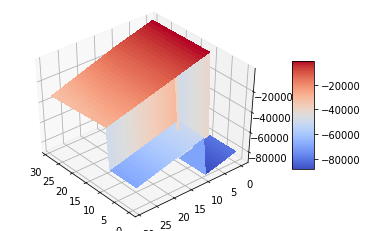

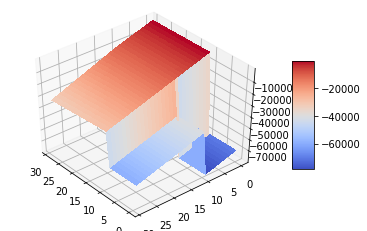

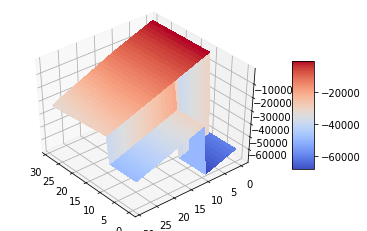

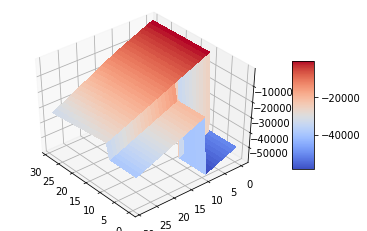

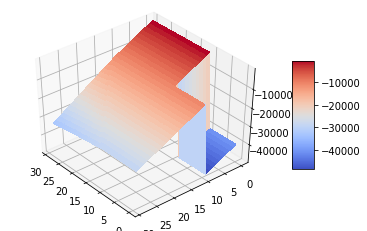

In [50]:
for w in tqdm_notebook(range(5)):
    X = np.arange(0, 30, 1)
    Y = np.arange(0, 30, 1)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros(X.shape)
    
    # inventory node 0
    for i in range(30):
        # inventory node 1
        for j in range(30):
            st = np.array([i, j, w])

            Z[i, j] = valuesDict[str(st)]

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.view_init(40, 140)
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# train policy estimator

In [18]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Model, losses, optimizers
import tensorflow_probability as tfp

In [19]:
def policyEstimator():
    inputs = Input(shape=(4,))
    capacity = Input(shape=(3,))
    retailerOrderQty = Input(shape=(1,))
    prevAction = Input(shape=(3,))
    target = Input(shape=(1,))

    x = inputs
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(80, activation="relu")(x)
    x = layers.Dense(60, activation="relu")(x)
    x = layers.Dense(40, activation="relu")(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dense(40, activation="relu")(x)
    x = layers.Dense(60, activation="relu")(x)
    x = layers.Dense(80, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    mu = layers.Dense(3)(x)
    std = Input(shape=(3,)) #1.0

    normal_dist = tfp.distributions.Normal(loc=mu, scale=std)
    # normal distribution
    # sampling
    def sampling(args):
        return normal_dist.sample(1)

    a = layers.Lambda(sampling, output_shape=(3,))([mu, std])
    # # clipping
    # a = tf.clip_by_value(a, env.action_space.low[0], env.action_space.high[0])

    s0, s1, s2, _ = tf.split(inputs, 4, axis=-1)
    a0, a1, a2 = tf.split(a, 3, axis=-1)
    c0, c1, c2 = tf.split(capacity, 3, axis=-1)

    a2 = tf.clip_by_value(a2, 0, 4) #retailerOrderQty + s2)
    a2 = tf.math.floor(a2)
    a2 = tf.clip_by_value(a2, 0, c2-s2)
    a1 = tf.clip_by_value(a1, retailerOrderQty-s1, c1-s1)
    a1 = tf.math.floor(a1)
    a0 = tf.clip_by_value(a0, a1-s0, c0-s0)
    a0 = tf.math.floor(a0)

    a = tf.concat([a0, a1, a2], axis=-1)
    # consider training in a batch for 1-episode, speed up
    model = Model(inputs=[inputs, std, capacity, retailerOrderQty, prevAction, target], outputs=[mu, a])

    loss = -normal_dist.log_prob(prevAction) * target
    optimizer = "adam"
    model.add_loss(loss)
    model.compile(optimizer=optimizer, experimental_run_tf_function=False)

    return model

In [20]:
_std = np.array([[1, 1, 1]]) * 5
_retailerOrderQty = np.array([10])
_capacity = np.array([[30, 30, 30]])
_action = np.array([[0, 0, 0]])
_target = np.array([0])

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [22]:
model = policyEstimator()

experiment with td_error mapping

/home/eek31/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


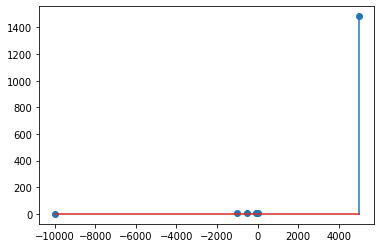

In [53]:
xval = [-10000, -1000, -500, -100, 0, 5000]#, 100]
plt.stem(xval, [10*np.exp((x)/1000) for x in xval])
plt.show()

In [24]:
s = s0

for _ in tqdm_notebook(range(100)):
    for _ in range(100):
        # prepare state
        s_ = np.concatenate((s, [1])) # add bias term
        s_ = np.reshape(s_, (1, 4))

        # get action
        mu, a = model.predict([s_, _std, _capacity, _retailerOrderQty, _action, _target])
        a = a[0]

        # execute action, find new state
        newS, reward = getNewState(s, a[0])
        # integer
        newS = [int(x) for x in newS]

        # check action, skip invalid ones
        if str(np.array(newS)) not in valuesDict:
            continue

        # from s0 to s2_1: positive td_error means pull to that side
        td_target = reward + envParams["discount_factor"] * valuesDict[str(np.array(newS))]    
        td_error = td_target - valuesDict[str(np.array(s))]

        # make all rewards positive and change task to maximize reward
        # if reward positive and action differ, then minimise the difference between action and mu
        # make mu closer to that action
        td_error = 10*np.exp(td_error/1000)
#         td_error = 10*np.exp((2*td_error)/1000) # need to find the right mapping to make sure learning happens if gap is small
    

        # train
        model.fit([s_, _std, _capacity, _retailerOrderQty, a, np.array([td_error])], epochs=1, verbose=0)

        newMu = model.predict([s_, _std, _capacity, _retailerOrderQty, _action, _target])[0]
        print("")
        print("s: {}, mu: {}, a: {}, td_target: {}, currentValue: {}, exp_td_error: {}, newMu: {}".format(s, mu, a, td_target, valuesDict[str(np.array(s))], td_error, newMu))
        print("")

        s = newS



s: [0 0 4], mu: [[ 0.03480391 -0.01163984  0.02261711]], a: [[10. 10.  0.]], td_target: -56002.0, currentValue: -40012.0, exp_td_error: 1.1366617202803369e-06, newMu: [[ 0.03517561 -0.01115022  0.02255383]]


s: [0, 0, 0], mu: [[0.0066758  0.00521427 0.00112369]], a: [[10. 10.  0.]], td_target: -96002.0, currentValue: -80010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[0.00706537 0.00567334 0.00105711]]


s: [0, 0, 0], mu: [[0.00706537 0.00567334 0.00105711]], a: [[10. 10.  0.]], td_target: -96002.0, currentValue: -80010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[0.00754991 0.00624347 0.00097218]]


s: [0, 0, 0], mu: [[0.00754991 0.00624347 0.00097218]], a: [[10. 10.  2.]], td_target: -92002.0, currentValue: -80010.0, exp_td_error: 6.193563192306549e-05, newMu: [[0.01070738 0.00991344 0.00137651]]


s: [0, 0, 2], mu: [[ 0.02253415 -0.00232088  0.01346286]], a: [[10. 10.  4.]], td_target: -68002.4, currentValue: -60010.0, exp_td_error: 0.0033802185662531034, newMu: [[0.0351


s: [0, 0, 4], mu: [[4.0255322 3.7775505 1.2967738]], a: [[10. 10.  4.]], td_target: -48002.4, currentValue: -40012.0, exp_td_error: 0.0033869857683319327, newMu: [[4.2006726 3.9523075 1.3537842]]


s: [0, 0, 4], mu: [[4.2006726 3.9523075 1.3537842]], a: [[10. 10.  3.]], td_target: -50002.0, currentValue: -40012.0, exp_td_error: 0.00045856206642207306, newMu: [[4.3679295 4.118578  1.4068518]]


s: [0, 0, 3], mu: [[3.4712372 3.282145  1.1199398]], a: [[10. 10.  0.]], td_target: -66002.0, currentValue: -50010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[3.5966487 3.401595  1.1599633]]


s: [0, 0, 0], mu: [[1.4754771  1.4046283  0.48262775]], a: [[10. 10.  2.]], td_target: -92002.0, currentValue: -80010.0, exp_td_error: 6.193563192306549e-05, newMu: [[1.5069327 1.4342663 0.4926713]]


s: [0, 0, 2], mu: [[2.744181   2.598608   0.88669807]], a: [[20. 10.  2.]], td_target: -66002.0, currentValue: -60010.0, exp_td_error: 0.024986617260932466, newMu: [[2.8567395 2.7042263 0.9231942]]


s:


s: [0, 1, 3], mu: [[7.3845067 6.8937826 2.2504911]], a: [[9. 9. 0.]], td_target: -66007.0, currentValue: -50015.0, exp_td_error: 1.1343906686484246e-06, newMu: [[7.433255  6.9384685 2.2655249]]


s: [0, 0, 0], mu: [[3.071201  2.8554683 0.9430797]], a: [[10. 10.  0.]], td_target: -96002.0, currentValue: -80010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[3.0926678 2.874855  0.9497101]]


s: [0, 0, 0], mu: [[3.0926678 2.874855  0.9497101]], a: [[10. 10.  1.]], td_target: -94002.0, currentValue: -80010.0, exp_td_error: 8.382076288746659e-06, newMu: [[3.112313   2.8925993  0.95577884]]


s: [0, 0, 1], mu: [[4.106935  3.822728  1.2558837]], a: [[10. 10.  0.]], td_target: -86002.0, currentValue: -70010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[4.1323214 3.84575   1.2635943]]


s: [0, 0, 0], mu: [[3.130227   2.9087799  0.96131253]], a: [[10. 10.  3.]], td_target: -90002.0, currentValue: -80010.0, exp_td_error: 0.00045764585880225095, newMu: [[3.1494708  2.9261696  0.96725154]]




s: [24, 15, 4], mu: [[10.314344  9.793769  1.632833]], a: [[6. 1. 3.]], td_target: -31886.0, currentValue: -24107.8, exp_td_error: 0.004187652741115261, newMu: [[7.737917  7.3614125 1.1930574]]


s: [29, 6, 3], mu: [[21.437757  20.525002   3.3321366]], a: [[ 1. 14.  0.]], td_target: -42243.2, currentValue: -39055.0, exp_td_error: 0.41246047045226175, newMu: [[15.540436  15.074592   2.4256868]]


s: [16, 10, 0], mu: [[1.793176   1.6888279  0.26707163]], a: [[-1.  3.  0.]], td_target: -26455.0, currentValue: -16066.0, exp_td_error: 0.00030769088256263257, newMu: [[1.076853   0.99715114 0.19670516]]


s: [12, 3, 0], mu: [[3.4812484 3.4101944 0.5463064]], a: [[-2.  7.  2.]], td_target: -64617.0, currentValue: -52025.0, exp_td_error: 3.3990995488215e-05, newMu: [[2.2578652  2.221001   0.34589067]]


s: [3, 0, 2], mu: [[12.657283  12.445349   1.8575608]], a: [[11. 14.  4.]], td_target: -71006.4, currentValue: -63010.0, exp_td_error: 0.003366724697716984, newMu: [[11.951579  11.852181   1.74


s: [0, 0, 1], mu: [[ 1.7604374   2.2076125  -0.24542132]], a: [[10. 10.  0.]], td_target: -86002.0, currentValue: -70010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[ 1.7467983   2.227446   -0.23613228]]


s: [0, 0, 0], mu: [[ 1.1896868  1.5263883 -0.164799 ]], a: [[10. 10.  4.]], td_target: -88002.4, currentValue: -80010.0, exp_td_error: 0.0033802185662531034, newMu: [[ 1.1853117   1.5567764  -0.15605703]]


s: [0, 0, 4], mu: [[ 4.022488   5.200969  -0.5028882]], a: [[10. 10.  1.]], td_target: -54002.0, currentValue: -40012.0, exp_td_error: 8.398857216658428e-06, newMu: [[ 3.9907005   5.2704597  -0.47163028]]


s: [0, 0, 1], mu: [[ 1.725141    2.3000596  -0.20976768]], a: [[10. 10.  0.]], td_target: -86002.0, currentValue: -70010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[ 1.717022    2.3329027  -0.19772466]]


s: [0, 0, 0], mu: [[ 1.1793563   1.6119317  -0.13980412]], a: [[10. 10.  3.]], td_target: -90002.0, currentValue: -80010.0, exp_td_error: 0.00045764585880225095, n


s: [0, 0, 2], mu: [[3.0011322 6.6026626 1.0888071]], a: [[12. 10.  0.]], td_target: -76402.0, currentValue: -60010.0, exp_td_error: 7.604048052308127e-07, newMu: [[3.0438163 6.76111   1.1580927]]


s: [2, 0, 0], mu: [[0.09318727 0.25396785 0.05625828]], a: [[ 8. 10.  0.]], td_target: -98002.0, currentValue: -82010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[0.09752592 0.26335806 0.05920618]]


s: [0, 0, 0], mu: [[1.6884129 3.7888794 0.6707256]], a: [[10. 10.  0.]], td_target: -96002.0, currentValue: -80010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[1.7126786 3.8712559 0.7050484]]


s: [0, 0, 0], mu: [[1.7126786 3.8712559 0.7050484]], a: [[16. 16.  4.]], td_target: -88008.4, currentValue: -80010.0, exp_td_error: 0.003359997977284224, newMu: [[1.7521399  4.007666   0.75459343]]


s: [0, 6, 4], mu: [[2.5072992 5.8205442 1.1223907]], a: [[5. 5. 1.]], td_target: -54033.0, currentValue: -40042.0, exp_td_error: 8.390462557470922e-06, newMu: [[2.5527399 5.9772286 1.1829844]]


s:


s: [0, 0, 0], mu: [[2.393411   1.2777742  0.26028025]], a: [[10. 10.  3.]], td_target: -90002.0, currentValue: -80010.0, exp_td_error: 0.00045764585880225095, newMu: [[2.3788443 1.2703427 0.2607424]]


s: [0, 0, 3], mu: [[5.4481463  2.9580305  0.61430573]], a: [[10. 10.  4.]], td_target: -58002.4, currentValue: -50010.0, exp_td_error: 0.003380218566253079, newMu: [[5.4196362 2.954434  0.6168108]]


s: [0, 0, 4], mu: [[6.59204    3.5991652  0.75307256]], a: [[10. 10.  3.]], td_target: -50002.0, currentValue: -40012.0, exp_td_error: 0.00045856206642207306, newMu: [[6.556954   3.5959213  0.75566465]]


s: [0, 0, 3], mu: [[5.3949094 2.9538927 0.6194232]], a: [[10. 10.  1.]], td_target: -64002.0, currentValue: -50010.0, exp_td_error: 8.382076288746659e-06, newMu: [[5.372891  2.9536934 0.6218668]]


s: [0, 0, 1], mu: [[3.158879   1.719795   0.35978964]], a: [[10. 10.  0.]], td_target: -86002.0, currentValue: -70010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[3.1485105 1.7202352 0.3612


s: [0, 0, 0], mu: [[2.6631944  1.7869922  0.40775898]], a: [[10. 10.  1.]], td_target: -94002.0, currentValue: -80010.0, exp_td_error: 8.382076288746659e-06, newMu: [[2.6812851 1.8081828 0.4134834]]


s: [0, 0, 1], mu: [[3.5342567  2.403357   0.54989356]], a: [[10. 10.  0.]], td_target: -86002.0, currentValue: -70010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[3.5548055  2.4282234  0.55670136]]


s: [0, 0, 0], mu: [[2.6978936 1.8276154 0.4187644]], a: [[10. 10.  2.]], td_target: -92002.0, currentValue: -80010.0, exp_td_error: 6.193563192306549e-05, newMu: [[2.71328    1.8456002  0.42365992]]


s: [0, 0, 2], mu: [[4.707045   3.2513928  0.74655586]], a: [[10. 10.  4.]], td_target: -68002.4, currentValue: -60010.0, exp_td_error: 0.0033802185662531034, newMu: [[4.7438297 3.2984602 0.7592843]]


s: [0, 0, 4], mu: [[7.1173077 4.9804616 1.1472957]], a: [[11. 11.  0.]], td_target: -56003.0, currentValue: -40012.0, exp_td_error: 1.1355256267015211e-06, newMu: [[7.1658206 5.044044  1.1647


s: [0, 0, 3], mu: [[10.584504  10.880917   3.1746302]], a: [[13. 13.  4.]], td_target: -58005.4, currentValue: -50010.0, exp_td_error: 0.0033700931063382856, newMu: [[10.886689  11.27675    3.3127646]]


s: [0, 3, 4], mu: [[9.504504  9.836639  2.8908637]], a: [[21. 21.  3.]], td_target: -40031.4, currentValue: -40027.0, exp_td_error: 9.956096658182686, newMu: [[10.245832  10.7541065  3.158604 ]]


s: [0, 14, 3], mu: [[5.138119  5.0653653 1.5015987]], a: [[ 4. -4.  0.]], td_target: -17672.0, currentValue: -82.0, exp_td_error: 2.2948804346241508e-07, newMu: [[5.4793634 5.488606  1.6239309]]


s: [8, 0, 0], mu: [[3.099116  3.1069894 0.9176971]], a: [[ 3. 10.  0.]], td_target: -104202.0, currentValue: -88010.0, exp_td_error: 9.287605264271606e-07, newMu: [[3.314391   3.3699093  0.99557424]]


s: [1, 0, 0], mu: [[4.4721785 4.7366877 1.3817142]], a: [[ 9. 10.  1.]], td_target: -95002.0, currentValue: -81010.0, exp_td_error: 8.382076288746659e-06, newMu: [[4.6923985 5.020373  1.4649212]]


s


s: [0, 20, 0], mu: [[9.6905985 9.01761   1.3993567]], a: [[13. 10.  4.]], td_target: -723.0, currentValue: -110.0, exp_td_error: 5.41723259102941, newMu: [[10.019416   9.370912   1.3706689]]


s: [3, 20, 4], mu: [[9.247352 8.654193 1.262039]], a: [[16.  3.  3.]], td_target: -6316.8, currentValue: -3115.0, exp_td_error: 0.40688898006372565, newMu: [[9.532902  8.942655  1.2355245]]


s: [16, 13, 3], mu: [[6.0580726 5.8793426 0.7815195]], a: [[ 6. -2.  0.]], td_target: -28869.0, currentValue: -16084.0, exp_td_error: 2.802496306307703e-05, newMu: [[6.180076   6.0057425  0.75970733]]


s: [24, 1, 0], mu: [[23.312944  22.442717   2.7338593]], a: [[ 6. 27.  4.]], td_target: -64625.6, currentValue: -64020.0, exp_td_error: 5.457468802574674, newMu: [[19.484074 19.44796   2.287024]]


s: [3, 18, 4], mu: [[8.680246  8.477056  1.0726341]], a: [[ 7. 10.  4.]], td_target: -3110.4, currentValue: -3103.0, exp_td_error: 9.92627312587426, newMu: [[8.459795  8.629068  1.1246182]]


s: [0, 18, 4], mu: [[


s: [2, 20, 4], mu: [[10.510603  10.855446   0.8137917]], a: [[9. 5. 4.]], td_target: -3317.6000000000004, currentValue: -2114.0, exp_td_error: 3.001118621478314, newMu: [[9.622949  9.700198  0.6203971]]


s: [6, 15, 4], mu: [[5.2123814 5.7374997 0.6181308]], a: [[0. 2. 2.]], td_target: -18884.0, currentValue: -6088.0, exp_td_error: 2.7718377779836403e-05, newMu: [[4.6171665 4.988554  0.5057903]]


s: [4, 7, 2], mu: [[2.5837936  2.7723002  0.23983182]], a: [[5. 3. 0.]], td_target: -81237.0, currentValue: -64045.0, exp_td_error: 3.4167190344411847e-07, newMu: [[2.3753164  2.4981494  0.19374977]]


s: [6, 0, 0], mu: [[3.5122986  3.3648942  0.00912797]], a: [[ 4. 10.  1.]], td_target: -100002.0, currentValue: -86010.0, exp_td_error: 8.382076288746659e-06, newMu: [[ 3.4544919   3.2817895  -0.00516291]]


s: [0, 0, 1], mu: [[14.917222   14.42763    -0.34061164]], a: [[23. 23.  1.]], td_target: -70015.0, currentValue: -70010.0, exp_td_error: 9.950124791926823, newMu: [[15.455397   14.9872875


s: [14, 0, 0], mu: [[3.095931  2.8764696 0.390061 ]], a: [[-1. 10.  4.]], td_target: -62602.4, currentValue: -54010.0, exp_td_error: 0.0018551032817007572, newMu: [[2.9561582  2.7172108  0.36299613]]


s: [3, 0, 4], mu: [[16.280243  15.242178   1.0144149]], a: [[18. 21.  0.]], td_target: -43013.0, currentValue: -43012.0, exp_td_error: 9.99000499833375, newMu: [[15.874515   14.861847    0.84376657]]


s: [0, 11, 0], mu: [[2.1404777  1.9812701  0.37339136]], a: [[2. 2. 1.]], td_target: -14060.0, currentValue: -65.0, exp_td_error: 8.356967741532662e-06, newMu: [[2.0678048  1.9205797  0.35164943]]


s: [0, 3, 1], mu: [[5.223505  4.8787265 0.2688821]], a: [[7. 7. 1.]], td_target: -84017.0, currentValue: -70025.0, exp_td_error: 8.382076288746659e-06, newMu: [[5.053141   4.7202406  0.22428112]]


s: [0, 0, 1], mu: [[11.751783   11.032562    0.45944607]], a: [[10. 10.  4.]], td_target: -78002.4, currentValue: -70010.0, exp_td_error: 0.0033802185662531034, newMu: [[11.47267   10.771107   0.370


s: [0, 3, 4], mu: [[17.480246   18.22744     0.40618882]], a: [[18. 11.  0.]], td_target: -57421.0, currentValue: -40027.0, exp_td_error: 2.7917837932455935e-07, newMu: [[17.420197   18.311462    0.26002333]]


s: [7, 4, 0], mu: [[1.554681   1.7046853  0.22989097]], a: [[-1.  6.  0.]], td_target: -103022.0, currentValue: -87030.0, exp_td_error: 1.1343906686484246e-06, newMu: [[1.5523858  1.7141778  0.21749823]]


s: [0, 0, 0], mu: [[12.005635   12.743207    0.12680528]], a: [[22. 18.  0.]], td_target: -96810.0, currentValue: -80010.0, exp_td_error: 5.05653134833552e-07, newMu: [[11.97274    12.791384    0.04512109]]


s: [4, 8, 0], mu: [[1.3739978 1.6596508 0.2557075]], a: [[3. 7. 0.]], td_target: -100047.0, currentValue: -84050.0, exp_td_error: 1.1287328715849146e-06, newMu: [[1.370305   1.6645447  0.24681257]]


s: [0, 5, 0], mu: [[2.087537   2.2391965  0.19695853]], a: [[5. 5. 0.]], td_target: -96027.0, currentValue: -80035.0, exp_td_error: 1.1343906686484246e-06, newMu: [[2.083558


s: [0, 14, 1], mu: [[4.737052  6.2867393 0.655149 ]], a: [[8. 7. 0.]], td_target: -283.0, currentValue: -80.0, exp_td_error: 8.1627824142561, newMu: [[4.9317274 6.480577  0.6783164]]


s: [1, 11, 0], mu: [[3.2085667  4.2817006  0.53352773]], a: [[ 9. 10.  0.]], td_target: -1068.0, currentValue: -1065.0, exp_td_error: 9.97004495503373, newMu: [[3.4389393  4.5466256  0.55350393]]


s: [0, 11, 0], mu: [[4.223798  5.550577  0.6035409]], a: [[10. 10.  0.]], td_target: -68.0, currentValue: -65.0, exp_td_error: 9.97004495503373, newMu: [[4.5751386 5.9620366 0.6397763]]


s: [0, 11, 0], mu: [[4.5751386 5.9620366 0.6397763]], a: [[9. 9. 1.]], td_target: -67.0, currentValue: -65.0, exp_td_error: 9.98001998667333, newMu: [[5.003567  6.4688954 0.6886375]]


s: [0, 10, 1], mu: [[5.286319  6.8289437 0.6810926]], a: [[9. 8. 4.]], td_target: -8260.4, currentValue: -60.0, exp_td_error: 0.0027454373051350968, newMu: [[5.6862764  7.299016   0.72701865]]


s: [1, 8, 4], mu: [[11.297479   14.83513     0.8


s: [0, 17, 2], mu: [[10.532756   9.82148    1.8150163]], a: [[9. 9. 4.]], td_target: -103.4, currentValue: -95.0, exp_td_error: 9.916351814230984, newMu: [[10.292291   9.639549   1.8040135]]


s: [0, 16, 4], mu: [[16.35102  15.968045  2.550206]], a: [[17. 12.  0.]], td_target: -1100.6, currentValue: -92.0, exp_td_error: 3.647292432441512, newMu: [[15.574636  15.207619   2.3993871]]


s: [5, 18, 0], mu: [[6.1627965 5.909129  1.3736658]], a: [[ 5. 10.  0.]], td_target: -5110.0, currentValue: -5103.0, exp_td_error: 9.930244429332351, newMu: [[6.1885004 5.9873486 1.3707043]]


s: [0, 18, 0], mu: [[9.149463  8.67585   1.8029679]], a: [[6. 6. 4.]], td_target: -106.4, currentValue: -100.0, exp_td_error: 9.93620436379149, newMu: [[9.012286  8.609671  1.7973065]]


s: [0, 14, 4], mu: [[15.642745 15.526343  2.330081]], a: [[11. 11.  1.]], td_target: -87.0, currentValue: -82.0, exp_td_error: 9.950124791926823, newMu: [[13.736905 13.605153  2.031214]]


s: [0, 15, 1], mu: [[7.9314938 7.639381  1.


s: [21, 0, 4], mu: [[10.927294 10.669767  0.996608]], a: [[ 9. 10.  1.]], td_target: -31002.0, currentValue: -21013.0, exp_td_error: 0.00045902085784597425, newMu: [[10.970912  10.705448   0.9956725]]


s: [20, 0, 1], mu: [[9.148033   9.016048   0.94081604]], a: [[10. 10.  0.]], td_target: -62002.0, currentValue: -50010.0, exp_td_error: 6.193563192306549e-05, newMu: [[9.180993  9.043124  0.9401834]]


s: [20, 0, 0], mu: [[9.029251  8.9079895 0.9425268]], a: [[ 9. 10.  1.]], td_target: -69802.0, currentValue: -60010.0, exp_td_error: 0.0005589699142016496, newMu: [[9.058403   8.931842   0.94203234]]


s: [19, 0, 1], mu: [[8.944162  8.811199  0.9087839]], a: [[ 6. 10.  0.]], td_target: -60002.0, currentValue: -49010.0, exp_td_error: 0.00016835850279059688, newMu: [[8.970109  8.832567  0.9082178]]


s: [15, 0, 0], mu: [[7.7279267  7.6538215  0.78994346]], a: [[ 6. 10.  2.]], td_target: -61202.0, currentValue: -55010.0, exp_td_error: 0.020457311966914533, newMu: [[7.75001   7.6721992 0.789


s: [8, 20, 0], mu: [[6.645447  7.145045  1.6016703]], a: [[1. 9. 0.]], td_target: -8121.0, currentValue: -8118.0, exp_td_error: 9.97004495503373, newMu: [[6.5355887 7.0638137 1.5790218]]


s: [0, 19, 0], mu: [[12.366946  12.633802   2.4443412]], a: [[12. 11.  4.]], td_target: -317.6, currentValue: -105.0, exp_td_error: 8.084794643324871, newMu: [[12.261253  12.533214   2.4469087]]


s: [1, 20, 4], mu: [[13.613232  13.9180765  2.543079 ]], a: [[11. 10.  4.]], td_target: -1522.8, currentValue: -1113.0, exp_td_error: 6.637829934602366, newMu: [[13.293433  13.577015   2.5379634]]


s: [2, 20, 4], mu: [[12.338603  12.60955    2.4177005]], a: [[ 8. 10.  0.]], td_target: -2122.0, currentValue: -2114.0, exp_td_error: 9.920319148370606, newMu: [[11.603104  11.871033   2.2785122]]


s: [0, 20, 0], mu: [[11.621192  11.865796   2.3831444]], a: [[7. 3. 2.]], td_target: -915.0, currentValue: -110.0, exp_td_error: 4.470879265593564, newMu: [[10.65972  10.865957  2.199861]]


s: [4, 13, 2], mu: [[5.5


s: [6, 20, 4], mu: [[7.6958137 7.576221  1.1617337]], a: [[7. 3. 4.]], td_target: -8116.0, currentValue: -6118.0, exp_td_error: 1.356062246541897, newMu: [[7.8623486 7.7229414 1.2256503]]


s: [10, 13, 4], mu: [[4.299106  4.450409  0.9103349]], a: [[11. -3.  0.]], td_target: -22867.800000000003, currentValue: -10080.0, exp_td_error: 2.7946602921893292e-05, newMu: [[4.37793   4.516345  0.9400544]]


s: [24, 0, 0], mu: [[8.501488  8.414973  1.4268503]], a: [[ 4. 10.  1.]], td_target: -73602.0, currentValue: -64014.0, exp_td_error: 0.0006854637736230597, newMu: [[8.640605  8.53055   1.4869804]]


s: [18, 0, 1], mu: [[7.962938  7.8456182 1.3461677]], a: [[ 2. 10.  4.]], td_target: -50002.4, currentValue: -48010.0, exp_td_error: 1.363677497925223, newMu: [[7.9739747 7.848026  1.3861302]]


s: [10, 0, 4], mu: [[19.019209  18.8007     2.9182765]], a: [[20. 16.  3.]], td_target: -14808.0, currentValue: -10012.0, exp_td_error: 0.08262731963064321, newMu: [[19.155766  18.912643   3.0201325]]





s: [2, 5, 1], mu: [[12.364589 13.030527  1.746384]], a: [[3. 5. 0.]], td_target: -88027.0, currentValue: -72035.0, exp_td_error: 1.1343906686484246e-06, newMu: [[12.137661  12.865282   1.7175477]]


s: [0, 0, 0], mu: [[23.124376  24.381931   3.1117785]], a: [[22. 22.  0.]], td_target: -80014.0, currentValue: -80010.0, exp_td_error: 9.960079893439914, newMu: [[22.615969  23.912964   2.8713984]]


s: [0, 12, 0], mu: [[13.92369   14.671472   1.8318353]], a: [[18. 18.  0.]], td_target: -82.0, currentValue: -70.0, exp_td_error: 9.880717128619306, newMu: [[15.140065  15.986239   1.8265489]]


s: [0, 20, 0], mu: [[13.959451  14.567224   1.7121582]], a: [[8. 7. 4.]], td_target: -319.4, currentValue: -110.0, exp_td_error: 8.11070742452119, newMu: [[12.132643  12.570899   1.4598069]]


s: [1, 17, 4], mu: [[21.37719   22.583246   2.3850825]], a: [[21. 13.  4.]], td_target: -2909.2, currentValue: -1097.0, exp_td_error: 1.6329449345447733, newMu: [[19.718277  20.768976   2.1189585]]


s: [9, 20, 4


s: [0, 12, 0], mu: [[8.094924   7.864118   0.51507556]], a: [[8. 7. 0.]], td_target: -16271.0, currentValue: -70.0, exp_td_error: 9.204391838996759e-07, newMu: [[8.46427    8.229998   0.49366918]]


s: [1, 9, 0], mu: [[6.833927  6.711824  0.4558756]], a: [[ 9. 10.  0.]], td_target: -97056.0, currentValue: -81055.0, exp_td_error: 1.124226957933759e-06, newMu: [[7.1544847  7.028466   0.44005957]]


s: [0, 9, 0], mu: [[10.717696   10.560308    0.43966088]], a: [[10. 10.  0.]], td_target: -96056.0, currentValue: -80055.0, exp_td_error: 1.124226957933759e-06, newMu: [[11.278533   11.132241    0.42638344]]


s: [0, 9, 0], mu: [[11.278533   11.132241    0.42638344]], a: [[11. 11.  4.]], td_target: -80057.4, currentValue: -80055.0, exp_td_error: 9.976028776973875, newMu: [[11.74017    11.601776    0.46233922]]


s: [0, 10, 4], mu: [[24.72557    24.648113    0.71091145]], a: [[21. 20.  0.]], td_target: -272.20000000000005, currentValue: -62.0, exp_td_error: 8.104221453315972, newMu: [[24.14218


s: [7, 4, 0], mu: [[2.935906  3.389302  0.9060593]], a: [[-1.  6.  4.]], td_target: -95022.4, currentValue: -87030.0, exp_td_error: 0.0033802185662531034, newMu: [[2.9389155  3.3904219  0.90365607]]


s: [0, 0, 4], mu: [[27.415373  27.314882   2.1727486]], a: [[30. 30.  4.]], td_target: -40022.4, currentValue: -40012.0, exp_td_error: 9.89653893009094, newMu: [[28.01209   27.949287   2.3232129]]


s: [0, 20, 4], mu: [[4.94954   5.5668254 1.6340477]], a: [[12.  8.  0.]], td_target: -920.4000000000001, currentValue: -112.0, exp_td_error: 4.4557040885103385, newMu: [[5.099502 5.690743 1.651919]]


s: [4, 18, 0], mu: [[4.092731  4.982645  1.5096525]], a: [[3. 6. 1.]], td_target: -4306.0, currentValue: -4102.0, exp_td_error: 8.154623711872928, newMu: [[4.161521  5.0751724 1.5128648]]


s: [1, 14, 1], mu: [[4.0507565 4.6920657 1.3425176]], a: [[4. 4. 0.]], td_target: -17280.0, currentValue: -1080.0, exp_td_error: 9.213600834566135e-07, newMu: [[4.122014  4.7675667 1.349977 ]]


s: [1, 8, 0],


s: [5, 20, 0], mu: [[11.615429  13.063022   2.5025325]], a: [[11.  2.  1.]], td_target: -7915.200000000001, currentValue: -5115.0, exp_td_error: 0.6079790182881305, newMu: [[11.058597  12.365627   2.3920364]]


s: [14, 12, 1], mu: [[ 9.569097  10.741502   2.0642457]], a: [[8. 7. 1.]], td_target: -23071.800000000003, currentValue: -14076.0, exp_td_error: 0.0012392921526378099, newMu: [[ 9.227871  10.303416   1.9964894]]


s: [15, 9, 1], mu: [[ 9.02466   10.002251   1.9186476]], a: [[6. 3. 3.]], td_target: -50649.0, currentValue: -45059.0, exp_td_error: 0.037350278646880675, newMu: [[8.753307  9.65722   1.8634102]]


s: [18, 2, 3], mu: [[8.983816  9.584742  1.7530314]], a: [[12.  8.  4.]], td_target: -32412.8, currentValue: -28020.0, exp_td_error: 0.1236605574414632, newMu: [[8.784517  9.341595  1.7195137]]


s: [22, 0, 4], mu: [[10.017364  10.500246   1.8961761]], a: [[ 8. 10.  4.]], td_target: -26002.4, currentValue: -22014.0, exp_td_error: 0.18529337354679196, newMu: [[ 9.839357  10.


s: [6, 0, 0], mu: [[4.9812226 5.1096272 0.8192462]], a: [[ 4. 10.  4.]], td_target: -94002.4, currentValue: -86010.0, exp_td_error: 0.0033802185662531034, newMu: [[5.015865 5.139917 0.822283]]


s: [0, 0, 4], mu: [[30.462708  30.488907   2.1600296]], a: [[30. 30.  0.]], td_target: -40022.0, currentValue: -40012.0, exp_td_error: 9.900498337491682, newMu: [[30.442844  30.428331   1.9469271]]


s: [0, 20, 0], mu: [[9.278779  9.149217  1.8788738]], a: [[16.  1.  0.]], td_target: -3114.2000000000003, currentValue: -110.0, exp_td_error: 0.4957840118853615, newMu: [[9.377846  9.230103  1.8364296]]


s: [15, 11, 0], mu: [[7.778937  8.133227  1.5638973]], a: [[ 9. 11.  4.]], td_target: -17670.4, currentValue: -15071.0, exp_td_error: 0.7431815573318069, newMu: [[7.8668003 8.21159   1.5343748]]


s: [13, 12, 4], mu: [[7.0524282 7.384663  1.3845227]], a: [[2. 9. 0.]], td_target: -14273.0, currentValue: -13077.0, exp_td_error: 3.024014015294998, newMu: [[7.075984  7.4159408 1.349676 ]]


s: [6, 11


s: [20, 20, 3], mu: [[16.487404 17.582361  4.469099]], a: [[10. 10.  2.]], td_target: -24126.0, currentValue: -20130.0, exp_td_error: 0.18389048164962565, newMu: [[16.246506  17.338455   4.4066243]]


s: [20, 20, 2], mu: [[16.430592  17.537964   4.4578233]], a: [[10. 10.  4.]], td_target: -24126.8, currentValue: -20130.0, exp_td_error: 0.1837434280935713, newMu: [[16.162132  17.269512   4.3889685]]


s: [20, 20, 4], mu: [[15.796483 16.864374  4.284671]], a: [[10. 10.  4.]], td_target: -24126.8, currentValue: -20134.0, exp_td_error: 0.18447987371526176, newMu: [[15.526395 16.59281   4.215116]]


s: [20, 20, 4], mu: [[15.526395 16.59281   4.215116]], a: [[ 5. 10.  1.]], td_target: -23125.0, currentValue: -20134.0, exp_td_error: 0.502371744222075, newMu: [[15.137695  16.20586    4.1109962]]


s: [15, 20, 1], mu: [[13.984621 15.012875  3.819895]], a: [[13.  8.  4.]], td_target: -19124.32, currentValue: -15125.0, exp_td_error: 0.1832809775871424, newMu: [[13.672661  14.6996355  3.7362273]]


s: [12, 11, 4], mu: [[4.771068  5.6103816 1.2789183]], a: [[-1. 10.  0.]], td_target: -12268.0, currentValue: -12070.0, exp_td_error: 8.203698531378311, newMu: [[4.806961  5.6663837 1.2787846]]


s: [1, 11, 0], mu: [[7.8096547 8.389606  1.8883071]], a: [[18. 19.  0.]], td_target: -1077.0, currentValue: -1065.0, exp_td_error: 9.880717128619306, newMu: [[8.702068  9.276898  1.9848508]]


s: [0, 20, 0], mu: [[11.697094  12.433641   2.8561227]], a: [[14. 10.  4.]], td_target: -923.2, currentValue: -110.0, exp_td_error: 4.43436795656751, newMu: [[12.852609  13.549085   2.9920864]]


s: [4, 20, 4], mu: [[ 9.109491  10.021808   2.2682283]], a: [[20. 10.  0.]], td_target: -6924.8, currentValue: -4116.0, exp_td_error: 0.6027728174818314, newMu: [[ 9.8496895 10.721117   2.3843193]]


s: [14, 20, 0], mu: [[7.0353837 8.29918   1.7798685]], a: [[-3.  7.  0.]], td_target: -14919.2, currentValue: -14124.0, exp_td_error: 4.5149092770663, newMu: [[7.2091618 8.484223  1.7749062]]


s: [4, 17, 0], mu: [


s: [17, 0, 0], mu: [[5.9067025 6.9532423 1.2656847]], a: [[ 2. 10.  0.]], td_target: -74802.0, currentValue: -57010.0, exp_td_error: 1.8751351633652663e-07, newMu: [[5.6747723 6.7105103 1.2297419]]


s: [9, 0, 0], mu: [[7.361289  8.423927  1.3446712]], a: [[ 1. 10.  0.]], td_target: -105002.0, currentValue: -89010.0, exp_td_error: 1.1343906686484246e-06, newMu: [[7.1658187 8.216445  1.3145932]]


s: [0, 0, 0], mu: [[31.543062  35.02301    4.3649373]], a: [[29. 24.  4.]], td_target: -81016.4, currentValue: -80010.0, exp_td_error: 3.6553253087168813, newMu: [[30.635946 33.749237  4.2246  ]]


s: [5, 14, 4], mu: [[3.7109716 4.781297  1.0666667]], a: [[6. 3. 0.]], td_target: -22679.0, currentValue: -5082.0, exp_td_error: 2.2788723651910246e-07, newMu: [[3.504738 4.533746 1.027734]]


s: [8, 7, 0], mu: [[2.556438  3.4548194 0.8456657]], a: [[8. 9. 0.]], td_target: -105443.0, currentValue: -88045.0, exp_td_error: 2.780638962593681e-07, newMu: [[2.487829  3.3605695 0.8314273]]


s: [7, 6, 0]


s: [19, 0, 4], mu: [[8.615094   8.717779   0.75090086]], a: [[ 4. 10.  0.]], td_target: -29602.0, currentValue: -19012.0, exp_td_error: 0.00025166419792375564, newMu: [[8.7156105 8.820977  0.7655882]]


s: [13, 0, 0], mu: [[8.214976   8.414702   0.73738384]], a: [[ 6. 15.  0.]], td_target: -69807.0, currentValue: -53010.0, exp_td_error: 5.071723719543062e-07, newMu: [[8.321992   8.523735   0.75117344]]


s: [4, 5, 0], mu: [[15.739788  15.779263   1.0291595]], a: [[15.  5.  4.]], td_target: -86827.4, currentValue: -84035.0, exp_td_error: 0.6127397975327097, newMu: [[15.850562  15.883573   1.0553508]]


s: [14, 0, 4], mu: [[10.794207   10.880809    0.84681827]], a: [[10. 10.  0.]], td_target: -24802.0, currentValue: -14012.0, exp_td_error: 0.00020604521828888287, newMu: [[10.854966   10.93735     0.86258346]]


s: [14, 0, 0], mu: [[8.349693  8.545117  0.7766518]], a: [[ 7. 10.  4.]], td_target: -56202.4, currentValue: -54010.0, exp_td_error: 1.1164847048318158, newMu: [[8.405454  8.5994


s: [0, 20, 0], mu: [[12.557741  12.051755   1.1798656]], a: [[20. 10.  4.]], td_target: -2124.4, currentValue: -110.0, exp_td_error: 1.3340041961044178, newMu: [[13.5900345 13.0611515  1.2007746]]


s: [10, 20, 4], mu: [[3.0355432 3.6383011 0.7469499]], a: [[-3. -7.  2.]], td_target: -16905.0, currentValue: -10122.0, exp_td_error: 0.011328711817524444, newMu: [[3.1028805  3.7119386  0.74390566]]


s: [14, 3, 2], mu: [[3.9130752 4.351569  0.718841 ]], a: [[3. 7. 0.]], td_target: -44017.0, currentValue: -34025.0, exp_td_error: 0.00045764585880225095, newMu: [[4.025684  4.465236  0.7153237]]


s: [10, 0, 0], mu: [[6.630356  6.720407  0.7809182]], a: [[ 4. 14.  0.]], td_target: -66006.0, currentValue: -50010.0, exp_td_error: 1.1298621690111038e-06, newMu: [[6.832716  6.9238834 0.7762514]]


s: [0, 4, 0], mu: [[25.715584  24.673975   1.7145718]], a: [[19. 19.  4.]], td_target: -80035.4, currentValue: -80030.0, exp_td_error: 9.946145537913969, newMu: [[25.16742  24.202059  1.793452]]


s: [


s: [10, 20, 1], mu: [[3.6762915 4.4860053 0.9183662]], a: [[8. 2. 2.]], td_target: -13315.6, currentValue: -10120.0, exp_td_error: 0.4094195283335727, newMu: [[3.7178648  4.5223293  0.90890217]]


s: [16, 12, 2], mu: [[4.0486426 4.8110533 0.9104737]], a: [[5. 5. 4.]], td_target: -19270.0, currentValue: -16078.0, exp_td_error: 0.4108960948606308, newMu: [[4.1142116  4.868373   0.90171915]]


s: [16, 7, 4], mu: [[7.2136946 7.6373553 1.037328 ]], a: [[ 3. 11.  4.]], td_target: -25645.4, currentValue: -16050.0, exp_td_error: 0.000680410063487492, newMu: [[7.370249  7.7763734 1.0270814]]


s: [8, 8, 4], mu: [[7.427391   7.8195972  0.97366136]], a: [[4. 2. 0.]], td_target: -58042.0, currentValue: -48052.0, exp_td_error: 0.00045856206642207306, newMu: [[7.534141   7.915848   0.96201295]]


s: [10, 0, 0], mu: [[12.554891 12.72937   1.278982]], a: [[16. 18.  0.]], td_target: -67610.0, currentValue: -50010.0, exp_td_error: 2.2720459927738556e-07, newMu: [[12.695442  12.855918   1.2608005]]


s:


s: [8, 20, 0], mu: [[6.6918597 7.4662595 1.4205135]], a: [[9. 2. 0.]], td_target: -11115.4, currentValue: -8118.0, exp_td_error: 0.49916683171849247, newMu: [[6.7566733 7.530694  1.4889436]]


s: [15, 12, 0], mu: [[5.9065027 6.8247128 1.3818923]], a: [[ 8. 15.  3.]], td_target: -16680.4, currentValue: -15077.0, exp_td_error: 2.012112354739139, newMu: [[6.034223  6.959362  1.4500048]]


s: [8, 17, 3], mu: [[7.607207  8.247119  1.5760072]], a: [[18.  1.  4.]], td_target: -13098.119999999999, currentValue: -8102.0, exp_td_error: 0.06764141016975375, newMu: [[7.7224216 8.3659935 1.6494945]]


s: [25, 8, 4], mu: [[13.198499  13.623172   2.2865093]], a: [[ 5. 22.  0.]], td_target: -26663.6, currentValue: -25065.6, exp_td_error: 2.023007150930107, newMu: [[13.377064  13.855028   2.3937457]]


s: [8, 20, 0], mu: [[7.057277 7.872577 1.687378]], a: [[ 8. 10.  3.]], td_target: -9323.6, currentValue: -8118.0, exp_td_error: 2.9951223824731086, newMu: [[7.172186  8.01831   1.7503699]]


s: [6, 20, 


s: [4, 9, 0], mu: [[5.8360243 6.8391647 0.8975805]], a: [[ 6. 10.  4.]], td_target: -92056.4, currentValue: -84055.0, exp_td_error: 0.003349933088234608, newMu: [[5.713834  6.72379   0.8981952]]


s: [0, 9, 4], mu: [[18.95582  20.722776  1.666498]], a: [[23. 21.  0.]], td_target: -40467.4, currentValue: -40057.0, exp_td_error: 6.633848431212057, newMu: [[19.09563   20.812763   1.6429336]]


s: [2, 20, 0], mu: [[7.3309693 8.2976    1.0552007]], a: [[13.  1.  2.]], td_target: -4914.0, currentValue: -2112.0, exp_td_error: 0.6068856403905322, newMu: [[7.2500315 8.193022  1.0404651]]


s: [14, 11, 2], mu: [[4.682089   5.950296   0.93794703]], a: [[5. 2. 0.]], td_target: -25460.0, currentValue: -14070.0, exp_td_error: 0.00011308001335847247, newMu: [[4.6461725  5.8991685  0.92944264]]


s: [17, 3, 0], mu: [[6.90669   8.048691  1.0004947]], a: [[ 4. 10.  4.]], td_target: -59220.4, currentValue: -57025.0, exp_td_error: 1.1131402698780768, newMu: [[6.8669753 7.9961348 0.9933059]]


s: [11, 3, 


s: [18, 5, 0], mu: [[7.09829  8.722374 1.63285 ]], a: [[6. 6. 4.]], td_target: -61628.4, currentValue: -58038.0, exp_td_error: 0.2758729329865202, newMu: [[7.075162 8.708302 1.642288]]


s: [18, 1, 4], mu: [[14.33859  16.14867   2.455896]], a: [[12. 18.  4.]], td_target: -20416.6, currentValue: -18017.0, exp_td_error: 0.9075424772913242, newMu: [[14.292452  16.120243   2.4765322]]


s: [12, 9, 4], mu: [[7.004544  8.433857  1.5432703]], a: [[10. 14.  0.]], td_target: -13660.2, currentValue: -12058.0, exp_td_error: 2.0145283388653854, newMu: [[7.0620213 8.505652  1.5603784]]


s: [8, 13, 0], mu: [[3.9864564 5.37773   1.2072068]], a: [[7. 9. 4.]], td_target: -9279.4, currentValue: -8076.0, exp_td_error: 3.0017189052289863, newMu: [[4.0413475 5.4467077 1.2226734]]


s: [6, 12, 4], mu: [[ 8.626162  10.031811   1.7045969]], a: [[ 6. 12.  0.]], td_target: -6076.0, currentValue: -6072.0, exp_td_error: 9.960079893439914, newMu: [[ 8.56714   10.017983   1.6989818]]


s: [0, 14, 0], mu: [[8.7182


s: [12, 13, 4], mu: [[ 9.933324  12.093251   1.4755363]], a: [[ 2. 11.  3.]], td_target: -12681.4, currentValue: -12082.0, exp_td_error: 5.491410218815378, newMu: [[ 9.043648  11.163642   1.4228654]]


s: [3, 14, 3], mu: [[15.369821  17.713392   1.8798919]], a: [[18. 10.  0.]], td_target: -5287.0, currentValue: -3082.0, exp_td_error: 1.1025052530448523, newMu: [[14.610477  16.849695   1.8173834]]


s: [11, 14, 0], mu: [[6.3123703 8.3713455 1.2609643]], a: [[13. -1.  2.]], td_target: -20076.6, currentValue: -11085.0, exp_td_error: 0.0012445081255545412, newMu: [[5.8456316 7.895196  1.235024 ]]


s: [25, 3, 2], mu: [[13.070055  16.014467   1.9511276]], a: [[5. 7. 2.]], td_target: -53617.6, currentValue: -45033.0, exp_td_error: 0.0018696296665502454, newMu: [[12.226489  15.084229   1.8884122]]


s: [23, 0, 2], mu: [[16.29042   19.437887   2.1429572]], a: [[ 7. 15.  2.]], td_target: -50007.0, currentValue: -43013.0, exp_td_error: 0.009173697041002751, newMu: [[15.463218  18.501589   2.073


s: [14, 2, 0], mu: [[14.841754  16.239      1.9988704]], a: [[15. 12.  4.]], td_target: -57416.6, currentValue: -54020.0, exp_td_error: 0.3348693219449473, newMu: [[14.873175  16.285181   2.0059726]]


s: [17, 4, 4], mu: [[15.916311 17.265633  2.055891]], a: [[11. 26.  4.]], td_target: -17442.8, currentValue: -17033.0, exp_td_error: 6.637829934602371, newMu: [[16.785812  18.5383     2.2148588]]


s: [2, 20, 4], mu: [[10.334144  10.413666   1.6457633]], a: [[10.  5.  4.]], td_target: -3517.8, currentValue: -2114.0, exp_td_error: 2.4566167365563736, newMu: [[10.244381  10.4512005  1.6691462]]


s: [7, 15, 4], mu: [[6.86466   8.016697  1.3167133]], a: [[1. 3. 4.]], td_target: -16085.4, currentValue: -7089.0, exp_td_error: 0.0012385488003742106, newMu: [[6.8722734 8.102727  1.339552 ]]


s: [5, 8, 4], mu: [[18.483028  20.84529    2.5047874]], a: [[ 9. 14.  0.]], td_target: -45054.0, currentValue: -45052.0, exp_td_error: 9.98001998667333, newMu: [[15.72018  17.888878  2.141238]]


s: [0, 1


s: [0, 20, 4], mu: [[14.182154  15.169883   1.8360964]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[13.357543  14.330933   1.7405394]]


s: [0, 20, 0], mu: [[12.462086  13.372275   1.6894838]], a: [[14. 10.  0.]], td_target: -922.8000000000001, currentValue: -110.0, exp_td_error: 4.436142058546878, newMu: [[11.801555  12.682418   1.6012746]]


s: [4, 20, 0], mu: [[ 8.889526  10.658208   1.3327993]], a: [[11. 10.  0.]], td_target: -5123.0, currentValue: -4114.0, exp_td_error: 3.6458338072130303, newMu: [[ 8.545664  10.323529   1.2807534]]


s: [5, 20, 0], mu: [[ 7.9830728 10.066801   1.2405396]], a: [[6. 6. 4.]], td_target: -6118.6, currentValue: -5115.0, exp_td_error: 3.66557456183946, newMu: [[7.673434  9.742036  1.2079923]]


s: [5, 16, 4], mu: [[7.356896 9.223238 1.154305]], a: [[10.  9.  1.]], td_target: -6297.2, currentValue: -5093.0, exp_td_error: 2.999318490398757, newMu: [[7.112106  8.955404  1.1227962]]


s: [6, 15, 


s: [0, 15, 1], mu: [[7.400936  7.22029   1.4400978]], a: [[12.  9.  4.]], td_target: -691.4000000000001, currentValue: -85.0, exp_td_error: 5.453104573457013, newMu: [[7.3628354 7.1275525 1.4226418]]


s: [3, 14, 4], mu: [[5.973075  6.630783  1.2594798]], a: [[9. 3. 0.]], td_target: -20879.0, currentValue: -3082.0, exp_td_error: 1.8657828877214507e-07, newMu: [[5.939222  6.545485  1.2418686]]


s: [9, 7, 0], mu: [[ 9.034746  12.902198   2.0915308]], a: [[4. 5. 4.]], td_target: -98639.4, currentValue: -89045.0, exp_td_error: 0.0006810908138694459, newMu: [[ 8.948667 12.706318  2.061574]]


s: [8, 2, 4], mu: [[18.257132  21.460419   2.7078707]], a: [[22. 18.  0.]], td_target: -50422.4, currentValue: -48022.0, exp_td_error: 0.9068167336456529, newMu: [[18.360561  21.293467   2.6619723]]


s: [12, 10, 0], mu: [[ 6.9919524 10.408709   1.8080407]], a: [[ 7. 14.  0.]], td_target: -13066.0, currentValue: -12062.0, exp_td_error: 3.664108625221595, newMu: [[ 7.0298405 10.423759   1.7924272]]





s: [0, 16, 4], mu: [[11.592881  12.443494   1.5526863]], a: [[14. 14.  2.]], td_target: -102.0, currentValue: -92.0, exp_td_error: 9.900498337491682, newMu: [[12.320527  13.015802   1.6070697]]


s: [0, 20, 2], mu: [[9.862408  9.876659  1.4505578]], a: [[8. 4. 0.]], td_target: -916.0, currentValue: -110.0, exp_td_error: 4.466410621022644, newMu: [[10.28187   10.081469   1.4705893]]


s: [4, 14, 0], mu: [[5.9317956 9.31771   1.3013103]], a: [[6. 1. 4.]], td_target: -13877.4, currentValue: -4080.0, exp_td_error: 0.000555959611796486, newMu: [[6.2217226 9.448234  1.3159314]]


s: [9, 5, 4], mu: [[ 6.642314  12.268212   1.5522785]], a: [[8. 7. 3.]], td_target: -53029.0, currentValue: -49037.0, exp_td_error: 0.18462751666353888, newMu: [[ 6.593591 12.142083  1.541853]]


s: [10, 2, 3], mu: [[ 8.874362  15.7762575  1.8151593]], a: [[6. 9. 4.]], td_target: -29413.4, currentValue: -20020.0, exp_td_error: 0.0008327185008980898, newMu: [[ 8.786262  15.551309   1.7959424]]


s: [7, 1, 4], mu: [[

s: [0, 13, 0], mu: [[6.8327794  5.893238   0.49295813]], a: [[8. 8. 0.]], td_target: -78.0, currentValue: -75.0, exp_td_error: 9.97004495503373, newMu: [[6.857164  5.8176565 0.472232 ]]


s: [0, 11, 0], mu: [[7.453463  6.5032716 0.424665 ]], a: [[5. 5. 4.]], td_target: -8063.400000000001, currentValue: -65.0, exp_td_error: 0.0033599979772842028, newMu: [[7.465078   6.392098   0.40644068]]


s: [0, 6, 4], mu: [[14.859773   14.385169   -0.11973875]], a: [[22. 22.  0.]], td_target: -40050.0, currentValue: -40042.0, exp_td_error: 9.920319148370606, newMu: [[15.751593   15.488285   -0.21846801]]


s: [0, 18, 0], mu: [[6.2372437  5.335341   0.47122476]], a: [[12. 12.  0.]], td_target: -112.0, currentValue: -100.0, exp_td_error: 9.880717128619306, newMu: [[6.5778522 5.6081123 0.4431783]]


s: [0, 20, 0], mu: [[6.4735684  5.556925   0.46435863]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[6.9005446  5.9124007  0.45627886]]


s: [0, 20


s: [0, 20, 0], mu: [[10.726286  10.711303   1.4751625]], a: [[12.  6.  0.]], td_target: -1318.4, currentValue: -110.0, exp_td_error: 2.986747769731436, newMu: [[10.32099   10.33274    1.4332511]]


s: [6, 16, 0], mu: [[4.9489436 9.887305  1.4634535]], a: [[8. 7. 0.]], td_target: -7495.0, currentValue: -6092.0, exp_td_error: 2.458582816272648, newMu: [[4.797822  9.671149  1.4453832]]


s: [7, 13, 0], mu: [[ 6.6429567 12.61685    1.6891693]], a: [[13.  4.  4.]], td_target: -10275.0, currentValue: -7075.0, exp_td_error: 0.4076220397836621, newMu: [[ 6.454736  12.325152   1.6621196]]


s: [16, 7, 4], mu: [[ 7.891051  14.617286   1.8390265]], a: [[ 7. 10.  4.]], td_target: -18644.4, currentValue: -16050.0, exp_td_error: 0.7469067703902548, newMu: [[ 7.722474  14.340597   1.8127192]]


s: [13, 7, 4], mu: [[ 7.5726404 13.786465   1.6924987]], a: [[-1. 12.  2.]], td_target: -25046.0, currentValue: -13047.0, exp_td_error: 6.150359638812002e-05, newMu: [[ 7.427283  13.54499    1.6701301]]


s: 


s: [4, 20, 1], mu: [[4.8913836 8.1564865 1.2475022]], a: [[ 6. 10.  0.]], td_target: -4122.0, currentValue: -4114.0, exp_td_error: 9.920319148370606, newMu: [[4.831584  7.935857  1.2106172]]


s: [0, 20, 0], mu: [[9.255169  8.076128  1.3959852]], a: [[9. 6. 1.]], td_target: -718.0, currentValue: -110.0, exp_td_error: 5.4443865823921715, newMu: [[9.12908   7.9245753 1.3751754]]


s: [3, 16, 1], mu: [[6.5380535 8.131757  1.1316887]], a: [[2. 5. 4.]], td_target: -3093.4, currentValue: -3090.0, exp_td_error: 9.966057734548976, newMu: [[6.220732  7.8155894 1.1120172]]


s: [0, 11, 4], mu: [[22.3822    20.02078    2.1073046]], a: [[27. 19.  2.]], td_target: -1678.6000000000001, currentValue: -67.0, exp_td_error: 1.995680496123682, newMu: [[22.203384 19.786375  2.110167]]


s: [8, 20, 2], mu: [[4.244371  8.046207  1.3827319]], a: [[2. 7. 4.]], td_target: -8719.4, currentValue: -8118.0, exp_td_error: 5.480438373879963, newMu: [[4.083371  7.7038536 1.3420887]]


s: [3, 17, 4], mu: [[7.215787  


s: [0, 20, 0], mu: [[7.171359  6.532733  0.9604036]], a: [[2. 2. 0.]], td_target: -114.0, currentValue: -110.0, exp_td_error: 9.960079893439914, newMu: [[6.5420165  6.0924706  0.93762827]]


s: [0, 12, 0], mu: [[14.776163  12.97781    1.2559156]], a: [[16. 16.  0.]], td_target: -80.0, currentValue: -70.0, exp_td_error: 9.900498337491682, newMu: [[14.340269  12.583484   1.2007136]]


s: [0, 18, 0], mu: [[7.165795   6.458914   0.93520606]], a: [[6. 6. 0.]], td_target: -106.0, currentValue: -100.0, exp_td_error: 9.940179640539352, newMu: [[6.864162  6.2280984 0.9026637]]


s: [0, 14, 0], mu: [[10.320994   9.078009   1.0077491]], a: [[9. 5. 4.]], td_target: -8881.4, currentValue: -80.0, exp_td_error: 0.001505221964398455, newMu: [[9.8980665  8.731188   0.96268874]]


s: [4, 9, 4], mu: [[15.8899145 14.800556   1.0604773]], a: [[26. 19.  1.]], td_target: -46266.8, currentValue: -44057.0, exp_td_error: 1.0972259083937341, newMu: [[15.755557  14.649861   1.0190601]]


s: [11, 18, 1], mu: [[3.


s: [0, 11, 0], mu: [[17.165876  16.187572   1.9061812]], a: [[11. 11.  4.]], td_target: -69.4, currentValue: -65.0, exp_td_error: 9.9560966581827, newMu: [[15.469669  14.590995   1.8510296]]


s: [0, 12, 4], mu: [[17.341394  16.570902   1.9588087]], a: [[18. 17.  4.]], td_target: -281.4, currentValue: -72.0, exp_td_error: 8.11070742452119, newMu: [[16.441025 15.733871  2.010095]]


s: [1, 19, 4], mu: [[5.912723 6.135729 1.188348]], a: [[7. 8. 3.]], td_target: -1114.4, currentValue: -1107.0, exp_td_error: 9.92627312587426, newMu: [[5.663529  6.017388  1.2175611]]


s: [0, 17, 3], mu: [[7.069729  6.6684585 1.3479447]], a: [[10.  4.  3.]], td_target: -1298.4, currentValue: -97.0, exp_td_error: 3.007728350481547, newMu: [[6.827935  6.4903545 1.374901 ]]


s: [6, 11, 3], mu: [[5.471351  8.605634  1.3930678]], a: [[ 6. 12.  1.]], td_target: -6070.0, currentValue: -6067.0, exp_td_error: 9.97004495503373, newMu: [[5.334531  8.530965  1.4181879]]


s: [0, 13, 1], mu: [[8.454425  7.9972515 1.56


s: [0, 12, 4], mu: [[ 8.726013 10.971771  1.303554]], a: [[4. 1. 0.]], td_target: -16665.0, currentValue: -72.0, exp_td_error: 6.219445432115726e-07, newMu: [[ 9.085062  11.459874   1.3664736]]


s: [3, 3, 0], mu: [[13.341413 22.172047  2.310956]], a: [[19. 22.  0.]], td_target: -83032.0, currentValue: -83025.0, exp_td_error: 9.930244429332351, newMu: [[14.490255  22.07443    2.2108545]]


s: [0, 15, 0], mu: [[5.91328   7.1709385 1.2663571]], a: [[ 2. -2.  4.]], td_target: -8880.4, currentValue: -85.0, exp_td_error: 0.0015142804444495757, newMu: [[6.1613197 7.300226  1.2620491]]


s: [4, 3, 4], mu: [[14.2534685 18.228725   1.7226495]], a: [[17. 20.  0.]], td_target: -44230.0, currentValue: -44027.0, exp_td_error: 8.1627824142561, newMu: [[14.972872  18.78811    1.7031558]]


s: [1, 13, 0], mu: [[6.3429174 7.8541074 1.2315171]], a: [[6. 7. 0.]], td_target: -1077.0, currentValue: -1075.0, exp_td_error: 9.98001998667333, newMu: [[6.635021  8.041644  1.2086387]]


s: [0, 10, 0], mu: [[ 9.


s: [0, 16, 4], mu: [[17.979292  17.592855   2.3727121]], a: [[23. 14.  1.]], td_target: -1903.8000000000002, currentValue: -92.0, exp_td_error: 1.6335982431716054, newMu: [[17.93348   17.50552    2.3644676]]


s: [9, 20, 1], mu: [[4.356559  9.498707  1.5967144]], a: [[4. 1. 0.]], td_target: -11513.6, currentValue: -9119.0, exp_td_error: 0.9120915528895377, newMu: [[4.3134384 9.4473095 1.5845971]]


s: [12, 11, 0], mu: [[ 8.537363 17.236607  2.296587]], a: [[ 6. 18.  4.]], td_target: -12076.4, currentValue: -12068.0, exp_td_error: 9.916351814230987, newMu: [[ 8.220795  16.982386   2.3447602]]


s: [0, 19, 4], mu: [[14.386061  13.595611   2.1351612]], a: [[11. 11.  0.]], td_target: -117.0, currentValue: -107.0, exp_td_error: 9.900498337491682, newMu: [[13.626187  12.891004   2.0391145]]


s: [0, 20, 0], mu: [[9.719141  8.914078  1.7366717]], a: [[12. 10.  1.]], td_target: -522.4000000000001, currentValue: -110.0, exp_td_error: 6.620593993205794, newMu: [[9.454047  8.690647  1.6877965]]



s: [9, 16, 4], mu: [[2.9799826 8.010702  1.3571161]], a: [[ 3. 12.  0.]], td_target: -9100.0, currentValue: -9097.0, exp_td_error: 9.97004495503373, newMu: [[2.9355433 8.005998  1.3355485]]


s: [0, 18, 0], mu: [[10.4524975  9.781972   1.6210959]], a: [[9. 9. 3.]], td_target: -109.4, currentValue: -100.0, exp_td_error: 9.906440418940347, newMu: [[10.450621  9.829743  1.616605]]


s: [0, 17, 3], mu: [[11.522773  10.8749695  1.6586646]], a: [[6. 6. 0.]], td_target: -100.0, currentValue: -97.0, exp_td_error: 9.97004495503373, newMu: [[10.9537    10.412438   1.5829731]]


s: [0, 13, 0], mu: [[14.4777775 13.90379    1.8040581]], a: [[14.  1.  0.]], td_target: -10671.0, currentValue: -75.0, exp_td_error: 0.00025015873364543813, newMu: [[13.946874 13.450577  1.723679]]


s: [13, 4, 0], mu: [[15.217711  19.684267   1.9785069]], a: [[15. 17.  0.]], td_target: -55233.4, currentValue: -53030.0, exp_td_error: 1.1042706734093908, newMu: [[14.46656   19.302292   1.9016974]]


s: [11, 11, 0], mu: [[


s: [4, 15, 4], mu: [[ 6.5115757 10.015542   1.536636 ]], a: [[5. 6. 0.]], td_target: -4688.0, currentValue: -4087.0, exp_td_error: 5.482630987723047, newMu: [[6.5696006 9.841559  1.5159416]]


s: [3, 11, 0], mu: [[15.934608  16.990643   2.4129841]], a: [[11. 13.  0.]], td_target: -3271.0, currentValue: -3065.0, exp_td_error: 8.138330762829206, newMu: [[15.268387 16.188805  2.245383]]


s: [1, 14, 0], mu: [[12.700965  13.038273   2.0015957]], a: [[15. 16.  1.]], td_target: -1092.0, currentValue: -1080.0, exp_td_error: 9.880717128619306, newMu: [[12.587945  12.862035   1.9003288]]


s: [0, 20, 1], mu: [[8.987365  8.78601   1.6702766]], a: [[16.  7.  4.]], td_target: -1920.6000000000001, currentValue: -110.0, exp_td_error: 1.6355597377247637, newMu: [[8.994448  8.698826  1.6204646]]


s: [9, 17, 4], mu: [[2.5360208 8.746577  1.3443785]], a: [[1. 2. 3.]], td_target: -20696.0, currentValue: -9103.0, exp_td_error: 9.230475444463845e-05, newMu: [[2.5296402 8.690094  1.3110484]]


s: [8, 9, 3


s: [3, 9, 0], mu: [[18.30556   17.342884   2.4766045]], a: [[25.  9.  0.]], td_target: -94856.4, currentValue: -83055.0, exp_td_error: 7.494058885031674e-05, newMu: [[17.862051  16.878899   2.5130668]]


s: [19, 8, 0], mu: [[ 7.664837  21.782053   2.4173975]], a: [[ 9. 20.  0.]], td_target: -60661.2, currentValue: -59057.0, exp_td_error: 2.010503308559644, newMu: [[ 7.057922  20.703007   2.4329934]]


s: [8, 18, 0], mu: [[2.6973698 8.766646  1.3752285]], a: [[12. 12.  0.]], td_target: -9713.6, currentValue: -8106.0, exp_td_error: 2.0036792048607084, newMu: [[2.5776033 8.487357  1.3723329]]


s: [8, 20, 0], mu: [[2.7165856 8.00347   1.2590071]], a: [[ 2. 10.  4.]], td_target: -8122.4, currentValue: -8118.0, exp_td_error: 9.956096658182704, newMu: [[2.6901867 7.9316454 1.2789775]]


s: [0, 20, 4], mu: [[9.45439   8.196622  1.9116569]], a: [[17. 10.  0.]], td_target: -1523.4, currentValue: -112.0, exp_td_error: 2.4380172170582397, newMu: [[9.507836  8.203267  1.9451398]]


s: [7, 20, 0],


s: [9, 11, 4], mu: [[ 3.382016  10.146205   1.6410466]], a: [[ 8. 17.  4.]], td_target: -9075.4, currentValue: -9067.0, exp_td_error: 9.916351814230987, newMu: [[ 3.4470646 10.28627    1.6816329]]


s: [0, 18, 4], mu: [[9.053405  8.73184   1.6191074]], a: [[15. 11.  0.]], td_target: -911.6, currentValue: -102.0, exp_td_error: 4.450360450428212, newMu: [[9.091052  8.70793   1.6451776]]


s: [4, 19, 0], mu: [[5.640871  7.9684157 1.4920242]], a: [[ 7. 11.  3.]], td_target: -4117.4, currentValue: -4108.0, exp_td_error: 9.90644041894035, newMu: [[5.683378  8.039308  1.5281045]]


s: [0, 20, 3], mu: [[8.192464  7.9247723 1.6277108]], a: [[9. 9. 0.]], td_target: -121.0, currentValue: -112.0, exp_td_error: 9.910403787728836, newMu: [[8.278176  7.9970436 1.6495231]]


s: [0, 19, 0], mu: [[8.266639  8.038508  1.6504129]], a: [[4. 4. 4.]], td_target: -110.4, currentValue: -105.0, exp_td_error: 9.946145537913912, newMu: [[8.082268  7.8966103 1.6699704]]


s: [0, 13, 4], mu: [[12.452953 11.858182 


s: [7, 10, 0], mu: [[ 7.8186817 17.607533   2.92799  ]], a: [[ 8. 15.  0.]], td_target: -7067.0, currentValue: -7060.0, exp_td_error: 9.930244429332351, newMu: [[ 8.077183  17.181633   2.8600886]]


s: [0, 15, 0], mu: [[6.084901  6.6241746 1.7251313]], a: [[3. 3. 0.]], td_target: -16085.0, currentValue: -85.0, exp_td_error: 1.1253517471925912e-06, newMu: [[6.144413  6.5568156 1.7204713]]


s: [0, 8, 0], mu: [[19.024538  16.860447   3.3989127]], a: [[17. 14.  3.]], td_target: -80654.4, currentValue: -80050.0, exp_td_error: 5.464021696087549, newMu: [[18.914415  16.573456   3.3686957]]


s: [3, 12, 3], mu: [[6.099167  8.619795  1.7883595]], a: [[11. 14.  0.]], td_target: -3078.0, currentValue: -3072.0, exp_td_error: 9.940179640539352, newMu: [[6.34109   8.806088  1.7866439]]


s: [0, 16, 0], mu: [[6.09421  6.431406 1.708295]], a: [[3. 3. 3.]], td_target: -10091.0, currentValue: -90.0, exp_td_error: 0.0004535455252512251, newMu: [[6.1486044 6.424949  1.693215 ]]


s: [0, 9, 3], mu: [[16.


s: [3, 17, 3], mu: [[7.643799  9.647428  2.3294299]], a: [[6. 9. 3.]], td_target: -3103.4, currentValue: -3097.0, exp_td_error: 9.93620436379149, newMu: [[7.4620776 9.453419  2.283136 ]]


s: [0, 16, 3], mu: [[12.794504  11.385013   2.7452188]], a: [[11. 11.  0.]], td_target: -99.0, currentValue: -92.0, exp_td_error: 9.930244429332351, newMu: [[12.199758  10.950069   2.5847816]]


s: [0, 17, 0], mu: [[8.806733  7.8557563 2.2324018]], a: [[13.  3.  4.]], td_target: -2097.4, currentValue: -95.0, exp_td_error: 1.3501086801083504, newMu: [[8.640841  7.739816  2.1678731]]


s: [10, 10, 4], mu: [[ 9.44843   18.366024   3.2402174]], a: [[12. 20.  4.]], td_target: -10472.8, currentValue: -10062.0, exp_td_error: 6.631195422476707, newMu: [[ 9.47889  18.369724  3.194923]]


s: [2, 20, 4], mu: [[7.690541 8.097281 2.065617]], a: [[ 8. 10.  3.]], td_target: -2122.4, currentValue: -2114.0, exp_td_error: 9.916351814230982, newMu: [[7.610232  8.107844  2.0425632]]


s: [0, 20, 3], mu: [[8.807064 7.84


s: [3, 12, 1], mu: [[7.5044622 9.553154  2.1882617]], a: [[ 8. 11.  4.]], td_target: -3075.4, currentValue: -3070.0, exp_td_error: 9.94614553791391, newMu: [[7.200089  9.301986  2.2131429]]


s: [0, 13, 4], mu: [[12.840503  12.402407   2.8923159]], a: [[19.  9.  1.]], td_target: -2079.4, currentValue: -77.0, exp_td_error: 1.3501086801083504, newMu: [[12.283842  11.695921   2.8539314]]


s: [10, 12, 1], mu: [[ 2.2157042 10.893359   2.471215 ]], a: [[ 4. 14.  0.]], td_target: -10078.0, currentValue: -10072.0, exp_td_error: 9.940179640539352, newMu: [[ 2.2185738 10.940793   2.4809248]]


s: [0, 16, 0], mu: [[7.504884  7.0900345 2.3979857]], a: [[12. 12.  1.]], td_target: -100.0, currentValue: -90.0, exp_td_error: 9.900498337491682, newMu: [[7.5557604 7.091378  2.4180193]]


s: [0, 18, 1], mu: [[7.141794 7.051791 2.396933]], a: [[6. 4. 0.]], td_target: -504.0, currentValue: -100.0, exp_td_error: 6.676441212689289, newMu: [[7.15092   6.994716  2.3875382]]


s: [2, 12, 0], mu: [[8.2228155 8


s: [0, 18, 0], mu: [[8.889805 8.163911 1.569042]], a: [[13.  1.  0.]], td_target: -10501.2, currentValue: -100.0, exp_td_error: 0.00030395985931419355, newMu: [[8.746147  8.171816  1.5135182]]


s: [12, 9, 0], mu: [[ 8.085833  19.573606   2.0370433]], a: [[ 9. 16.  3.]], td_target: -53062.4, currentValue: -52056.0, exp_td_error: 3.6553253087168547, newMu: [[ 8.233375  19.363611   1.9687917]]


s: [5, 15, 3], mu: [[5.6811213 9.931918  1.3376206]], a: [[ 5. 10.  0.]], td_target: -5092.0, currentValue: -5087.0, exp_td_error: 9.950124791926823, newMu: [[5.5836844 9.900433  1.2976966]]


s: [0, 15, 0], mu: [[10.042938   9.855522   1.3554854]], a: [[16.  9.  0.]], td_target: -1491.2, currentValue: -85.0, exp_td_error: 2.4507279257881893, newMu: [[9.9872055 9.856446  1.3033488]]


s: [7, 14, 0], mu: [[ 7.8214374 13.448269   1.4343141]], a: [[11.  7.  0.]], td_target: -9283.4, currentValue: -7081.0, exp_td_error: 1.1053754964022304, newMu: [[ 7.8736587 13.340811   1.3796972]]


s: [11, 11, 0]


s: [3, 16, 4], mu: [[ 8.601207  10.280533   1.6844628]], a: [[ 7. 10.  3.]], td_target: -3098.4, currentValue: -3092.0, exp_td_error: 9.93620436379149, newMu: [[ 8.264152  10.033344   1.6782471]]


s: [0, 16, 3], mu: [[11.025308  10.887542   1.8046232]], a: [[13. 13.  4.]], td_target: -101.4, currentValue: -92.0, exp_td_error: 9.906440418940347, newMu: [[10.952549  10.853587   1.8428488]]


s: [0, 19, 4], mu: [[9.55299   8.961946  1.7926769]], a: [[9. 6. 0.]], td_target: -712.0, currentValue: -107.0, exp_td_error: 5.460744266397094, newMu: [[9.460163  8.867716  1.8070015]]


s: [3, 15, 0], mu: [[10.221318 12.969823  2.054398]], a: [[13. 15.  0.]], td_target: -3297.2, currentValue: -3085.0, exp_td_error: 8.08802920805202, newMu: [[10.232736  13.018213   2.0533278]]


s: [1, 20, 0], mu: [[9.025194  8.609793  1.8085381]], a: [[9. 9. 4.]], td_target: -1321.4, currentValue: -1111.0, exp_td_error: 8.102600771098933, newMu: [[9.045642  8.630157  1.8286033]]


s: [1, 19, 4], mu: [[8.696094 8.


s: [0, 20, 0], mu: [[7.8269567 7.2901063 1.3149531]], a: [[7. 7. 0.]], td_target: -119.0, currentValue: -110.0, exp_td_error: 9.910403787728836, newMu: [[7.9633465 7.5163736 1.2422044]]


s: [0, 17, 0], mu: [[8.69977   8.505396  1.1397196]], a: [[7. 3. 4.]], td_target: -897.4000000000001, currentValue: -95.0, exp_td_error: 4.482518676361238, newMu: [[8.870259  8.761894  1.0659052]]


s: [4, 10, 4], mu: [[12.501253  14.813408   0.9001477]], a: [[8. 8. 1.]], td_target: -18860.0, currentValue: -4062.0, exp_td_error: 3.7437794562280175e-06, newMu: [[12.747028   15.231364    0.81912476]]


s: [4, 8, 1], mu: [[16.241188 18.315426  0.904151]], a: [[20. 17.  0.]], td_target: -75457.4, currentValue: -74050.0, exp_td_error: 2.4477888160957666, newMu: [[16.653307   18.776657    0.80270493]]


s: [7, 15, 0], mu: [[ 7.0185184 11.016901   0.8657005]], a: [[9. 5. 0.]], td_target: -9287.2, currentValue: -7087.0, exp_td_error: 1.1078099994657677, newMu: [[ 7.3786077  11.331823    0.81612974]]


s: [11


s: [9, 8, 0], mu: [[15.68555  22.477194  2.602297]], a: [[12. 17.  4.]], td_target: -89857.4, currentValue: -89050.0, exp_td_error: 4.460162021193722, newMu: [[15.60769   22.565628   2.5187588]]


s: [4, 15, 4], mu: [[6.53686   9.788275  1.4403884]], a: [[1. 5. 0.]], td_target: -4087.0, currentValue: -4087.0, exp_td_error: 10.0, newMu: [[6.2544    9.585323  1.3854135]]


s: [0, 10, 0], mu: [[16.19035   16.711935   1.9053695]], a: [[15. 13.  0.]], td_target: -465.0, currentValue: -60.0, exp_td_error: 6.669768108584744, newMu: [[15.809628  15.957194   1.7121804]]


s: [2, 13, 0], mu: [[10.241088  12.541937   1.5472057]], a: [[14. 16.  1.]], td_target: -2086.0, currentValue: -2075.0, exp_td_error: 9.890602787753688, newMu: [[10.296974  12.512573   1.4497068]]


s: [0, 19, 1], mu: [[6.998295  6.735994  1.2801749]], a: [[ 3. -1.  4.]], td_target: -8905.4, currentValue: -105.0, exp_td_error: 0.001506727939224768, newMu: [[6.97526   6.708902  1.2247597]]


s: [4, 8, 4], mu: [[15.489146  18.0


s: [0, 20, 4], mu: [[7.237803  7.0083694 2.0981045]], a: [[9. 1. 0.]], td_target: -1713.0, currentValue: -112.0, exp_td_error: 2.0169472239127875, newMu: [[7.4779673 7.2001185 2.193766 ]]


s: [8, 11, 0], mu: [[ 8.300992  14.860068   3.3772938]], a: [[ 6. 14.  1.]], td_target: -8072.0, currentValue: -8065.0, exp_td_error: 9.930244429332351, newMu: [[ 8.193608  15.043219   3.4385233]]


s: [0, 15, 1], mu: [[10.42325   10.379422   2.8764958]], a: [[15. 15.  4.]], td_target: -97.4, currentValue: -85.0, exp_td_error: 9.876765632119843, newMu: [[11.166185  11.199117   3.1078215]]


s: [0, 20, 4], mu: [[8.167617 8.073443 2.407154]], a: [[8. 8. 4.]], td_target: -120.4, currentValue: -112.0, exp_td_error: 9.916351814230984, newMu: [[8.667451  8.667651  2.5689652]]


s: [0, 18, 4], mu: [[10.110119   9.987809   2.8519325]], a: [[13. 10.  4.]], td_target: -710.6, currentValue: -102.0, exp_td_error: 5.441120930236353, newMu: [[10.817705  10.6464815  3.0703528]]


s: [3, 18, 4], mu: [[6.1926556 9.


s: [18, 11, 0], mu: [[ 3.70936   17.926573   2.0974772]], a: [[ 2. 17.  0.]], td_target: -18675.2, currentValue: -18074.0, exp_td_error: 5.481534571170808, newMu: [[ 3.4063993 17.411177   2.045237 ]]


s: [3, 18, 0], mu: [[ 8.249146  10.059021   1.3219048]], a: [[2. 4. 2.]], td_target: -3304.0, currentValue: -3101.0, exp_td_error: 8.1627824142561, newMu: [[7.4378753 9.016067  1.246253 ]]


s: [1, 12, 2], mu: [[15.796263  14.551061   1.5048914]], a: [[17. 18.  0.]], td_target: -1082.0, currentValue: -1070.0, exp_td_error: 9.880717128619306, newMu: [[15.163669  14.060386   1.3960335]]


s: [0, 20, 0], mu: [[9.170703  8.062504  1.2205727]], a: [[20.  9.  0.]], td_target: -2323.0, currentValue: -110.0, exp_td_error: 1.0937203972960028, newMu: [[8.776447  7.6745887 1.1821997]]


s: [11, 19, 0], mu: [[1.5348138 9.309129  1.333192 ]], a: [[ 0. 11.  3.]], td_target: -11117.4, currentValue: -11115.0, exp_td_error: 9.976028776973822, newMu: [[1.483204  9.205315  1.3208057]]


s: [0, 20, 3], mu:


s: [10, 17, 1], mu: [[ 6.462708  13.777346   3.0953732]], a: [[ 4. 12.  0.]], td_target: -10506.2, currentValue: -10102.0, exp_td_error: 6.675106057966669, newMu: [[ 6.3397107 13.305447   2.9909816]]


s: [2, 19, 0], mu: [[11.669108   9.069537   2.5536141]], a: [[11.  7.  4.]], td_target: -3313.8, currentValue: -2106.0, exp_td_error: 2.9885403561154122, newMu: [[11.423293   8.712843   2.4817054]]


s: [6, 16, 4], mu: [[ 8.167656  10.403772   2.5091505]], a: [[7. 7. 3.]], td_target: -7295.4, currentValue: -6094.0, exp_td_error: 3.007728350481549, newMu: [[8.031897  9.992943  2.4333808]]


s: [6, 13, 3], mu: [[11.441327  11.7251835  2.8608742]], a: [[ 7. 13.  0.]], td_target: -6083.0, currentValue: -6077.0, exp_td_error: 9.940179640539352, newMu: [[10.715902  11.459427   2.7270546]]


s: [0, 16, 0], mu: [[16.252207  11.217641   3.0877533]], a: [[8. 8. 3.]], td_target: -96.4, currentValue: -90.0, exp_td_error: 9.93620436379149, newMu: [[14.559415  10.133858   2.7848418]]


s: [0, 14, 3],


s: [0, 20, 0], mu: [[10.661763   8.246349   1.2621722]], a: [[12. 10.  0.]], td_target: -522.4000000000001, currentValue: -110.0, exp_td_error: 6.620593993205794, newMu: [[10.971168   8.54575    1.2710024]]


s: [2, 20, 0], mu: [[8.745359  7.5724497 1.153012 ]], a: [[12.  4.  0.]], td_target: -4116.8, currentValue: -2112.0, exp_td_error: 1.346872304480304, newMu: [[8.976144  7.778334  1.1592323]]


s: [10, 14, 0], mu: [[ 6.9091043 13.948391   1.3822069]], a: [[ 4. 14.  0.]], td_target: -10090.0, currentValue: -10084.0, exp_td_error: 9.940179640539352, newMu: [[ 6.860644  14.016222   1.3743823]]


s: [0, 18, 0], mu: [[13.03056   10.455908   1.2397585]], a: [[18. 12.  4.]], td_target: -1313.6000000000001, currentValue: -100.0, exp_td_error: 2.9712569922561376, newMu: [[13.41598  10.827501  1.254977]]


s: [6, 20, 4], mu: [[4.7569594 8.842851  1.127675 ]], a: [[2. 4. 4.]], td_target: -6916.4, currentValue: -6118.0, exp_td_error: 4.50048465907748, newMu: [[4.7976055 8.83717   1.1318825]]



s: [0, 18, 4], mu: [[13.03646   12.206872   1.3576965]], a: [[13. 12.  2.]], td_target: -312.20000000000005, currentValue: -102.0, exp_td_error: 8.104221453315972, newMu: [[12.974222  12.168161   1.4045597]]


s: [1, 20, 2], mu: [[8.841997  8.401621  1.2830857]], a: [[16.  7.  0.]], td_target: -3120.4, currentValue: -1111.0, exp_td_error: 1.3406909199639196, newMu: [[8.857619  8.413817  1.3128225]]


s: [10, 17, 0], mu: [[ 3.7236187 11.816732   1.4424663]], a: [[9. 9. 0.]], td_target: -12104.2, currentValue: -10102.0, exp_td_error: 1.350378728848345, newMu: [[ 3.8671644 11.911345   1.4688553]]


s: [10, 16, 0], mu: [[ 4.5126038 12.540809   1.5160714]], a: [[ 9. 10.  0.]], td_target: -11899.0, currentValue: -10096.0, exp_td_error: 1.6480373465863134, newMu: [[ 4.73434  12.584459  1.5394  ]]


s: [9, 16, 0], mu: [[ 5.250953  12.109458   1.5298376]], a: [[ 3. 10.  2.]], td_target: -9498.0, currentValue: -9095.0, exp_td_error: 6.683120993235603, newMu: [[ 5.2868094 12.0501995  1.5446554]]


s: [2, 19, 0], mu: [[8.832603 8.151143 1.900981]], a: [[ 6. -4.  4.]], td_target: -4502.4, currentValue: -2106.0, exp_td_error: 0.910451264796499, newMu: [[8.78652   8.05397   1.9093043]]


s: [12, 5, 4], mu: [[10.630429  20.312927   3.2226744]], a: [[11. 23.  0.]], td_target: -12045.0, currentValue: -12037.0, exp_td_error: 9.920319148370606, newMu: [[10.757651  20.613466   3.1924562]]


s: [0, 18, 0], mu: [[12.425998  10.495875   2.2982414]], a: [[17.  5.  0.]], td_target: -2506.0, currentValue: -100.0, exp_td_error: 0.901752752318818, newMu: [[12.433055  10.476257   2.2670507]]


s: [12, 13, 0], mu: [[ 2.0298915 11.4273     2.1296697]], a: [[-1.  5.  0.]], td_target: -29275.0, currentValue: -12080.0, exp_td_error: 3.4064842372098044e-07, newMu: [[ 2.0352633 11.457924   2.1071293]]


s: [6, 8, 0], mu: [[13.882788  16.147573   2.5896769]], a: [[ 8. 12.  0.]], td_target: -86452.0, currentValue: -86050.0, exp_td_error: 6.689807456903467, newMu: [[13.364373  15.85782    2.4655757]]


s: 


s: [9, 0, 4], mu: [[16.073788  20.523602   2.7751186]], a: [[19. 23.  0.]], td_target: -50015.0, currentValue: -49012.0, exp_td_error: 3.6677745665119668, newMu: [[16.37602   20.620031   2.7168088]]


s: [5, 13, 0], mu: [[3.8504097 8.453128  1.4994072]], a: [[4. 9. 0.]], td_target: -5079.0, currentValue: -5075.0, exp_td_error: 9.960079893439914, newMu: [[3.8746195 8.455554  1.4714491]]


s: [0, 12, 0], mu: [[9.956242  9.664761  1.8205127]], a: [[10.  5.  4.]], td_target: -9069.4, currentValue: -70.0, exp_td_error: 0.0012348387218733977, newMu: [[9.980356  9.699821  1.7872996]]


s: [5, 7, 4], mu: [[11.664803  13.504487   1.9311428]], a: [[22. 13.  4.]], td_target: -47848.2, currentValue: -45047.0, exp_td_error: 0.6073713431580493, newMu: [[11.843172  13.564043   1.8988308]]


s: [14, 10, 4], mu: [[ 3.5552442 13.941173   1.8943838]], a: [[ 5. 17.  0.]], td_target: -14469.0, currentValue: -14066.0, exp_td_error: 6.683120993235603, newMu: [[ 3.7239888 14.158445   1.8591936]]


s: [2, 17,


s: [9, 14, 3], mu: [[ 6.654547 14.029232  1.008626]], a: [[12. 16.  4.]], td_target: -10093.4, currentValue: -9085.0, exp_td_error: 3.6480219638787137, newMu: [[ 6.722647 14.033361  1.059763]]


s: [5, 20, 4], mu: [[5.297802  9.067518  0.9797773]], a: [[4. 9. 1.]], td_target: -5121.0, currentValue: -5117.0, exp_td_error: 9.960079893439914, newMu: [[5.153083  9.063961  1.0150565]]


s: [0, 19, 1], mu: [[10.277104   9.351947   1.1709678]], a: [[9. 3. 0.]], td_target: -1309.0, currentValue: -105.0, exp_td_error: 2.9999184140872046, newMu: [[10.086672   9.157912   1.2001452]]


s: [6, 12, 0], mu: [[10.1569605 14.72222    1.098318 ]], a: [[16.  8.  0.]], td_target: -8872.8, currentValue: -6070.0, exp_td_error: 0.6064003260298481, newMu: [[10.121397  14.59566    1.1380641]]


s: [14, 10, 0], mu: [[ 9.633153  20.3277     1.4113281]], a: [[10. 20.  0.]], td_target: -14872.8, currentValue: -14064.0, exp_td_error: 4.4539221632837425, newMu: [[ 9.662506  20.223003   1.4375964]]


s: [4, 20, 0], 


s: [8, 7, 0], mu: [[13.828954  18.68386    2.5324554]], a: [[13. 17.  0.]], td_target: -88851.0, currentValue: -88045.0, exp_td_error: 4.466410621022644, newMu: [[13.540035  18.282156   2.5116072]]


s: [4, 14, 0], mu: [[ 8.360365  11.439752   1.8409938]], a: [[ 8. 12.  3.]], td_target: -4088.4, currentValue: -4080.0, exp_td_error: 9.916351814230982, newMu: [[ 8.197666  11.27661    1.8454106]]


s: [0, 16, 3], mu: [[11.419816  10.898704   2.1307437]], a: [[14. 10.  1.]], td_target: -898.0, currentValue: -92.0, exp_td_error: 4.466410621022644, newMu: [[11.370278  10.798051   2.1456063]]


s: [4, 16, 1], mu: [[5.8913403 9.015887  1.611613 ]], a: [[ 9. 13.  3.]], td_target: -4101.4, currentValue: -4090.0, exp_td_error: 9.886647337781323, newMu: [[6.0013475 9.153575  1.6443434]]


s: [0, 19, 3], mu: [[8.573153  7.8614597 1.8729755]], a: [[4. 4. 0.]], td_target: -110.0, currentValue: -107.0, exp_td_error: 9.97004495503373, newMu: [[8.43807   7.7348866 1.8616453]]


s: [0, 13, 0], mu: [[15.


s: [9, 5, 0], mu: [[11.324216  18.84391    1.3923165]], a: [[ 8. 17.  4.]], td_target: -89039.4, currentValue: -89035.0, exp_td_error: 9.956096658182759, newMu: [[10.622598  18.604681   1.4598293]]


s: [0, 12, 4], mu: [[14.271053  13.917881   1.3232684]], a: [[20. 18.  0.]], td_target: -482.40000000000003, currentValue: -72.0, exp_td_error: 6.633848431212066, newMu: [[14.50055   14.240435   1.3641577]]


s: [2, 20, 0], mu: [[5.1937346 6.770273  1.1561577]], a: [[ 8. 10.  0.]], td_target: -2122.0, currentValue: -2112.0, exp_td_error: 9.900498337491682, newMu: [[5.1999183 6.804026  1.167694 ]]


s: [0, 20, 0], mu: [[6.7161417 6.1289926 1.2006408]], a: [[9. 3. 0.]], td_target: -1315.0, currentValue: -110.0, exp_td_error: 2.996919995132463, newMu: [[6.7284503 6.141627  1.2080595]]


s: [6, 13, 0], mu: [[3.605959  9.712993  1.1383669]], a: [[3. 9. 0.]], td_target: -6079.0, currentValue: -6075.0, exp_td_error: 9.960079893439914, newMu: [[3.3914807 9.726052  1.1233432]]


s: [0, 12, 0], mu:


s: [8, 20, 0], mu: [[4.458416 9.68924  1.397796]], a: [[8. 9. 4.]], td_target: -9522.6, currentValue: -8118.0, exp_td_error: 2.454652229074895, newMu: [[4.6384006 9.556349  1.4257789]]


s: [7, 19, 4], mu: [[4.557116  8.741511  1.4290074]], a: [[ 9. 11.  1.]], td_target: -8118.0, currentValue: -7113.0, exp_td_error: 3.660446348040154, newMu: [[4.694315  8.654238  1.4496286]]


s: [5, 20, 1], mu: [[6.46253   7.6044164 1.5553867]], a: [[-2.  3.  4.]], td_target: -5115.4, currentValue: -5115.0, exp_td_error: 9.996000799893348, newMu: [[6.3477936 7.5473423 1.5583559]]


s: [0, 13, 4], mu: [[19.845154  17.599892   3.0746832]], a: [[23. 17.  4.]], td_target: -1288.6000000000001, currentValue: -77.0, exp_td_error: 2.9772054527182923, newMu: [[19.896063  17.498074   3.1244729]]


s: [6, 20, 4], mu: [[5.1073723 8.027782  1.5268167]], a: [[3. 5. 0.]], td_target: -6917.0, currentValue: -6118.0, exp_td_error: 4.497785178207278, newMu: [[5.085734  7.9728665 1.5324092]]


s: [4, 15, 0], mu: [[11.39


s: [3, 10, 0], mu: [[12.716973  14.20503    0.8869457]], a: [[16.  9.  4.]], td_target: -5061.4, currentValue: -3060.0, exp_td_error: 1.3514594640678734, newMu: [[12.755161   13.96537     0.91066134]]


s: [10, 9, 4], mu: [[10.696207  17.203669   0.8899107]], a: [[13. 21.  4.]], td_target: -10467.8, currentValue: -10057.0, exp_td_error: 6.631195422476707, newMu: [[11.04802   17.5802     0.9629534]]


s: [2, 20, 4], mu: [[5.354174  7.318161  0.9585082]], a: [[13.  7.  3.]], td_target: -3720.4, currentValue: -2114.0, exp_td_error: 2.0060850631328018, newMu: [[5.4750476  7.314936   0.99009836]]


s: [8, 17, 3], mu: [[3.5106971 8.778286  0.8937212]], a: [[11.  5.  0.]], td_target: -10900.2, currentValue: -8102.0, exp_td_error: 0.6091961930937875, newMu: [[3.5552826  8.803374   0.92113245]]


s: [14, 12, 0], mu: [[ 4.5434527 13.865711   0.984634 ]], a: [[ 7. 18.  4.]], td_target: -14683.0, currentValue: -14076.0, exp_td_error: 5.4498336920754795, newMu: [[ 4.845275  14.281583   1.0519168]]


s: [0, 20, 4], mu: [[7.8485584 8.038937  2.1129467]], a: [[12.  6.  4.]], td_target: -1318.8, currentValue: -112.0, exp_td_error: 2.9915303912399214, newMu: [[7.969114  8.111149  2.1513927]]


s: [6, 16, 4], mu: [[ 5.28595   10.34449    1.9859525]], a: [[ 7. 10.  3.]], td_target: -6698.4, currentValue: -6094.0, exp_td_error: 5.464021696087519, newMu: [[ 5.4757595 10.478001   2.0324757]]


s: [3, 16, 3], mu: [[7.0107865 9.215685  2.0685208]], a: [[3. 5. 4.]], td_target: -3293.4, currentValue: -3092.0, exp_td_error: 8.175853320055088, newMu: [[7.1053524 9.247841  2.1060803]]


s: [1, 11, 4], mu: [[18.165625  19.852795   3.4916708]], a: [[21. 19.  4.]], td_target: -1678.0, currentValue: -1067.0, exp_td_error: 5.42807789790324, newMu: [[18.692835  20.191961   3.6394138]]


s: [3, 20, 4], mu: [[6.6950874 8.383814  2.0970778]], a: [[12. 10.  4.]], td_target: -4123.4, currentValue: -3115.0, exp_td_error: 3.6480219638787137, newMu: [[6.806664  8.342942  2.1377609]]


s: [5, 20, 4], mu: [[6.30


s: [0, 20, 1], mu: [[10.34461   9.849293  1.641329]], a: [[8. 8. 1.]], td_target: -120.0, currentValue: -110.0, exp_td_error: 9.900498337491682, newMu: [[10.234122  9.749384  1.589419]]


s: [0, 18, 1], mu: [[11.574609  11.170504   1.6396883]], a: [[12. 12.  0.]], td_target: -112.0, currentValue: -100.0, exp_td_error: 9.880717128619306, newMu: [[11.527858  11.157064   1.5668815]]


s: [0, 20, 0], mu: [[10.4781685 10.083722   1.5430468]], a: [[12.  9.  1.]], td_target: -721.4000000000001, currentValue: -110.0, exp_td_error: 5.425907100932417, newMu: [[10.460347  10.052849   1.4846283]]


s: [3, 19, 1], mu: [[ 8.044948  10.080665   1.2883315]], a: [[ 9. 11.  0.]], td_target: -3317.2, currentValue: -3107.0, exp_td_error: 8.104221453315974, newMu: [[ 8.047685  10.125053   1.2326522]]


s: [1, 20, 0], mu: [[9.516896  9.904721  1.3533561]], a: [[11. 10.  4.]], td_target: -1522.8, currentValue: -1111.0, exp_td_error: 6.624567541547014, newMu: [[9.571279  9.930878  1.3195106]]


s: [2, 20, 4]


s: [7, 14, 4], mu: [[ 5.872617  13.118849   1.5836695]], a: [[11. 16.  0.]], td_target: -7492.4, currentValue: -7083.0, exp_td_error: 6.640485597673415, newMu: [[ 6.2936153 13.342648   1.6558536]]


s: [2, 20, 0], mu: [[ 8.8892    10.451859   1.8348438]], a: [[2. 1. 0.]], td_target: -2713.0, currentValue: -2112.0, exp_td_error: 5.482630987723047, newMu: [[ 8.948537  10.186805   1.8450439]]


s: [3, 11, 0], mu: [[16.30045   15.19712    2.3154287]], a: [[16. 19.  0.]], td_target: -3077.0, currentValue: -3065.0, exp_td_error: 9.880717128619306, newMu: [[16.374578  15.500263   2.2624032]]


s: [0, 20, 0], mu: [[10.158286   9.661644   1.9304442]], a: [[12. 10.  0.]], td_target: -522.4000000000001, currentValue: -110.0, exp_td_error: 6.620593993205794, newMu: [[10.243277   9.665809   1.8929799]]


s: [2, 20, 0], mu: [[ 9.086473  10.157471   1.7840192]], a: [[10. 10.  0.]], td_target: -2522.4, currentValue: -2112.0, exp_td_error: 6.633848431212066, newMu: [[ 9.210461  10.126355   1.7436376]]


s: [0, 19, 0], mu: [[10.216476   9.026125   1.4407682]], a: [[8. 8. 2.]], td_target: -114.0, currentValue: -105.0, exp_td_error: 9.910403787728836, newMu: [[10.022464   8.963257   1.4528455]]


s: [0, 17, 2], mu: [[10.259528   9.025519   1.4583004]], a: [[8. 0. 2.]], td_target: -13694.0, currentValue: -95.0, exp_td_error: 1.2417361954910102e-05, newMu: [[10.119055   8.985817   1.4722216]]


s: [8, 7, 2], mu: [[ 8.763545  16.628857   1.3468227]], a: [[8. 9. 4.]], td_target: -77443.4, currentValue: -68045.0, exp_td_error: 0.0008285653000482288, newMu: [[ 8.498288  16.421616   1.3640281]]


s: [7, 6, 4], mu: [[11.771401  17.353739   1.2919008]], a: [[11. 14.  1.]], td_target: -47842.0, currentValue: -47042.0, exp_td_error: 4.493289641172216, newMu: [[11.485581  17.037214   1.2979171]]


s: [4, 10, 1], mu: [[11.755864 14.257069  1.250594]], a: [[14. 10.  4.]], td_target: -5662.4, currentValue: -4060.0, exp_td_error: 2.014125473485495, newMu: [[11.620021  13.953623   1.2641833]]


s: [8, 1


s: [5, 13, 4], mu: [[10.375247  11.96201    1.9205045]], a: [[10.  1.  4.]], td_target: -7871.4, currentValue: -5077.0, exp_td_error: 0.6115155426006578, newMu: [[10.245834  11.780171   1.9139183]]


s: [14, 4, 4], mu: [[ 6.470964  17.05933    2.3238146]], a: [[ 3. 17.  0.]], td_target: -14033.0, currentValue: -14032.0, exp_td_error: 9.99000499833375, newMu: [[ 5.045185  17.245695   2.2220044]]


s: [0, 11, 0], mu: [[18.482561 16.875761  2.9143  ]], a: [[29. 17.  4.]], td_target: -2477.4, currentValue: -65.0, exp_td_error: 0.8959999632651229, newMu: [[18.265175 16.612843  2.864745]]


s: [12, 18, 4], mu: [[ 2.467545  11.176261   1.7422954]], a: [[ 0. 12.  1.]], td_target: -12112.0, currentValue: -12112.0, exp_td_error: 10.0, newMu: [[ 2.1895344 11.267492   1.7210221]]


s: [0, 20, 1], mu: [[10.148437   9.011912   2.1412988]], a: [[17. 10.  4.]], td_target: -1523.8000000000002, currentValue: -110.0, exp_td_error: 2.4321729916130614, newMu: [[10.135315   8.949053   2.1358213]]


s: [7, 


s: [10, 13, 0], mu: [[ 3.341536  13.405869   1.2357941]], a: [[0. 9. 0.]], td_target: -10279.0, currentValue: -10078.0, exp_td_error: 8.179124315538594, newMu: [[ 3.155943  13.106212   1.2373301]]


s: [1, 12, 0], mu: [[16.070724  18.42325    2.0331657]], a: [[16. 15.  4.]], td_target: -1479.4, currentValue: -1070.0, exp_td_error: 6.640485597673411, newMu: [[16.107935 17.748924  2.100847]]


s: [2, 17, 4], mu: [[11.219471  11.32473    1.9100114]], a: [[6. 8. 0.]], td_target: -2102.0, currentValue: -2097.0, exp_td_error: 9.950124791926823, newMu: [[10.709325  10.653758   1.8901566]]


s: [0, 15, 0], mu: [[14.580522  14.232566   2.2270916]], a: [[15. 15.  4.]], td_target: -97.4, currentValue: -85.0, exp_td_error: 9.876765632119843, newMu: [[14.19161   13.634807   2.2614162]]


s: [0, 20, 4], mu: [[10.739752   9.438781   2.1384764]], a: [[12.  7.  4.]], td_target: -1119.8000000000002, currentValue: -112.0, exp_td_error: 3.6502114338323413, newMu: [[10.489855   9.124155   2.1542692]]


s:


s: [0, 20, 0], mu: [[9.524639 8.809101 1.301747]], a: [[13. 10.  4.]], td_target: -723.0, currentValue: -110.0, exp_td_error: 5.41723259102941, newMu: [[9.539748  8.766738  1.2670509]]


s: [3, 20, 4], mu: [[6.6749086 8.102297  1.0830594]], a: [[0. 3. 0.]], td_target: -3115.0, currentValue: -3115.0, exp_td_error: 10.0, newMu: [[6.502981  7.939589  1.0482095]]


s: [0, 13, 0], mu: [[15.463733  14.181117   1.2364135]], a: [[16. 12.  3.]], td_target: -882.4000000000001, currentValue: -75.0, exp_td_error: 4.460162021193696, newMu: [[15.206271  13.834814   1.1900258]]


s: [4, 15, 3], mu: [[ 7.014435   10.644462    0.85232425]], a: [[4. 8. 0.]], td_target: -4090.0, currentValue: -4087.0, exp_td_error: 9.97004495503373, newMu: [[ 6.5532703  10.343554    0.83223957]]


s: [0, 13, 0], mu: [[14.788002  13.365265   1.1321954]], a: [[17. 17.  0.]], td_target: -87.0, currentValue: -75.0, exp_td_error: 9.880717128619306, newMu: [[14.749306  13.340545   1.0564383]]


s: [0, 20, 0], mu: [[8.900491  


s: [2, 20, 4], mu: [[7.196333  7.8382764 2.0607233]], a: [[7. 3. 0.]], td_target: -3315.0, currentValue: -2114.0, exp_td_error: 3.0089316824720935, newMu: [[7.42297   7.967717  2.1144447]]


s: [6, 13, 0], mu: [[10.296666  16.26048    2.5872009]], a: [[17. 17.  0.]], td_target: -7288.2, currentValue: -6075.0, exp_td_error: 2.972445732785297, newMu: [[11.296973 17.186144  2.737497]]


s: [6, 20, 0], mu: [[ 6.375269  10.7123165  2.0928345]], a: [[ 5. 10.  0.]], td_target: -6322.2, currentValue: -6116.0, exp_td_error: 8.136703259432407, newMu: [[ 6.713443  11.105007   2.1465144]]


s: [1, 20, 0], mu: [[8.929945  9.355208  2.3358173]], a: [[13. 10.  4.]], td_target: -1923.2, currentValue: -1111.0, exp_td_error: 4.4388045424473015, newMu: [[9.280154  9.5397005 2.3894231]]


s: [4, 20, 4], mu: [[7.084396  9.500944  2.1238291]], a: [[8. 5. 4.]], td_target: -5517.8, currentValue: -4116.0, exp_td_error: 2.461534886540087, newMu: [[7.365094  9.604122  2.1660893]]


s: [7, 15, 4], mu: [[ 9.84314


s: [0, 15, 4], mu: [[11.997805 11.723986  2.048511]], a: [[10.  8.  1.]], td_target: -490.0, currentValue: -87.0, exp_td_error: 6.683120993235603, newMu: [[11.701633  11.410798   2.0429337]]


s: [2, 13, 1], mu: [[10.929838  11.638348   1.8151284]], a: [[ 9. 10.  4.]], td_target: -2280.4, currentValue: -2075.0, exp_td_error: 8.143215226479466, newMu: [[10.583113  11.298445   1.8250642]]


s: [1, 13, 4], mu: [[12.707216  13.292453   1.9574069]], a: [[15. 16.  4.]], td_target: -1086.4, currentValue: -1077.0, exp_td_error: 9.906440418940347, newMu: [[12.697476  13.291799   2.0364993]]


s: [0, 19, 4], mu: [[9.190209  8.705905  2.0136008]], a: [[11. 10.  4.]], td_target: -316.4, currentValue: -107.0, exp_td_error: 8.11070742452119, newMu: [[9.229905 8.741423 2.07993 ]]


s: [1, 19, 4], mu: [[8.541331  8.365085  1.9489702]], a: [[7. 8. 1.]], td_target: -1114.0, currentValue: -1107.0, exp_td_error: 9.930244429332351, newMu: [[8.534061  8.375733  1.9912162]]


s: [0, 17, 1], mu: [[9.647439  


s: [0, 19, 0], mu: [[7.76676   7.0079064 2.0676723]], a: [[15. 11.  0.]], td_target: -917.8000000000001, currentValue: -105.0, exp_td_error: 4.436142058546878, newMu: [[7.8754487 7.1078014 2.055602 ]]


s: [4, 20, 0], mu: [[5.3538346 8.513975  1.8667002]], a: [[ 6. 10.  1.]], td_target: -4122.0, currentValue: -4114.0, exp_td_error: 9.920319148370606, newMu: [[5.3876863 8.538239  1.8441828]]


s: [0, 20, 1], mu: [[7.5783343 7.0625076 1.9904901]], a: [[ 9. -1.  4.]], td_target: -2111.4, currentValue: -110.0, exp_td_error: 1.3514594640678728, newMu: [[7.662567  7.126569  1.9774195]]


s: [10, 9, 4], mu: [[ 5.743672  11.975839   1.8988911]], a: [[-2.  6.  0.]], td_target: -26452.0, currentValue: -10057.0, exp_td_error: 7.58127009217487e-07, newMu: [[ 5.809832 11.859506  1.863902]]


s: [2, 5, 0], mu: [[19.498053  18.367577   3.2065744]], a: [[20. 22.  4.]], td_target: -82044.4, currentValue: -82035.0, exp_td_error: 9.906440418940406, newMu: [[19.841326  19.055367   3.2333863]]


s: [0, 17


s: [0, 18, 4], mu: [[14.949147  12.435444   3.1806598]], a: [[10.  5.  4.]], td_target: -1105.4, currentValue: -102.0, exp_td_error: 3.6663077500682073, newMu: [[14.6543665 12.105977   3.1506588]]


s: [5, 13, 4], mu: [[ 8.943583  12.860438   2.3320446]], a: [[ 6. 11.  1.]], td_target: -5081.0, currentValue: -5077.0, exp_td_error: 9.960079893439914, newMu: [[ 8.501502  12.739047   2.3131871]]


s: [0, 14, 1], mu: [[17.701027  14.954862   3.5288913]], a: [[16. 15.  4.]], td_target: -291.4, currentValue: -80.0, exp_td_error: 8.094502220278125, newMu: [[17.046013  14.408153   3.4323528]]


s: [1, 19, 4], mu: [[11.152179   9.798289   2.6172137]], a: [[11.  9.  0.]], td_target: -1715.2, currentValue: -1107.0, exp_td_error: 5.443297813956165, newMu: [[10.798261   9.591589   2.5510635]]


s: [3, 18, 0], mu: [[ 7.6190166 10.127543   2.3328109]], a: [[8. 3. 4.]], td_target: -4703.4, currentValue: -3101.0, exp_td_error: 2.014125473485495, newMu: [[ 7.4265957 10.067848   2.3102994]]


s: [8, 11,


s: [0, 14, 4], mu: [[12.199817  11.514367   1.9054385]], a: [[16. 16.  4.]], td_target: -92.4, currentValue: -82.0, exp_td_error: 9.896538930090955, newMu: [[12.4836645 11.910459   1.9602474]]


s: [0, 20, 4], mu: [[9.757078  9.729822  1.9078368]], a: [[14.  5.  4.]], td_target: -1918.2, currentValue: -112.0, exp_td_error: 1.6427720560351662, newMu: [[9.81798  9.738187 1.941297]]


s: [9, 15, 4], mu: [[ 5.224843  14.508652   1.8612487]], a: [[ 6. 15.  0.]], td_target: -9097.0, currentValue: -9091.0, exp_td_error: 9.940179640539352, newMu: [[ 5.192914  14.467151   1.8588605]]


s: [0, 20, 0], mu: [[10.77837   10.076274   2.0434399]], a: [[7. 7. 0.]], td_target: -119.0, currentValue: -110.0, exp_td_error: 9.910403787728836, newMu: [[10.62798  10.016696  2.010839]]


s: [0, 17, 0], mu: [[11.559872  10.743525   2.0547752]], a: [[13. 13.  2.]], td_target: -107.0, currentValue: -95.0, exp_td_error: 9.880717128619306, newMu: [[11.593931  10.849544   2.0433528]]


s: [0, 20, 2], mu: [[10.0122


s: [13, 11, 0], mu: [[ 4.9144297 15.852809   2.2305853]], a: [[-1.  6.  0.]], td_target: -30264.0, currentValue: -13069.0, exp_td_error: 3.4064842372098044e-07, newMu: [[ 5.088833  15.983476   2.2296581]]


s: [6, 7, 0], mu: [[14.489595  18.26924    2.0867462]], a: [[14. 17.  4.]], td_target: -86651.4, currentValue: -86045.0, exp_td_error: 5.453104573457045, newMu: [[14.9804125 18.530884   2.1271012]]


s: [3, 14, 4], mu: [[11.176599  13.170501   1.8068591]], a: [[16. 16.  4.]], td_target: -3693.0, currentValue: -3082.0, exp_td_error: 5.42807789790324, newMu: [[12.002856  13.58833    1.8699704]]


s: [3, 20, 4], mu: [[8.755938  9.830452  1.7973148]], a: [[9. 5. 0.]], td_target: -4517.4, currentValue: -3115.0, exp_td_error: 2.4600584085958417, newMu: [[9.144357  9.7602005 1.8033749]]


s: [7, 15, 0], mu: [[ 6.9003854 11.907324   1.8393326]], a: [[ 8. 15.  0.]], td_target: -7097.0, currentValue: -7087.0, exp_td_error: 9.900498337491682, newMu: [[ 7.083663  12.17543    1.8602915]]


s: [


s: [6, 20, 3], mu: [[ 5.9429092 10.003372   2.1555061]], a: [[7. 9. 0.]], td_target: -6921.6, currentValue: -6118.0, exp_td_error: 4.477142880072472, newMu: [[6.0222797 9.95178   2.1678739]]


s: [4, 19, 0], mu: [[6.711268 9.251618 2.082919]], a: [[10. 10.  0.]], td_target: -4916.6, currentValue: -4108.0, exp_td_error: 4.454813036800776, newMu: [[6.812104  9.196372  2.0886528]]


s: [4, 19, 0], mu: [[6.812104  9.196372  2.0886528]], a: [[ 2. -5.  0.]], td_target: -14301.0, currentValue: -4108.0, exp_td_error: 0.0003743142371635038, newMu: [[6.9026566 9.146741  2.0938778]]


s: [11, 4, 0], mu: [[11.89234   18.360224   3.0959074]], a: [[14. 25.  4.]], td_target: -51041.4, currentValue: -51030.0, exp_td_error: 9.886647337781305, newMu: [[12.457128  19.321753   3.2522786]]


s: [0, 19, 4], mu: [[9.70485  8.519603 2.148244]], a: [[13.  2.  0.]], td_target: -2308.4, currentValue: -107.0, exp_td_error: 1.1064814247706556, newMu: [[9.868733  8.693029  2.1866596]]


s: [11, 11, 0], mu: [[ 7.31


s: [4, 13, 0], mu: [[10.044111  14.601036   1.3750327]], a: [[13. 17.  4.]], td_target: -4087.4, currentValue: -4075.0, exp_td_error: 9.876765632119843, newMu: [[10.278401  14.795532   1.4322567]]


s: [0, 20, 4], mu: [[8.5888    7.7310047 1.1169574]], a: [[12.  8.  3.]], td_target: -920.8000000000001, currentValue: -112.0, exp_td_error: 4.453922163283739, newMu: [[8.680476  7.757526  1.1540183]]


s: [4, 18, 3], mu: [[ 6.8472295 10.813443   1.3953148]], a: [[3. 7. 4.]], td_target: -4107.4, currentValue: -4104.0, exp_td_error: 9.96605773454898, newMu: [[ 6.8187456 10.586627   1.4311568]]


s: [0, 15, 4], mu: [[17.5969    16.307957   1.5065204]], a: [[21. 15.  0.]], td_target: -1298.2, currentValue: -87.0, exp_td_error: 2.978396573107576, newMu: [[17.676287  16.09908    1.5807071]]


s: [6, 20, 0], mu: [[6.60527  9.054409 1.40464 ]], a: [[10. 10.  1.]], td_target: -7323.2, currentValue: -6116.0, exp_td_error: 2.9903340183739506, newMu: [[6.6708612 8.933756  1.4290454]]


s: [6, 20, 1],


s: [11, 11, 0], mu: [[ 4.596339 13.595189  2.289006]], a: [[15. 13.  1.]], td_target: -13672.4, currentValue: -11067.0, exp_td_error: 0.7387358185413972, newMu: [[ 4.5768514 13.549649   2.2915938]]


s: [13, 14, 1], mu: [[ 3.5284066 12.322055   2.2529528]], a: [[ 2. 10.  0.]], td_target: -14086.0, currentValue: -13087.0, exp_td_error: 3.682475046136629, newMu: [[ 3.4980204 12.220728   2.2391987]]


s: [5, 14, 0], mu: [[5.531203 9.24846  1.657694]], a: [[10.  8.  3.]], td_target: -6484.4, currentValue: -5080.0, exp_td_error: 2.455143208617029, newMu: [[5.552634  9.165364  1.6491009]]


s: [7, 12, 3], mu: [[ 5.4379873 11.236364   1.8898698]], a: [[ 4. 11.  0.]], td_target: -7075.0, currentValue: -7072.0, exp_td_error: 9.97004495503373, newMu: [[ 5.3896866 11.155144   1.8712214]]


s: [0, 13, 0], mu: [[10.333092   8.027571   1.4092777]], a: [[ 3. -2.  0.]], td_target: -17068.0, currentValue: -75.0, exp_td_error: 4.1690189483719653e-07, newMu: [[10.242699  7.983439  1.397541]]


s: [5, 1,


s: [2, 19, 4], mu: [[9.437119 9.771383 1.556738]], a: [[ 9. 11.  0.]], td_target: -2117.0, currentValue: -2108.0, exp_td_error: 9.910403787728836, newMu: [[9.482564  9.831981  1.5448289]]


s: [0, 20, 0], mu: [[10.518646  10.152819   1.6692517]], a: [[16. 10.  0.]], td_target: -1323.2, currentValue: -110.0, exp_td_error: 2.9724457327852964, newMu: [[10.624014  10.24032    1.6567091]]


s: [6, 20, 0], mu: [[8.164623  9.742728  1.5107058]], a: [[10. 10.  0.]], td_target: -7323.2, currentValue: -6116.0, exp_td_error: 2.9903340183739506, newMu: [[8.237951  9.733571  1.4889492]]


s: [6, 20, 0], mu: [[8.237951  9.733571  1.4889492]], a: [[ 4. 10.  0.]], td_target: -6122.0, currentValue: -6116.0, exp_td_error: 9.940179640539352, newMu: [[8.109058  9.889119  1.4834137]]


s: [0, 20, 0], mu: [[10.742634  10.382391   1.6100576]], a: [[11.  7.  0.]], td_target: -919.2, currentValue: -110.0, exp_td_error: 4.4521409506846945, newMu: [[10.732492  10.387875   1.5708759]]


s: [4, 17, 0], mu: [[ 8.9


s: [2, 18, 4], mu: [[7.751355  9.191838  1.5105212]], a: [[10. 12.  2.]], td_target: -2112.0, currentValue: -2102.0, exp_td_error: 9.900498337491682, newMu: [[7.8939114 9.271317  1.5484445]]


s: [0, 20, 2], mu: [[8.973858  8.362819  1.5254257]], a: [[11.  7.  4.]], td_target: -919.6, currentValue: -110.0, exp_td_error: 4.450360450428212, newMu: [[9.128148 8.444606 1.569378]]


s: [4, 17, 4], mu: [[ 6.8961935 11.089084   1.6453557]], a: [[14. 13.  0.]], td_target: -5108.0, currentValue: -4098.0, exp_td_error: 3.6421897957152334, newMu: [[ 7.0603304 11.110389   1.6774012]]


s: [5, 20, 0], mu: [[ 6.989788  11.44968    1.7210795]], a: [[ 9. 10.  4.]], td_target: -5923.2, currentValue: -5115.0, exp_td_error: 4.456595318448065, newMu: [[ 7.1861286 11.424701   1.7591809]]


s: [4, 20, 4], mu: [[ 7.4099503 10.920404   1.731322 ]], a: [[8. 8. 0.]], td_target: -4920.4, currentValue: -4116.0, exp_td_error: 4.473562598072165, newMu: [[ 7.670642  10.682304   1.7478341]]


s: [4, 18, 0], mu: [[ 7


s: [0, 11, 0], mu: [[13.5014    11.814137   2.1582081]], a: [[17.  8.  0.]], td_target: -17866.0, currentValue: -65.0, exp_td_error: 1.8583346625518725e-07, newMu: [[13.542874  11.879338   2.1625018]]


s: [9, 9, 0], mu: [[ 8.537773  18.027546   2.2917569]], a: [[ 3. 10.  1.]], td_target: -103456.0, currentValue: -89055.0, exp_td_error: 5.568332575024999e-06, newMu: [[ 8.806254 18.205578  2.31895 ]]


s: [2, 9, 1], mu: [[14.875188 14.445316  2.197023]], a: [[13. 12.  0.]], td_target: -72658.0, currentValue: -72055.0, exp_td_error: 5.4716766837030555, newMu: [[14.8391    14.392631   2.1723514]]


s: [3, 11, 0], mu: [[10.733002  13.160984   1.9879333]], a: [[20. 13.  0.]], td_target: -5071.8, currentValue: -3065.0, exp_td_error: 1.3441812518210203, newMu: [[10.8072605 13.109102   1.9714397]]


s: [10, 14, 0], mu: [[ 5.2679434 13.353004   1.9241759]], a: [[11. 12.  2.]], td_target: -11889.0, currentValue: -10084.0, exp_td_error: 1.644744565771549, newMu: [[ 5.3142767 13.368031   1.921143


s: [0, 20, 0], mu: [[10.927942   9.829002   1.8347611]], a: [[16. 10.  3.]], td_target: -1323.6000000000001, currentValue: -110.0, exp_td_error: 2.9712569922561376, newMu: [[11.046545   9.778259   1.7913847]]


s: [6, 20, 3], mu: [[ 7.238714  11.532663   1.7975764]], a: [[ 5. 10.  0.]], td_target: -6322.2, currentValue: -6118.0, exp_td_error: 8.152992950212155, newMu: [[ 7.2344184 11.445321   1.7457033]]


s: [1, 20, 0], mu: [[10.55676    9.715827   1.7109962]], a: [[16. 10.  4.]], td_target: -2523.8, currentValue: -1111.0, exp_td_error: 2.434606381096634, newMu: [[10.6475     9.646724   1.6701237]]


s: [7, 20, 4], mu: [[ 6.9860983 11.479366   1.712097 ]], a: [[10. 10.  4.]], td_target: -8523.8, currentValue: -7119.0, exp_td_error: 2.4541613477188537, newMu: [[ 7.0277476 11.400572   1.6776412]]


s: [7, 20, 4], mu: [[ 7.0277476 11.400572   1.6776412]], a: [[8. 1. 4.]], td_target: -9914.4, currentValue: -7119.0, exp_td_error: 0.6109043327139347, newMu: [[ 7.073819  11.313208   1.64632


s: [0, 20, 4], mu: [[9.364195  8.072685  1.7150863]], a: [[12.  7.  0.]], td_target: -1119.4, currentValue: -112.0, exp_td_error: 3.6516718104617283, newMu: [[9.320849 8.024784 1.731297]]


s: [5, 17, 0], mu: [[ 5.3763947 10.765044   1.9753939]], a: [[3. 8. 4.]], td_target: -5102.4, currentValue: -5097.0, exp_td_error: 9.946145537913916, newMu: [[ 4.8560653 10.619539   2.002847 ]]


s: [0, 15, 4], mu: [[10.567325  9.509578  1.856368]], a: [[13. 12.  0.]], td_target: -294.0, currentValue: -87.0, exp_td_error: 8.13019649987571, newMu: [[10.558108   9.502375   1.8729756]]


s: [1, 17, 0], mu: [[9.490595  9.914402  1.8932327]], a: [[ 9. 10.  0.]], td_target: -1104.0, currentValue: -1095.0, exp_td_error: 9.910403787728836, newMu: [[9.369363  9.728088  1.8718431]]


s: [0, 17, 0], mu: [[10.440565   9.591266   1.8765411]], a: [[5. 0. 4.]], td_target: -9094.4, currentValue: -95.0, exp_td_error: 0.0012348387218733977, newMu: [[10.346996   9.488085   1.8624754]]


s: [5, 7, 4], mu: [[16.42631  


s: [11, 20, 4], mu: [[2.6829417 9.357798  2.0859718]], a: [[0. 9. 0.]], td_target: -11521.2, currentValue: -11123.2, exp_td_error: 6.716620276620098, newMu: [[2.5749567 9.335908  2.0789585]]


s: [2, 19, 0], mu: [[8.89642   7.850414  1.9900236]], a: [[ 9. 11.  0.]], td_target: -2117.0, currentValue: -2106.0, exp_td_error: 9.890602787753688, newMu: [[8.949548  7.961316  1.9843878]]


s: [0, 20, 0], mu: [[10.30517    8.355705   2.1677594]], a: [[9. 8. 0.]], td_target: -320.0, currentValue: -110.0, exp_td_error: 8.10584245970187, newMu: [[10.291638   8.40427    2.1373923]]


s: [1, 18, 0], mu: [[10.718336   9.320947   2.1611612]], a: [[17.  3.  0.]], td_target: -4104.200000000001, currentValue: -1100.0, exp_td_error: 0.49578401188536125, newMu: [[10.750087   9.377857   2.1373005]]


s: [15, 11, 0], mu: [[ 2.3051248 11.646014   2.587585 ]], a: [[ 2. 17.  0.]], td_target: -15075.0, currentValue: -15071.0, exp_td_error: 9.960079893439914, newMu: [[ 2.3155544 12.056192   2.6168993]]


s: [0,


s: [4, 12, 1], mu: [[ 8.924249   10.349267    0.81375134]], a: [[ 6. 10.  2.]], td_target: -4074.0, currentValue: -4070.0, exp_td_error: 9.960079893439914, newMu: [[8.51733   9.944589  0.8214026]]


s: [0, 12, 2], mu: [[11.541516   9.524634   0.6379302]], a: [[13.  8.  0.]], td_target: -1072.0, currentValue: -70.0, exp_td_error: 3.6714441755772103, newMu: [[11.124282    9.136983    0.64367604]]


s: [5, 10, 0], mu: [[12.516463  12.579552   0.6771567]], a: [[10.  8.  4.]], td_target: -14460.4, currentValue: -5060.0, exp_td_error: 0.000826909825474526, newMu: [[12.171907   12.315386    0.69201314]]


s: [7, 8, 4], mu: [[12.030017  14.355555   0.7852874]], a: [[ 8. 15.  4.]], td_target: -47055.4, currentValue: -47052.0, exp_td_error: 9.966057734548961, newMu: [[11.250221   14.335315    0.90118456]]


s: [0, 13, 4], mu: [[11.942982   10.187669    0.66458654]], a: [[6. 1. 0.]], td_target: -17071.0, currentValue: -77.0, exp_td_error: 4.1648520132384e-07, newMu: [[11.5089445   9.857346    0.


s: [0, 20, 1], mu: [[9.058651  8.222673  1.1150092]], a: [[ 6. -2.  1.]], td_target: -15710.0, currentValue: -110.0, exp_td_error: 1.6788275299956632e-06, newMu: [[9.011062  8.207453  1.0863498]]


s: [8, 8, 1], mu: [[12.049108  20.951612   1.5002058]], a: [[17. 19.  2.]], td_target: -79259.6, currentValue: -78050.0, exp_td_error: 2.9831658220062107, newMu: [[12.272739  20.986938   1.4344037]]


s: [6, 17, 2], mu: [[6.4677963 9.866482  1.1540179]], a: [[10. 13.  4.]], td_target: -6708.0, currentValue: -6098.0, exp_td_error: 5.433508690744998, newMu: [[6.501446  9.88931   1.1393089]]


s: [3, 20, 4], mu: [[8.243648  8.287808  1.0093675]], a: [[6. 9. 0.]], td_target: -3121.0, currentValue: -3115.0, exp_td_error: 9.940179640539352, newMu: [[8.200633  8.327374  0.9962026]]


s: [0, 19, 0], mu: [[9.060981  8.243842  1.0368729]], a: [[11. 11.  0.]], td_target: -117.0, currentValue: -105.0, exp_td_error: 9.880717128619306, newMu: [[9.084222  8.307662  1.0147334]]


s: [0, 20, 0], mu: [[9.084

s: [0, 15, 0], mu: [[12.608659  10.620816   2.1506028]], a: [[10.  7.  4.]], td_target: -689.4000000000001, currentValue: -85.0, exp_td_error: 5.464021696087516, newMu: [[12.390466  10.428375   2.1231585]]


s: [3, 12, 4], mu: [[14.819599  14.777856   2.2606559]], a: [[15. 18.  4.]], td_target: -3082.4, currentValue: -3072.0, exp_td_error: 9.896538930090955, newMu: [[14.5984335 14.935359   2.2955046]]


s: [0, 20, 4], mu: [[11.595072  10.091608   2.0517273]], a: [[25.  9.  4.]], td_target: -3324.6000000000004, currentValue: -112.0, exp_td_error: 0.40251822364735534, newMu: [[11.531413  10.084439   2.0686774]]


s: [16, 19, 4], mu: [[ 2.3699381 12.876103   1.8595421]], a: [[-2. 11.  4.]], td_target: -16718.0, currentValue: -16123.0, exp_td_error: 5.515625658678298, newMu: [[ 2.3063836 12.753563   1.8582708]]


s: [3, 20, 4], mu: [[9.357446  9.002903  1.8486761]], a: [[ 7. 10.  4.]], td_target: -3122.4, currentValue: -3115.0, exp_td_error: 9.92627312587426, newMu: [[9.255926  9.004264  1


s: [0, 20, 0], mu: [[10.7821245  9.177696   1.8372188]], a: [[10. 10.  2.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[10.787037  9.246372  1.812233]]


s: [0, 20, 2], mu: [[10.721333   9.442122   1.7818621]], a: [[11. 10.  0.]], td_target: -322.20000000000005, currentValue: -110.0, exp_td_error: 8.088029208052019, newMu: [[10.736906  9.51964   1.74559 ]]


s: [1, 20, 0], mu: [[10.125267   9.054782   1.7094687]], a: [[6. 5. 4.]], td_target: -1517.4, currentValue: -1111.0, exp_td_error: 6.660436966556231, newMu: [[10.031671   9.044443   1.6832149]]


s: [2, 15, 4], mu: [[15.875393  16.24275    2.1368065]], a: [[16. 12.  4.]], td_target: -3295.0, currentValue: -2087.0, exp_td_error: 2.987942707811013, newMu: [[15.767516  16.098753   2.1094735]]


s: [6, 17, 4], mu: [[ 7.897822  12.929938   1.7004265]], a: [[9. 8. 0.]], td_target: -7502.4, currentValue: -6100.0, exp_td_error: 2.4600584085958417, newMu: [[ 7.8484187 12.855158   1.6796567]]


s: [7,


s: [14, 15, 0], mu: [[ 5.105375  15.552144   2.1135485]], a: [[ 3. 15.  0.]], td_target: -14497.4, currentValue: -14094.0, exp_td_error: 6.68044827941671, newMu: [[ 4.4646244 15.218849   2.0665994]]


s: [2, 20, 0], mu: [[7.8463645 8.993314  1.9990672]], a: [[7. 9. 0.]], td_target: -2121.0, currentValue: -2112.0, exp_td_error: 9.910403787728836, newMu: [[7.7315187 9.015631  2.0029378]]


s: [0, 19, 0], mu: [[9.278245  9.277789  2.1710196]], a: [[10. 10.  4.]], td_target: -116.4, currentValue: -105.0, exp_td_error: 9.88664733778132, newMu: [[9.240218  9.288426  2.1948128]]


s: [0, 19, 4], mu: [[9.228903 9.479236 2.162755]], a: [[10.  6.  2.]], td_target: -912.0, currentValue: -107.0, exp_td_error: 4.470879265593564, newMu: [[9.183601 9.432771 2.18038 ]]


s: [4, 15, 2], mu: [[ 8.164969  12.055256   2.1859827]], a: [[8. 3. 4.]], td_target: -13885.4, currentValue: -4085.0, exp_td_error: 0.0005542942322794065, newMu: [[ 8.049509 11.966362  2.190892]]


s: [9, 8, 4], mu: [[17.069632  20.1


s: [0, 17, 0], mu: [[8.16865   7.9739656 1.1367071]], a: [[10.  9.  4.]], td_target: -303.4, currentValue: -95.0, exp_td_error: 8.118822188651546, newMu: [[8.249137  8.193015  1.1033684]]


s: [1, 16, 4], mu: [[7.4594326 9.818283  1.0029997]], a: [[1. 2. 1.]], td_target: -15090.0, currentValue: -1092.0, exp_td_error: 8.331934407084733e-06, newMu: [[ 7.4439     10.103193    0.96696717]]


s: [0, 8, 1], mu: [[17.221087   25.642874    0.92443126]], a: [[22. 22.  4.]], td_target: -70062.4, currentValue: -70050.0, exp_td_error: 9.876765632119902, newMu: [[17.953083  24.56541    0.9806659]]


s: [0, 20, 4], mu: [[7.367606  7.492875  1.0507203]], a: [[10.  0.  0.]], td_target: -2112.0, currentValue: -112.0, exp_td_error: 1.353352832366127, newMu: [[7.4979134 7.479314  1.0661153]]


s: [10, 10, 0], mu: [[11.565045  24.625229   1.0741253]], a: [[17. 20.  0.]], td_target: -11473.4, currentValue: -10060.0, exp_td_error: 2.4331460554094937, newMu: [[11.978206  24.189737   1.0834671]]


s: [7, 20,


s: [1, 16, 0], mu: [[7.8504558 8.075911  1.1197997]], a: [[7. 8. 0.]], td_target: -1096.0, currentValue: -1090.0, exp_td_error: 9.940179640539352, newMu: [[7.816389  8.003519  1.0706115]]


s: [0, 14, 0], mu: [[9.548185  9.31569   1.1170466]], a: [[12.  8.  3.]], td_target: -884.4000000000001, currentValue: -80.0, exp_td_error: 4.473562598072164, newMu: [[9.536732  9.249875  1.0728433]]


s: [4, 12, 3], mu: [[ 9.312831  14.010771   0.8994554]], a: [[12. 16.  4.]], td_target: -4080.4, currentValue: -4072.0, exp_td_error: 9.916351814230982, newMu: [[ 9.518525   14.170373    0.88628095]]


s: [0, 18, 4], mu: [[7.5896463 7.718933  1.0241997]], a: [[8. 8. 0.]], td_target: -108.0, currentValue: -102.0, exp_td_error: 9.940179640539352, newMu: [[7.674683  7.7569184 1.0108963]]


s: [0, 16, 0], mu: [[8.443748  8.160619  1.0633103]], a: [[14.  7.  4.]], td_target: -1495.4, currentValue: -90.0, exp_td_error: 2.452689292570927, newMu: [[8.553072  8.199725  1.0565711]]


s: [7, 13, 4], mu: [[ 7.77


s: [1, 20, 3], mu: [[10.092408   9.555689   1.1879137]], a: [[9. 5. 3.]], td_target: -2117.4, currentValue: -1113.0, exp_td_error: 3.6626432748611153, newMu: [[10.078241   9.547531   1.1928666]]


s: [5, 15, 3], mu: [[ 7.0771914 11.97394    1.2342255]], a: [[ 7. 12.  0.]], td_target: -5094.0, currentValue: -5087.0, exp_td_error: 9.930244429332351, newMu: [[ 7.0186286 11.978373   1.2348467]]


s: [0, 17, 0], mu: [[11.83846   10.440727   1.3312498]], a: [[13. 13.  2.]], td_target: -107.0, currentValue: -95.0, exp_td_error: 9.880717128619306, newMu: [[11.966741  10.5667     1.3429432]]


s: [0, 20, 2], mu: [[11.077482   9.972193   1.2751153]], a: [[12.  9.  2.]], td_target: -721.4000000000001, currentValue: -110.0, exp_td_error: 5.425907100932417, newMu: [[11.173464  10.045054   1.2900718]]


s: [3, 19, 2], mu: [[7.4209313 9.37554   1.2006434]], a: [[11. 11.  0.]], td_target: -3717.6, currentValue: -3107.0, exp_td_error: 5.430249563366538, newMu: [[7.686892  9.476654  1.2044313]]


s: [3


s: [14, 14, 0], mu: [[ 4.11294   14.110508   1.6371537]], a: [[14.  2.  4.]], td_target: -19280.88, currentValue: -14088.0, exp_td_error: 0.0555598252135175, newMu: [[ 4.1750875 14.145638   1.6395679]]


s: [26, 6, 4], mu: [[ 5.121278  23.093582   2.6336484]], a: [[ 4. 24.  4.]], td_target: -27253.6, currentValue: -26054.4, exp_td_error: 3.0143526368958757, newMu: [[ 5.1783037 23.304209   2.6699283]]


s: [6, 20, 4], mu: [[ 6.7894    10.462513   1.4291501]], a: [[ 4. 10.  0.]], td_target: -6122.0, currentValue: -6118.0, exp_td_error: 9.960079893439914, newMu: [[ 6.690822  10.538697   1.4300761]]


s: [0, 20, 0], mu: [[11.841225  10.152821   1.5517448]], a: [[16. 10.  2.]], td_target: -1323.2, currentValue: -110.0, exp_td_error: 2.9724457327852964, newMu: [[11.895707  10.181773   1.5551152]]


s: [6, 20, 2], mu: [[ 7.107619  10.150888   1.4267277]], a: [[ 7. 10.  0.]], td_target: -6722.6, currentValue: -6116.0, exp_td_error: 5.45201406159714, newMu: [[ 7.069503  10.187348   1.4219192]]


s: [1, 16, 3], mu: [[10.655159   9.080374   0.9198554]], a: [[12. 10.  1.]], td_target: -1698.0, currentValue: -1092.0, exp_td_error: 5.455286251592933, newMu: [[10.678711   9.053997   0.9601848]]


s: [3, 16, 1], mu: [[8.913123  9.054456  0.9570835]], a: [[10. 13.  0.]], td_target: -3101.0, currentValue: -3090.0, exp_td_error: 9.890602787753688, newMu: [[9.00424   9.127321  0.9823833]]


s: [0, 19, 0], mu: [[11.5664215  9.0785885  1.0817106]], a: [[21. 11.  0.]], td_target: -2119.0, currentValue: -105.0, exp_td_error: 1.3345379045174266, newMu: [[11.744393   9.200441   1.1133229]]


s: [10, 20, 0], mu: [[3.2044165 9.655294  1.3011872]], a: [[ 3. 10.  4.]], td_target: -10723.0, currentValue: -10120.0, exp_td_error: 5.4716766837030555, newMu: [[3.209917  9.635059  1.3218286]]


s: [3, 20, 4], mu: [[7.4294124 8.312461  1.0909262]], a: [[20.  9.  0.]], td_target: -5923.6, currentValue: -3115.0, exp_td_error: 0.6028933841015879, newMu: [[7.734934  8.307472  1.0906117]]


s: [14, 19, 0], m


s: [0, 20, 4], mu: [[10.712012 10.209824  2.493585]], a: [[10. 10.  3.]], td_target: -122.4, currentValue: -112.0, exp_td_error: 9.896538930090955, newMu: [[10.684067  10.19612    2.5105693]]


s: [0, 20, 3], mu: [[10.107215   9.740687   2.4307938]], a: [[19.  3.  0.]], td_target: -3316.8, currentValue: -112.0, exp_td_error: 0.40567014229431675, newMu: [[10.10219    9.729934   2.4456315]]


s: [16, 13, 0], mu: [[ 3.0307295 15.752019   3.2219834]], a: [[ 1. 17.  0.]], td_target: -16087.0, currentValue: -16084.0, exp_td_error: 9.97004495503373, newMu: [[ 2.9703653 15.82612    3.1971598]]


s: [0, 20, 0], mu: [[10.199389   9.7165165  2.4700236]], a: [[16.  6.  3.]], td_target: -2119.4, currentValue: -110.0, exp_td_error: 1.3406909199639196, newMu: [[10.22199   9.714055  2.47027 ]]


s: [10, 16, 3], mu: [[ 5.1006403 12.751993   2.5963137]], a: [[ 0. 10.  0.]], td_target: -10098.0, currentValue: -10097.0, exp_td_error: 9.99000499833375, newMu: [[ 4.6145945 12.506734   2.529312 ]]


s: [0, 


s: [0, 16, 0], mu: [[8.224592  7.5086603 1.4774799]], a: [[14. 14.  1.]], td_target: -102.0, currentValue: -90.0, exp_td_error: 9.880717128619306, newMu: [[8.202771  7.5519214 1.4463062]]


s: [0, 20, 1], mu: [[6.9936166 6.623035  1.3864014]], a: [[ 6. -1.  4.]], td_target: -9511.4, currentValue: -110.0, exp_td_error: 0.0008260833289661809, newMu: [[6.9500566 6.624121  1.3605307]]


s: [7, 9, 4], mu: [[ 9.511353  13.992915   1.6235213]], a: [[14. 12.  3.]], td_target: -48858.4, currentValue: -47057.0, exp_td_error: 1.650676316954163, newMu: [[ 9.546146  13.914074   1.5875624]]


s: [9, 11, 3], mu: [[ 6.8557014 12.325936   1.5413834]], a: [[ 8. 12.  1.]], td_target: -10070.0, currentValue: -9067.0, exp_td_error: 3.6677745665119668, newMu: [[ 7.023649  12.21356    1.5053627]]


s: [5, 13, 1], mu: [[ 7.735165 10.683524  1.409746]], a: [[9. 4. 3.]], td_target: -9074.0, currentValue: -5075.0, exp_td_error: 0.18333963688495727, newMu: [[ 7.7781    10.652915   1.3858712]]


s: [10, 7, 3], mu



s: [0, 20, 0], mu: [[10.699068   8.576252   1.1880317]], a: [[8. 8. 0.]], td_target: -120.0, currentValue: -110.0, exp_td_error: 9.900498337491682, newMu: [[10.794053  8.669421  1.158325]]


s: [0, 18, 0], mu: [[11.912134   9.575871   1.1933464]], a: [[12. 10.  4.]], td_target: -510.40000000000003, currentValue: -100.0, exp_td_error: 6.633848431212066, newMu: [[12.0299225  9.687244   1.1885923]]


s: [2, 18, 4], mu: [[7.917223  7.6168795 1.0366578]], a: [[8. 5. 0.]], td_target: -3105.0, currentValue: -2102.0, exp_td_error: 3.6677745665119668, newMu: [[8.0071535 7.6582737 1.0277857]]


s: [5, 13, 0], mu: [[12.757931  14.155324   1.0921903]], a: [[17. 17.  3.]], td_target: -6088.4, currentValue: -5075.0, exp_td_error: 3.629827378428317, newMu: [[13.160182  14.427188   1.0944729]]


s: [5, 20, 3], mu: [[3.4138331 8.485207  1.2089034]], a: [[5. 9. 0.]], td_target: -5321.0, currentValue: -5117.0, exp_td_error: 8.154623711872928, newMu: [[3.54663  8.536698 1.206978]]


s: [1, 19, 0], mu: [



s: [0, 12, 1], mu: [[9.271911  8.268396  1.4444541]], a: [[ 7. -2.  0.]], td_target: -17862.0, currentValue: -70.0, exp_td_error: 1.8751351633652663e-07, newMu: [[8.947429  8.002881  1.4312578]]


s: [9, 0, 0], mu: [[18.167892  27.584124   2.2659898]], a: [[21. 30.  4.]], td_target: -89022.4, currentValue: -89010.0, exp_td_error: 9.876765632119902, newMu: [[18.563738  28.196093   2.4106343]]


s: [0, 20, 4], mu: [[5.0826573 6.2093163 1.3810683]], a: [[5. 5. 4.]], td_target: -117.4, currentValue: -112.0, exp_td_error: 9.946145537913912, newMu: [[5.02839   6.2119727 1.4120691]]


s: [0, 15, 4], mu: [[7.286988  6.6555357 1.434725 ]], a: [[7. 0. 0.]], td_target: -17482.0, currentValue: -87.0, exp_td_error: 2.78899340487906e-07, newMu: [[7.242927  6.63739   1.4640357]]


s: [7, 5, 0], mu: [[16.395195  23.101706   2.3157825]], a: [[21. 20.  4.]], td_target: -88643.0, currentValue: -87035.0, exp_td_error: 2.0028778934517306, newMu: [[16.661137 23.218367  2.428227]]


s: [8, 15, 4], mu: [[ 3


s: [15, 20, 0], mu: [[ 3.4541388 16.351862   2.3482146]], a: [[-2. 10.  1.]], td_target: -15722.6, currentValue: -15125.0, exp_td_error: 5.50130365863385, newMu: [[ 3.3045123 15.295422   2.2077694]]


s: [3, 20, 1], mu: [[7.282172  9.036881  1.7653396]], a: [[5. 8. 0.]], td_target: -3120.0, currentValue: -3113.0, exp_td_error: 9.930244429332351, newMu: [[7.006295  8.902494  1.7350943]]


s: [0, 18, 0], mu: [[11.153999  10.946235   1.9632416]], a: [[14. 12.  4.]], td_target: -512.8, currentValue: -100.0, exp_td_error: 6.617946285185418, newMu: [[11.123574  10.925417   1.9467226]]


s: [2, 20, 4], mu: [[9.345253  9.713882  1.7764415]], a: [[8. 8. 4.]], td_target: -2520.4, currentValue: -2114.0, exp_td_error: 6.660436966556231, newMu: [[9.249972  9.656249  1.7690043]]


s: [2, 18, 4], mu: [[9.457065  9.863406  1.7764996]], a: [[11.  8.  0.]], td_target: -3108.2, currentValue: -2102.0, exp_td_error: 3.656056446889984, newMu: [[9.393837  9.806605  1.7659004]]


s: [5, 16, 0], mu: [[4.41818


s: [0, 20, 3], mu: [[9.571247  8.993678  1.4145131]], a: [[9. 8. 0.]], td_target: -320.0, currentValue: -112.0, exp_td_error: 8.12207036711939, newMu: [[9.693768 9.07462  1.427304]]


s: [1, 18, 0], mu: [[8.839692 8.750336 1.376793]], a: [[11. 12.  0.]], td_target: -1112.0, currentValue: -1100.0, exp_td_error: 9.880717128619306, newMu: [[9.333024  9.029828  1.3961655]]


s: [0, 20, 0], mu: [[10.0888605  9.3165245  1.4593161]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[10.387149   9.553153   1.4645687]]


s: [0, 20, 0], mu: [[10.387149   9.553153   1.4645687]], a: [[10.  7.  4.]], td_target: -719.4000000000001, currentValue: -110.0, exp_td_error: 5.436769774186645, newMu: [[10.622964   9.733704   1.4778619]]


s: [3, 17, 4], mu: [[6.3417444 8.218776  1.3194207]], a: [[ 9. 12.  0.]], td_target: -3106.0, currentValue: -3097.0, exp_td_error: 9.910403787728836, newMu: [[7.390457  8.697384  1.3338826]]


s: [0, 19, 0], mu: [[11.18


s: [0, 17, 0], mu: [[9.304685  8.65264   1.1425353]], a: [[13.  9.  3.]], td_target: -903.4000000000001, currentValue: -95.0, exp_td_error: 4.4557040885103385, newMu: [[9.480545  8.846279  1.1600907]]


s: [4, 16, 3], mu: [[4.6096497 7.917649  1.0812993]], a: [[4. 8. 2.]], td_target: -4096.0, currentValue: -4092.0, exp_td_error: 9.960079893439914, newMu: [[4.705687  7.982949  1.0951351]]


s: [0, 14, 2], mu: [[10.7498045 10.484402   1.1632247]], a: [[17. 14.  3.]], td_target: -690.6, currentValue: -80.0, exp_td_error: 5.430249563366538, newMu: [[11.211469  11.005424   1.2014246]]


s: [3, 18, 3], mu: [[6.4567914 7.978085  1.1300912]], a: [[3. 6. 4.]], td_target: -3106.4, currentValue: -3103.0, exp_td_error: 9.966057734548976, newMu: [[6.1585665 7.9568057 1.1564665]]


s: [0, 14, 4], mu: [[11.712762  11.644083   1.2543278]], a: [[7. 7. 4.]], td_target: -83.4, currentValue: -82.0, exp_td_error: 9.986009795428267, newMu: [[11.580255  11.520858   1.3209193]]


s: [0, 11, 4], mu: [[17.1583


s: [8, 13, 4], mu: [[ 9.865438 15.051959  2.736576]], a: [[ 9. 17.  4.]], td_target: -8087.4, currentValue: -8078.0, exp_td_error: 9.90644041894035, newMu: [[ 9.810091  15.144417   2.7497666]]


s: [0, 20, 4], mu: [[10.816467 10.473228  2.680157]], a: [[11. 10.  3.]], td_target: -322.6, currentValue: -112.0, exp_td_error: 8.100980412985926, newMu: [[10.796814 10.456092  2.692957]]


s: [1, 20, 3], mu: [[10.535027  10.616565   2.6442327]], a: [[8. 9. 0.]], td_target: -1121.0, currentValue: -1113.0, exp_td_error: 9.920319148370606, newMu: [[10.400427  10.477372   2.6118724]]


s: [0, 19, 0], mu: [[15.193802  15.317996   3.4007528]], a: [[12. 11.  4.]], td_target: -317.6, currentValue: -105.0, exp_td_error: 8.084794643324871, newMu: [[14.210748  14.2855425  3.2264848]]


s: [1, 20, 4], mu: [[9.831434 9.845842 2.513272]], a: [[14.  5.  3.]], td_target: -3118.2, currentValue: -1113.0, exp_td_error: 1.3463336632939316, newMu: [[9.618953  9.579844  2.4752905]]


s: [10, 15, 3], mu: [[ 4.5656


s: [0, 20, 4], mu: [[8.727488  7.9686546 2.4957397]], a: [[13. 10.  1.]], td_target: -722.6, currentValue: -112.0, exp_td_error: 5.430249563366538, newMu: [[8.758022  8.07898   2.5370529]]


s: [3, 20, 1], mu: [[8.48599   8.4477415 2.472483 ]], a: [[ 8. -2.  1.]], td_target: -11710.2, currentValue: -3113.0, exp_td_error: 0.0018462201225861287, newMu: [[8.495499  8.570116  2.5094147]]


s: [13, 8, 1], mu: [[ 6.8094864 17.972597   2.7377262]], a: [[ 9. 22.  4.]], td_target: -43062.4, currentValue: -43051.0, exp_td_error: 9.886647337781305, newMu: [[ 7.3827953 18.796835   2.900918 ]]


s: [0, 20, 4], mu: [[8.855329  8.326317  2.6268797]], a: [[9. 9. 4.]], td_target: -121.4, currentValue: -112.0, exp_td_error: 9.906440418940347, newMu: [[8.924635  8.469164  2.6860871]]


s: [0, 19, 4], mu: [[9.018799  8.572518  2.7001207]], a: [[15. 11.  0.]], td_target: -917.8000000000001, currentValue: -107.0, exp_td_error: 4.445023220865903, newMu: [[9.146832  8.74988   2.7569063]]


s: [4, 20, 0], mu:


s: [9, 6, 4], mu: [[11.765983  18.960424   2.1092978]], a: [[20.  8.  4.]], td_target: -53237.4, currentValue: -49042.0, exp_td_error: 0.15064715370602907, newMu: [[11.862952  19.168642   2.1309836]]


s: [21, 4, 4], mu: [[ 8.02712   22.507223   1.8743622]], a: [[ 9. 21.  0.]], td_target: -22837.8, currentValue: -21037.0, exp_td_error: 1.6516670199255092, newMu: [[ 8.181232 22.677027  1.88638 ]]


s: [9, 15, 0], mu: [[ 5.3638415 11.908101   1.4880384]], a: [[ 3. 12.  0.]], td_target: -9094.0, currentValue: -9089.0, exp_td_error: 9.950124791926823, newMu: [[ 5.2241526 11.969578   1.4602139]]


s: [0, 17, 0], mu: [[9.245394 8.331104 2.057421]], a: [[8. 8. 0.]], td_target: -102.0, currentValue: -95.0, exp_td_error: 9.930244429332351, newMu: [[9.181579  8.307352  2.0279791]]


s: [0, 15, 0], mu: [[10.955253  10.327456   2.2102902]], a: [[24.  9.  0.]], td_target: -3092.8, currentValue: -85.0, exp_td_error: 0.4940023982712221, newMu: [[10.91963  10.330611  2.180124]]


s: [15, 14, 0], mu: 


s: [7, 14, 0], mu: [[ 7.8818536 14.110252   1.3019675]], a: [[ 3. 10.  0.]], td_target: -7086.0, currentValue: -7081.0, exp_td_error: 9.950124791926823, newMu: [[ 7.577742 13.863234  1.233933]]


s: [0, 14, 0], mu: [[12.130691 13.151601  1.833952]], a: [[16. 16.  1.]], td_target: -92.0, currentValue: -80.0, exp_td_error: 9.880717128619306, newMu: [[12.279702  13.50903    1.7555686]]


s: [0, 20, 1], mu: [[8.412119  8.046074  1.6380454]], a: [[4. 4. 4.]], td_target: -116.4, currentValue: -110.0, exp_td_error: 9.93620436379149, newMu: [[8.348278  8.020259  1.6083946]]


s: [0, 14, 4], mu: [[8.622352  8.590534  1.5817035]], a: [[16. 16.  4.]], td_target: -92.4, currentValue: -82.0, exp_td_error: 9.896538930090955, newMu: [[8.770907  8.848821  1.5810829]]


s: [0, 20, 4], mu: [[8.0334015 7.7849464 1.5784023]], a: [[12.  6.  0.]], td_target: -1318.4, currentValue: -112.0, exp_td_error: 2.9927272427507607, newMu: [[8.122526  7.887941  1.5803237]]


s: [6, 16, 0], mu: [[ 7.328351 11.363718  


s: [0, 20, 3], mu: [[8.146663 7.83486  1.327513]], a: [[14.  3.  0.]], td_target: -2315.8, currentValue: -112.0, exp_td_error: 1.103829053469905, newMu: [[8.118624  7.804593  1.3312587]]


s: [11, 13, 0], mu: [[ 5.5395136 13.8689575  0.8185115]], a: [[ 8. 14.  4.]], td_target: -12084.8, currentValue: -11079.0, exp_td_error: 3.6575191619922593, newMu: [[ 5.3907046  13.5671425   0.83881444]]


s: [5, 17, 4], mu: [[ 6.8362575 10.31371    1.0784358]], a: [[7. 7. 4.]], td_target: -6101.4, currentValue: -5099.0, exp_td_error: 3.6699758915833565, newMu: [[ 6.8084292 10.18902    1.101086 ]]


s: [5, 14, 4], mu: [[ 8.277525  11.6331215  1.1059146]], a: [[10. 15.  4.]], td_target: -5091.4, currentValue: -5082.0, exp_td_error: 9.90644041894035, newMu: [[ 8.308688  11.589515   1.1570054]]


s: [0, 19, 4], mu: [[8.183815  7.930634  1.3797138]], a: [[7. 7. 4.]], td_target: -113.4, currentValue: -107.0, exp_td_error: 9.93620436379149, newMu: [[8.195599  7.9334235 1.4272819]]


s: [0, 16, 4], mu: [[9


s: [4, 17, 4], mu: [[ 8.69068   11.176947   1.8291541]], a: [[ 9. 13.  4.]], td_target: -4107.4, currentValue: -4098.0, exp_td_error: 9.90644041894035, newMu: [[ 8.758834  11.397456   1.8752524]]


s: [0, 20, 4], mu: [[8.384212  7.485834  1.7911011]], a: [[3. 1. 4.]], td_target: -513.4000000000001, currentValue: -112.0, exp_td_error: 6.693822545783821, newMu: [[8.325947  7.423138  1.8194538]]


s: [2, 11, 4], mu: [[16.347612  17.352383   2.6207929]], a: [[21. 18.  3.]], td_target: -3077.2, currentValue: -2067.0, exp_td_error: 3.6414614305950312, newMu: [[16.566923 17.530579  2.712907]]


s: [5, 19, 3], mu: [[6.6177616 9.684776  1.7600625]], a: [[ 7. 11.  1.]], td_target: -5317.2, currentValue: -5111.0, exp_td_error: 8.136703259432407, newMu: [[6.6438828 9.853731  1.7947712]]


s: [1, 20, 1], mu: [[8.049306  7.2576046 1.8496896]], a: [[11.  5.  4.]], td_target: -2517.8, currentValue: -1111.0, exp_td_error: 2.4492579300755297, newMu: [[8.061613  7.2444882 1.8755531]]


s: [7, 15, 4], mu


s: [6, 20, 0], mu: [[4.0154905 8.324565  1.3286439]], a: [[ 5. -3.  0.]], td_target: -16909.2, currentValue: -6116.0, exp_td_error: 0.00020538692741749382, newMu: [[3.9109857 8.263639  1.3132074]]


s: [14, 7, 0], mu: [[ 6.3220034 19.64007    1.8526701]], a: [[ 6. 20.  0.]], td_target: -54054.0, currentValue: -54046.0, exp_td_error: 9.920319148370606, newMu: [[ 5.9508514 19.438147   1.7719682]]


s: [0, 17, 0], mu: [[9.802697  9.057347  1.4826341]], a: [[9. 2. 4.]], td_target: -9496.4, currentValue: -95.0, exp_td_error: 0.0008260833289661809, newMu: [[9.827995  9.015177  1.4664096]]


s: [7, 9, 4], mu: [[11.156144  17.31531    1.6532416]], a: [[13. 20.  4.]], td_target: -47066.4, currentValue: -47057.0, exp_td_error: 9.906440418940333, newMu: [[11.296607  17.626873   1.6771563]]


s: [0, 19, 4], mu: [[8.089961  7.4015255 1.388199 ]], a: [[12.  2.  4.]], td_target: -2108.6000000000004, currentValue: -107.0, exp_td_error: 1.3511891992024467, newMu: [[8.147312 7.401396 1.399322]]


s: [1



s: [5, 8, 0], mu: [[18.3441    23.447699   2.8954103]], a: [[19. 22.  4.]], td_target: -85462.8, currentValue: -85050.0, exp_td_error: 6.6179462851854, newMu: [[18.994913  23.367193   2.8755934]]


s: [2, 20, 4], mu: [[6.6186385 6.8506203 1.6303338]], a: [[13.  2.  0.]], td_target: -4715.0, currentValue: -2114.0, exp_td_error: 0.7419934176053282, newMu: [[6.7175674 6.8752174 1.6161898]]


s: [13, 12, 0], mu: [[ 7.036352  15.806661   1.9483869]], a: [[ 5. 18.  0.]], td_target: -13082.0, currentValue: -13075.0, exp_td_error: 9.930244429332351, newMu: [[ 7.15218   16.353783   1.9148294]]


s: [0, 20, 0], mu: [[8.196439  6.8869967 1.6679524]], a: [[14.  7.  0.]], td_target: -1519.8000000000002, currentValue: -110.0, exp_td_error: 2.4419211669325893, newMu: [[8.349358  7.0376015 1.6483737]]


s: [7, 17, 0], mu: [[ 6.5372267 10.902087   1.6370339]], a: [[12.  9.  0.]], td_target: -9104.2, currentValue: -7099.0, exp_td_error: 1.3463336632939302, newMu: [[ 6.6724997 11.130927   1.6155021]]




s: [0, 20, 4], mu: [[9.339218  8.750305  2.0806751]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -112.0, exp_td_error: 9.896538930090955, newMu: [[9.528138 9.013976 2.098281]]


s: [0, 20, 4], mu: [[9.528138 9.013976 2.098281]], a: [[12. 10.  4.]], td_target: -522.8, currentValue: -112.0, exp_td_error: 6.6311954224767025, newMu: [[9.797098 9.359346 2.135531]]


s: [2, 20, 4], mu: [[8.220724  8.982404  2.0010676]], a: [[ 8. 10.  1.]], td_target: -2122.0, currentValue: -2114.0, exp_td_error: 9.920319148370606, newMu: [[8.376607  9.195635  2.0132532]]


s: [0, 20, 1], mu: [[10.999919  10.536618   2.2947218]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[11.208779  10.805659   2.3385415]]


s: [0, 20, 4], mu: [[10.288504   9.975883   2.2142322]], a: [[11.  8.  4.]], td_target: -720.6, currentValue: -112.0, exp_td_error: 5.441120930236353, newMu: [[10.44994   10.149182   2.2569952]]


s: [3, 18, 4], mu: [[ 9.426328  12.389


s: [15, 14, 4], mu: [[ 3.7266383 13.225      1.8840988]], a: [[ 1. 11.  0.]], td_target: -16087.0, currentValue: -15091.0, exp_td_error: 3.69353905899632, newMu: [[ 3.3059921 12.844889   1.8394191]]


s: [5, 15, 0], mu: [[7.5785284 8.958972  2.0042942]], a: [[14.  4.  4.]], td_target: -8087.200000000001, currentValue: -5085.0, exp_td_error: 0.4967765721385319, newMu: [[7.4234715 8.756887  1.9934269]]


s: [15, 9, 4], mu: [[10.0837145 19.224876   2.8150282]], a: [[-1. 14.  0.]], td_target: -15060.0, currentValue: -15061.0, exp_td_error: 10.010005001667084, newMu: [[ 8.225207  17.524706   2.5672345]]


s: [0, 13, 0], mu: [[13.039015 11.482955  2.748675]], a: [[12.  8.  0.]], td_target: -878.0, currentValue: -75.0, exp_td_error: 4.479829971847437, newMu: [[12.03083   10.581184   2.5655794]]


s: [4, 11, 0], mu: [[11.9211855 12.298214   2.4898329]], a: [[10. 10.  0.]], td_target: -4868.0, currentValue: -4065.0, exp_td_error: 4.479829971847437, newMu: [[10.907167  11.502682   2.3146672]]




s: [7, 20, 0], mu: [[ 6.537306  10.719765   1.4304218]], a: [[ 7. 10.  0.]], td_target: -7922.8, currentValue: -7117.0, exp_td_error: 4.467303992481015, newMu: [[ 6.563731  10.695484   1.4585183]]


s: [4, 20, 0], mu: [[ 8.596757  10.367291   1.4573212]], a: [[ 8. 10.  3.]], td_target: -4522.8, currentValue: -4114.0, exp_td_error: 6.644471084558515, newMu: [[ 8.635295 10.346574  1.489886]]


s: [2, 20, 3], mu: [[ 9.116199  10.062808   1.4956578]], a: [[ 8. 10.  2.]], td_target: -2122.0, currentValue: -2114.0, exp_td_error: 9.920319148370606, newMu: [[ 9.139956  10.067844   1.5297954]]


s: [0, 20, 2], mu: [[11.145871  10.126153   1.5832121]], a: [[14.  7.  1.]], td_target: -1519.8000000000002, currentValue: -110.0, exp_td_error: 2.4419211669325893, newMu: [[11.209642  10.136557   1.6148579]]


s: [7, 17, 1], mu: [[ 5.8810987 10.993345   1.5725276]], a: [[ 6. 13.  0.]], td_target: -7107.0, currentValue: -7099.0, exp_td_error: 9.920319148370606, newMu: [[ 5.8027043 11.013209   1.5891528


s: [3, 20, 4], mu: [[10.3740015  9.412112   1.8272046]], a: [[10.  9.  0.]], td_target: -3921.6, currentValue: -3115.0, exp_td_error: 4.463731578443175, newMu: [[10.5061035  9.41174    1.8404872]]


s: [4, 19, 0], mu: [[10.521045  9.589864  1.859441]], a: [[17. 11.  0.]], td_target: -6119.0, currentValue: -4108.0, exp_td_error: 1.3385475296614762, newMu: [[10.684907   9.591926   1.8685694]]


s: [10, 20, 0], mu: [[ 2.2081795 10.873782   1.7713565]], a: [[-1.  2.  0.]], td_target: -11514.0, currentValue: -10120.0, exp_td_error: 2.4808099336143004, newMu: [[ 2.2263176 10.821995   1.7730848]]


s: [7, 12, 0], mu: [[ 9.724888  14.492526   2.2285402]], a: [[13.  4.  4.]], td_target: -10268.8, currentValue: -7070.0, exp_td_error: 0.4081114798367018, newMu: [[ 9.956735  14.48504    2.2393732]]


s: [16, 6, 4], mu: [[ 8.578892  19.71689    2.7543101]], a: [[ 6. 19.  0.]], td_target: -16647.0, currentValue: -16044.0, exp_td_error: 5.4716766837030555, newMu: [[ 8.199096  19.576786   2.7228181]]


s: [0, 20, 4], mu: [[10.960588   9.713335   1.6088265]], a: [[10. 10.  2.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[10.897721   9.700542   1.6156224]]


s: [0, 20, 2], mu: [[10.653448  9.52634   1.601383]], a: [[14.  7.  0.]], td_target: -1519.8000000000002, currentValue: -110.0, exp_td_error: 2.4419211669325893, newMu: [[10.616632   9.506885   1.6042076]]


s: [7, 17, 0], mu: [[ 6.3773756 12.570385   1.911948 ]], a: [[14. 13.  1.]], td_target: -8708.6, currentValue: -7099.0, exp_td_error: 1.9996758511391597, newMu: [[ 6.438568  12.607625   1.9212728]]


s: [8, 20, 1], mu: [[ 4.4706316 11.106837   1.8312274]], a: [[ 2. 10.  4.]], td_target: -8122.4, currentValue: -8118.0, exp_td_error: 9.956096658182704, newMu: [[ 4.1797667 10.951144   1.8363053]]


s: [0, 20, 4], mu: [[10.809429   9.636073   1.6315197]], a: [[15. 10.  1.]], td_target: -1123.0, currentValue: -112.0, exp_td_error: 3.638549426407536, newMu: [[10.825858   9.627291   1.6424627]]


s: [0, 20, 4], mu: [[8.045596  7.9676046 1.4034251]], a: [[10. 10.  1.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[7.822185  7.943219  1.4090228]]


s: [0, 20, 1], mu: [[7.961238  7.8365545 1.4015503]], a: [[5. 5. 4.]], td_target: -117.4, currentValue: -110.0, exp_td_error: 9.92627312587426, newMu: [[7.720728  7.737408  1.4167838]]


s: [0, 15, 4], mu: [[9.478653  8.783531  1.4345682]], a: [[7. 7. 0.]], td_target: -89.0, currentValue: -87.0, exp_td_error: 9.98001998667333, newMu: [[8.931532  8.493229  1.4182146]]


s: [0, 12, 0], mu: [[14.267287  13.92763    1.7132475]], a: [[16. 16.  0.]], td_target: -80.0, currentValue: -70.0, exp_td_error: 9.900498337491682, newMu: [[13.780522  13.571699   1.6527601]]


s: [0, 18, 0], mu: [[7.7103853 8.041941  1.428603 ]], a: [[8. 2. 4.]], td_target: -1302.4, currentValue: -100.0, exp_td_error: 3.0047221254940775, newMu: [[7.5977664 7.9674196 1.4176406]]


s: [6, 10, 4], mu: [[10.928453  14.903798   1.58398


s: [14, 4, 2], mu: [[20.85859   28.285458   4.1509523]], a: [[16. 26.  4.]], td_target: -34843.2, currentValue: -34030.0, exp_td_error: 4.434367956567523, newMu: [[19.564217 28.167368  4.036389]]


s: [4, 20, 4], mu: [[8.124768 8.556235 2.177859]], a: [[6. 6. 0.]], td_target: -4918.0, currentValue: -4116.0, exp_td_error: 4.484312042481095, newMu: [[7.9774585 8.574004  2.1523478]]


s: [4, 16, 0], mu: [[8.011609 9.365119 2.200762]], a: [[10. 14.  4.]], td_target: -4102.4, currentValue: -4090.0, exp_td_error: 9.876765632119849, newMu: [[7.801431  9.656159  2.2022436]]


s: [0, 20, 4], mu: [[9.334144  8.129691  2.2498639]], a: [[18. 10.  0.]], td_target: -1723.6000000000001, currentValue: -112.0, exp_td_error: 1.995680496123682, newMu: [[9.244932 8.181901 2.234271]]


s: [8, 20, 0], mu: [[ 4.023211  10.261566   1.9861014]], a: [[-1.  6.  4.]], td_target: -8318.4, currentValue: -8118.0, exp_td_error: 8.184033262664789, newMu: [[ 3.7812328 10.317685   1.9674355]]


s: [1, 16, 4], mu: [[9.4


s: [3, 18, 4], mu: [[6.0072885 9.343864  1.2478292]], a: [[4. 0. 4.]], td_target: -12500.4, currentValue: -3103.0, exp_td_error: 0.000829394279769051, newMu: [[5.986169  9.240181  1.2373304]]


s: [7, 8, 4], mu: [[13.446931  15.471854   1.0284253]], a: [[15. 22.  3.]], td_target: -47062.4, currentValue: -47052.0, exp_td_error: 9.89653893009094, newMu: [[13.509524  16.0736     1.0535954]]


s: [0, 20, 3], mu: [[7.7245884 7.501931  1.1954738]], a: [[5. 5. 0.]], td_target: -117.0, currentValue: -112.0, exp_td_error: 9.950124791926823, newMu: [[7.692839  7.5337667 1.1959803]]


s: [0, 15, 0], mu: [[10.180433  10.737623   1.1082664]], a: [[14. 14.  0.]], td_target: -96.0, currentValue: -85.0, exp_td_error: 9.890602787753688, newMu: [[10.385582  11.092906   1.1007078]]


s: [0, 19, 0], mu: [[7.6432714 7.7050595 1.1879594]], a: [[ 7. -4.  0.]], td_target: -10302.0, currentValue: -105.0, exp_td_error: 0.00037281997074005153, newMu: [[7.68044  7.799928 1.181923]]


s: [11, 5, 0], mu: [[ 9.8781


s: [12, 10, 0], mu: [[ 9.779215  19.9745     2.2815788]], a: [[ 9. 20.  4.]], td_target: -12272.6, currentValue: -12062.0, exp_td_error: 8.100980412985923, newMu: [[ 9.753041  19.970745   2.3288133]]


s: [1, 20, 4], mu: [[8.522495  7.391043  1.6504052]], a: [[8. 9. 0.]], td_target: -1121.0, currentValue: -1113.0, exp_td_error: 9.920319148370606, newMu: [[8.516294  7.389526  1.6605307]]


s: [0, 19, 0], mu: [[9.121538  7.7170568 1.7144976]], a: [[11. 11.  4.]], td_target: -117.4, currentValue: -105.0, exp_td_error: 9.876765632119843, newMu: [[9.203062  7.8215885 1.7473495]]


s: [0, 20, 4], mu: [[9.025171  7.578355  1.7432747]], a: [[8. 8. 2.]], td_target: -120.0, currentValue: -112.0, exp_td_error: 9.920319148370606, newMu: [[9.048049  7.6436524 1.7717263]]


s: [0, 18, 2], mu: [[9.699322  8.268098  1.8116035]], a: [[15.  3.  4.]], td_target: -2504.0, currentValue: -100.0, exp_td_error: 0.903558062531899, newMu: [[9.781633  8.365204  1.8447567]]


s: [12, 11, 4], mu: [[10.611086 18.8


s: [4, 13, 0], mu: [[22.681826 19.117695  2.952281]], a: [[22. 17.  4.]], td_target: -5889.2, currentValue: -4075.0, exp_td_error: 1.629682308389381, newMu: [[22.868265  19.131905   2.9862535]]


s: [9, 20, 4], mu: [[4.478212 8.552554 1.648403]], a: [[-2.  7.  1.]], td_target: -9119.0, currentValue: -9121.0, exp_td_error: 10.020020013340003, newMu: [[3.437751 8.689363 1.571817]]


s: [0, 17, 1], mu: [[22.068775  16.67525    3.0529375]], a: [[24. 13.  3.]], td_target: -2309.2000000000003, currentValue: -95.0, exp_td_error: 1.0924087199830361, newMu: [[21.785383 16.386541  3.026871]]


s: [11, 20, 3], mu: [[1.751075  9.402223  1.4776533]], a: [[-3.  8.  1.]], td_target: -11120.0, currentValue: -11121.0, exp_td_error: 10.010005001667084, newMu: [[1.5860057 9.50863   1.4759707]]


s: [0, 18, 1], mu: [[20.008085 14.894423  2.852106]], a: [[24. 12.  0.]], td_target: -2514.4, currentValue: -100.0, exp_td_error: 0.8942097541444495, newMu: [[19.790361  14.645052   2.8217008]]


s: [12, 20, 0],


s: [1, 20, 4], mu: [[9.733226  8.432545  1.9608357]], a: [[ 9. 10.  0.]], td_target: -1122.0, currentValue: -1113.0, exp_td_error: 9.910403787728836, newMu: [[10.215664   9.040133   2.0234709]]


s: [0, 20, 0], mu: [[12.101928  10.993836   2.2484202]], a: [[15.  6.  1.]], td_target: -1919.0, currentValue: -110.0, exp_td_error: 1.6381787279385769, newMu: [[12.50263   11.477768   2.2963066]]


s: [9, 16, 1], mu: [[ 2.2176762 10.813248   1.881862 ]], a: [[ 3. 12.  0.]], td_target: -9100.0, currentValue: -9095.0, exp_td_error: 9.950124791926823, newMu: [[ 2.4670868 10.983271   1.9033059]]


s: [0, 18, 0], mu: [[14.430377 13.48772   2.513619]], a: [[26.  9.  4.]], td_target: -3512.36, currentValue: -100.0, exp_td_error: 0.32963315083793676, newMu: [[14.842601 13.904032  2.553698]]


s: [17, 17, 4], mu: [[-0.1066952  9.172884   1.7416134]], a: [[-4. 11.  4.]], td_target: -17505.4, currentValue: -17111.8, exp_td_error: 6.746238518184572, newMu: [[-0.14566818  9.360839    1.7694664 ]]


s: [2


s: [0, 15, 0], mu: [[15.440749  13.33554    2.5900328]], a: [[12. 12.  0.]], td_target: -94.0, currentValue: -85.0, exp_td_error: 9.910403787728836, newMu: [[14.848832  12.906796   2.4230206]]


s: [0, 17, 0], mu: [[12.949498  11.151513   2.2215674]], a: [[14. 13.  0.]], td_target: -307.20000000000005, currentValue: -95.0, exp_td_error: 8.088029208052019, newMu: [[12.549225  10.87742    2.0786226]]


s: [1, 20, 0], mu: [[8.892491  7.3571467 1.7429117]], a: [[15.  6.  0.]], td_target: -3119.2, currentValue: -1111.0, exp_td_error: 1.342300714751574, newMu: [[8.719777  7.2334523 1.6669149]]


s: [10, 16, 0], mu: [[ 2.2516658 11.889505   2.022886 ]], a: [[ 4. 14.  0.]], td_target: -10102.0, currentValue: -10096.0, exp_td_error: 9.940179640539352, newMu: [[ 2.3878794 11.970257   1.9671218]]


s: [0, 20, 0], mu: [[9.497279  7.7159495 1.6605523]], a: [[10.  7.  0.]], td_target: -719.0, currentValue: -110.0, exp_td_error: 5.438944917095899, newMu: [[9.385787  7.641729  1.5825101]]


s: [3, 17


s: [10, 13, 4], mu: [[ 3.3403013 13.39508    1.9481272]], a: [[5. 4. 4.]], td_target: -12274.4, currentValue: -10080.0, exp_td_error: 1.114253966903662, newMu: [[ 3.5033386 13.425118   1.93015  ]]


s: [11, 7, 4], mu: [[ 9.335525  18.995474   2.3874412]], a: [[ 8. 18.  0.]], td_target: -11252.0, currentValue: -11047.0, exp_td_error: 8.146473164114145, newMu: [[ 9.328817 18.952078  2.301125]]


s: [1, 15, 0], mu: [[ 9.319222  11.275599   1.9160584]], a: [[15. -2.  0.]], td_target: -12680.2, currentValue: -1085.0, exp_td_error: 9.210190719864585e-05, newMu: [[ 9.376371  11.296147   1.8694996]]


s: [18, 3, 0], mu: [[ 0.3104509 21.56826    3.0307276]], a: [[ 3. 21.  4.]], td_target: -58031.4, currentValue: -58026.0, exp_td_error: 9.946145537913898, newMu: [[ 0.44120473 21.324202    2.9759812 ]]


s: [0, 14, 4], mu: [[11.472573  12.4020605  2.028592 ]], a: [[20. 16.  2.]], td_target: -892.8000000000001, currentValue: -82.0, exp_td_error: 4.445023220865903, newMu: [[11.768941 12.616803  2.


s: [0, 20, 4], mu: [[8.634384  6.9608197 1.4193985]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -112.0, exp_td_error: 9.896538930090955, newMu: [[8.646345  7.0265765 1.4480473]]


s: [0, 20, 4], mu: [[8.646345  7.0265765 1.4480473]], a: [[4. 4. 1.]], td_target: -116.0, currentValue: -112.0, exp_td_error: 9.960079893439914, newMu: [[8.566473  7.0282893 1.4656091]]


s: [0, 14, 1], mu: [[12.914103  11.153584   1.5569409]], a: [[24.  6.  0.]], td_target: -3683.6000000000004, currentValue: -80.0, exp_td_error: 0.2722553389192557, newMu: [[12.669659  10.972155   1.5735371]]


s: [18, 10, 0], mu: [[-0.33553088 10.469817    1.6746606 ]], a: [[-10.   3.   4.]], td_target: -27055.4, currentValue: -18068.0, exp_td_error: 0.00124974605162687, newMu: [[-0.3756389 10.349692   1.6743803]]


s: [5, 3, 4], mu: [[26.509802  28.22525    1.8131115]], a: [[23. 24.  0.]], td_target: -45834.2, currentValue: -45027.0, exp_td_error: 4.461054142807136, newMu: [[25.0446    26.875662   1.7362001]]





s: [3, 15, 3], mu: [[11.135939  11.388543   1.7226589]], a: [[12. 14.  0.]], td_target: -3296.0, currentValue: -3087.0, exp_td_error: 8.113952356434114, newMu: [[11.250245  11.620402   1.6819023]]


s: [1, 19, 0], mu: [[10.356534   9.714297   1.7504311]], a: [[ 9. 10.  4.]], td_target: -1116.4, currentValue: -1105.0, exp_td_error: 9.886647337781318, newMu: [[10.290218   9.7272     1.7249558]]


s: [0, 19, 4], mu: [[10.343802   9.683817   1.7434465]], a: [[11.  7.  4.]], td_target: -913.4000000000001, currentValue: -107.0, exp_td_error: 4.464624414039447, newMu: [[10.290623   9.677586   1.7298762]]


s: [4, 16, 4], mu: [[ 9.054149  10.843328   1.6200465]], a: [[11. 11.  4.]], td_target: -4899.6, currentValue: -4092.0, exp_td_error: 4.45927007798675, newMu: [[ 9.0652485 10.946485   1.6214962]]


s: [4, 17, 4], mu: [[ 8.537934  10.389207   1.6258183]], a: [[ 9. 10.  3.]], td_target: -4704.4, currentValue: -4098.0, exp_td_error: 5.453104573457015, newMu: [[ 8.5266905 10.453988   1.6325603


s: [0, 14, 4], mu: [[13.676293  11.569239   2.5015056]], a: [[13. 13.  0.]], td_target: -89.0, currentValue: -82.0, exp_td_error: 9.930244429332351, newMu: [[13.328122  11.322104   2.4199886]]


s: [0, 17, 0], mu: [[10.4232645  8.734489   2.1430082]], a: [[13. 13.  0.]], td_target: -107.0, currentValue: -95.0, exp_td_error: 9.880717128619306, newMu: [[10.492222   8.837125   2.0995336]]


s: [0, 20, 0], mu: [[8.708297  7.5976334 1.9626576]], a: [[11. 10.  4.]], td_target: -322.6, currentValue: -110.0, exp_td_error: 8.084794643324871, newMu: [[8.729045  7.654861  1.9403105]]


s: [1, 20, 4], mu: [[8.108084  7.8017497 1.9079576]], a: [[13.  6.  4.]], td_target: -2719.2, currentValue: -1113.0, exp_td_error: 2.006486320269805, newMu: [[8.142254  7.8204618 1.8886523]]


s: [8, 16, 4], mu: [[1.5197438 9.266218  1.8900038]], a: [[ 6. 14.  4.]], td_target: -8102.4, currentValue: -8096.0, exp_td_error: 9.936204363791495, newMu: [[1.5410917 9.443368  1.9343147]]


s: [0, 20, 4], mu: [[8.67222   


s: [0, 17, 4], mu: [[12.042577 10.716338  2.042476]], a: [[11. 11.  0.]], td_target: -105.0, currentValue: -97.0, exp_td_error: 9.920319148370606, newMu: [[11.666929  10.37076    2.0098994]]


s: [0, 18, 0], mu: [[12.318059  10.510359   2.0748425]], a: [[18. 12.  4.]], td_target: -1313.6000000000001, currentValue: -100.0, exp_td_error: 2.9712569922561376, newMu: [[12.149939 10.311916  2.064826]]


s: [6, 20, 4], mu: [[3.2045305 8.585012  1.9948201]], a: [[-5.  1.  0.]], td_target: -6113.0, currentValue: -6118.0, exp_td_error: 10.05012520859401, newMu: [[3.0855205 8.42852   1.9723371]]


s: [0, 11, 0], mu: [[18.383644  15.093256   2.6408014]], a: [[18. 18.  3.]], td_target: -76.4, currentValue: -65.0, exp_td_error: 9.88664733778132, newMu: [[18.208826  15.042479   2.6379616]]


s: [0, 19, 3], mu: [[9.878263  8.775103  1.9049244]], a: [[11. 11.  1.]], td_target: -117.0, currentValue: -107.0, exp_td_error: 9.900498337491682, newMu: [[9.818239  8.775124  1.8991995]]


s: [0, 20, 1], mu: [


s: [16, 12, 0], mu: [[ 1.8442461 14.654238   2.6354508]], a: [[ 2. 11.  0.]], td_target: -17475.0, currentValue: -16078.0, exp_td_error: 2.4733786563028812, newMu: [[ 1.8645315 14.601512   2.6119816]]


s: [7, 13, 0], mu: [[ 4.2391405 12.153007   1.5992707]], a: [[ 9. 11.  2.]], td_target: -8081.0, currentValue: -7075.0, exp_td_error: 3.656787731305365, newMu: [[ 4.3352923 12.093559   1.5866749]]


s: [5, 14, 2], mu: [[ 5.045681  10.166925   1.3429416]], a: [[1. 6. 0.]], td_target: -5082.0, currentValue: -5080.0, exp_td_error: 9.98001998667333, newMu: [[4.859413  9.913724  1.3361354]]


s: [0, 10, 0], mu: [[15.421463  13.673912   0.3031296]], a: [[14. 14.  2.]], td_target: -66.0, currentValue: -60.0, exp_td_error: 9.940179640539352, newMu: [[15.172448   13.46147     0.33375657]]


s: [0, 14, 2], mu: [[9.591767   8.72689    0.58271587]], a: [[12.  0.  4.]], td_target: -2476.4, currentValue: -80.0, exp_td_error: 0.9104512647964982, newMu: [[9.419441   8.5316725  0.61107653]]


s: [12, 4


s: [0, 15, 2], mu: [[16.923111 15.746836  1.551419]], a: [[19. 15.  3.]], td_target: -898.2, currentValue: -85.0, exp_td_error: 4.43436795656751, newMu: [[16.67991   15.337005   1.5468483]]


s: [4, 20, 3], mu: [[4.329014  7.8466625 1.5705429]], a: [[7. 4. 4.]], td_target: -5516.6, currentValue: -4116.0, exp_td_error: 2.464490501418188, newMu: [[4.31152   7.748332  1.5710485]]


s: [7, 14, 4], mu: [[ 6.1997223 12.314804   1.8824852]], a: [[3. 1. 4.]], td_target: -16877.4, currentValue: -7083.0, exp_td_error: 0.0005576299949538233, newMu: [[ 6.02097   12.152359   1.8853016]]


s: [9, 5, 4], mu: [[22.095028  27.282093   2.2321522]], a: [[16. 25.  4.]], td_target: -49047.4, currentValue: -49037.0, exp_td_error: 9.89653893009094, newMu: [[20.060072  25.586922   2.2722783]]


s: [0, 20, 4], mu: [[9.9142475 8.566765  1.3725104]], a: [[7. 7. 3.]], td_target: -119.4, currentValue: -112.0, exp_td_error: 9.92627312587426, newMu: [[9.610712  8.311673  1.4027387]]


s: [0, 17, 3], mu: [[10.934437


s: [0, 16, 4], mu: [[9.39752   8.163884  1.3761669]], a: [[3. 2. 4.]], td_target: -8290.4, currentValue: -92.0, exp_td_error: 0.0027509336742823935, newMu: [[9.391918  8.168581  1.3810912]]


s: [1, 8, 4], mu: [[17.3665    17.745266   1.7615684]], a: [[15. 16.  0.]], td_target: -41056.0, currentValue: -41052.0, exp_td_error: 9.960079893439914, newMu: [[17.048187  17.343086   1.6799312]]


s: [0, 14, 0], mu: [[13.502805  11.982454   1.4774177]], a: [[15. 13.  0.]], td_target: -489.0, currentValue: -80.0, exp_td_error: 6.643142323222167, newMu: [[13.373358  11.864251   1.4251525]]


s: [2, 17, 0], mu: [[8.852695  7.81402   1.3077475]], a: [[17.  6.  0.]], td_target: -4701.200000000001, currentValue: -2095.0, exp_td_error: 0.738145066218999, newMu: [[8.828709  7.782817  1.2781117]]


s: [13, 13, 0], mu: [[ 6.2701564 18.888905   2.9076395]], a: [[ 6. 17.  0.]], td_target: -13487.4, currentValue: -13081.0, exp_td_error: 6.660436966556235, newMu: [[ 6.1688066 18.3868     2.732809 ]]


s: [2


s: [5, 9, 3], mu: [[11.120247  15.286907   1.4277201]], a: [[8. 8. 1.]], td_target: -70054.0, currentValue: -55055.0, exp_td_error: 3.0620837582448417e-06, newMu: [[11.193777 15.134375  1.427874]]


s: [5, 7, 1], mu: [[15.277401  19.685205   1.4636343]], a: [[16.  3.  0.]], td_target: -86637.0, currentValue: -75045.0, exp_td_error: 9.239710536684822e-05, newMu: [[15.3681965 19.482658   1.4626393]]


s: [18, 0, 0], mu: [[10.1267185 31.357866   4.4523273]], a: [[12. 27.  1.]], td_target: -58619.0, currentValue: -58010.0, exp_td_error: 5.438944917095899, newMu: [[ 9.8571825 28.879824   4.0447264]]


s: [3, 17, 1], mu: [[8.043178  8.325824  1.1636894]], a: [[ 9. 12.  4.]], td_target: -3106.4, currentValue: -3095.0, exp_td_error: 9.886647337781318, newMu: [[8.074223  8.338728  1.1706272]]


s: [0, 19, 4], mu: [[8.664703  7.9356465 1.1171988]], a: [[10.  8.  2.]], td_target: -514.0, currentValue: -107.0, exp_td_error: 6.656441903015212, newMu: [[8.710753  7.943574  1.1285571]]


s: [2, 17, 


s: [0, 20, 0], mu: [[8.23522   8.254179  1.8660753]], a: [[11. 10.  1.]], td_target: -322.20000000000005, currentValue: -110.0, exp_td_error: 8.088029208052019, newMu: [[8.239098  8.244682  1.8189607]]


s: [1, 20, 1], mu: [[7.7454367 8.353092  1.812031 ]], a: [[5. 3. 0.]], td_target: -1715.0, currentValue: -1111.0, exp_td_error: 5.4662077419459765, newMu: [[7.7401633 8.285817  1.7602408]]


s: [3, 13, 0], mu: [[ 9.579307  12.3309555  1.9016325]], a: [[5. 8. 4.]], td_target: -3078.4, currentValue: -3075.0, exp_td_error: 9.966057734548976, newMu: [[ 9.339112  12.020027   1.8384476]]


s: [0, 11, 4], mu: [[11.329086 11.966192  1.896625]], a: [[13.  5.  0.]], td_target: -17663.0, currentValue: -67.0, exp_td_error: 2.2811523773723084e-07, newMu: [[11.1709    11.757817   1.8420446]]


s: [8, 6, 0], mu: [[13.8966255 21.51115    2.366899 ]], a: [[16. 24.  4.]], td_target: -88052.4, currentValue: -88040.0, exp_td_error: 9.876765632119902, newMu: [[13.99478   21.814419   2.3810596]]


s: [0, 2


s: [1, 20, 0], mu: [[9.879791  9.449892  1.4004717]], a: [[15. 10.  0.]], td_target: -2323.2, currentValue: -1111.0, exp_td_error: 2.975419665236481, newMu: [[9.948427 9.479599 1.428069]]


s: [6, 20, 0], mu: [[7.1543965 9.412156  1.4721   ]], a: [[6. 6. 0.]], td_target: -7318.4, currentValue: -6116.0, exp_td_error: 3.0047221254940792, newMu: [[7.0948715 9.399579  1.4933085]]


s: [6, 16, 0], mu: [[ 7.410086  11.992864   1.6161946]], a: [[ 5. 10.  0.]], td_target: -6298.0, currentValue: -6092.0, exp_td_error: 8.138330762829206, newMu: [[ 7.3617363 11.967135   1.6315277]]


s: [1, 16, 0], mu: [[11.929798  11.440692   1.4220042]], a: [[5. 6. 0.]], td_target: -1094.0, currentValue: -1090.0, exp_td_error: 9.960079893439914, newMu: [[11.218324  10.511217   1.4176009]]


s: [0, 12, 0], mu: [[17.242373  16.361197   1.6578927]], a: [[25. 12.  4.]], td_target: -2677.8, currentValue: -70.0, exp_td_error: 0.7369649784350283, newMu: [[16.648287  15.721735   1.6284977]]


s: [13, 14, 4], mu: [[ 4.


s: [0, 19, 0], mu: [[9.961575  9.571689  1.7350186]], a: [[13.  8.  0.]], td_target: -1114.4, currentValue: -105.0, exp_td_error: 3.644375765317964, newMu: [[10.057369   9.619487   1.6970022]]


s: [5, 17, 0], mu: [[ 6.591266  10.188856   1.6353724]], a: [[10. 11.  0.]], td_target: -5905.4, currentValue: -5097.0, exp_td_error: 4.45570408851034, newMu: [[ 6.9639688 10.290558   1.6110777]]


s: [4, 18, 0], mu: [[ 8.620548  10.137473   1.6488084]], a: [[14.  6.  2.]], td_target: -6507.200000000001, currentValue: -4102.0, exp_td_error: 0.9024744431585183, newMu: [[ 8.802589  10.158704   1.6186882]]


s: [12, 14, 2], mu: [[ 5.0336127 16.6415     1.9195817]], a: [[ 7. 14.  4.]], td_target: -13091.0, currentValue: -12086.0, exp_td_error: 3.660446348040154, newMu: [[ 5.0952415 16.623936   1.882815 ]]


s: [5, 18, 4], mu: [[ 7.9492373 10.709471   1.5839211]], a: [[ 0. -3.  4.]], td_target: -14697.4, currentValue: -5105.0, exp_td_error: 0.0006824543585873846, newMu: [[ 8.195688  10.754183   1.5


s: [3, 16, 4], mu: [[10.035869 11.806928  1.110728]], a: [[11. 14.  0.]], td_target: -3102.0, currentValue: -3092.0, exp_td_error: 9.900498337491682, newMu: [[10.124527  11.934714   1.1099072]]


s: [0, 20, 0], mu: [[10.668925   9.553255   1.1110715]], a: [[7. 7. 0.]], td_target: -119.0, currentValue: -110.0, exp_td_error: 9.910403787728836, newMu: [[10.627043   9.5190115  1.0982536]]


s: [0, 17, 0], mu: [[11.38825   10.132606   1.0924611]], a: [[17.  8.  0.]], td_target: -1902.8000000000002, currentValue: -95.0, exp_td_error: 1.6401457223727243, newMu: [[11.3903675 10.117291   1.078685 ]]


s: [9, 15, 0], mu: [[ 7.337901 16.133543  1.377536]], a: [[ 6. 15.  0.]], td_target: -9097.0, currentValue: -9089.0, exp_td_error: 9.920319148370606, newMu: [[ 7.3161707 16.101292   1.3549373]]


s: [0, 20, 0], mu: [[10.578571   9.439381   1.0649965]], a: [[10. 10.  1.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[10.539005   9.405546   1.0458974]]


s: [0,


s: [6, 11, 0], mu: [[ 8.558039  14.632011   1.8180101]], a: [[13. 19.  2.]], td_target: -6077.0, currentValue: -6065.0, exp_td_error: 9.880717128619306, newMu: [[ 8.920261  14.946293   1.8703878]]


s: [0, 20, 2], mu: [[3.8787436 6.251158  1.3839304]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[4.2747593 6.265582  1.4374022]]


s: [0, 20, 4], mu: [[4.8476405 6.3275876 1.4423164]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[5.662198  6.4162016 1.4677172]]


s: [0, 20, 0], mu: [[5.1361666 6.2809296 1.4695323]], a: [[9. 9. 0.]], td_target: -121.0, currentValue: -110.0, exp_td_error: 9.890602787753688, newMu: [[6.1113176 6.4313207 1.4928317]]


s: [0, 19, 0], mu: [[6.4746327 6.505515  1.4828975]], a: [[10. 10.  0.]], td_target: -116.0, currentValue: -105.0, exp_td_error: 9.890602787753688, newMu: [[7.7185955 6.8107367 1.5010047]]


s: [0, 19, 0], mu: [[7.7185955 6.810736


s: [3, 9, 0], mu: [[20.116835  21.05654    2.5698657]], a: [[24. 17.  0.]], td_target: -85064.2, currentValue: -83055.0, exp_td_error: 1.3409590849635227, newMu: [[20.22103   20.75363    2.5647075]]


s: [10, 16, 0], mu: [[ 4.2917647 13.007353   2.0538137]], a: [[ 4. 13.  1.]], td_target: -10301.0, currentValue: -10096.0, exp_td_error: 8.146473164114145, newMu: [[ 4.4029665 13.131671   2.0695024]]


s: [1, 19, 1], mu: [[8.399966  7.7166157 1.6647308]], a: [[10. 11.  2.]], td_target: -1117.0, currentValue: -1105.0, exp_td_error: 9.880717128619306, newMu: [[8.427678 7.736277 1.669003]]


s: [0, 20, 2], mu: [[8.732572  7.735589  1.6911199]], a: [[7. 7. 4.]], td_target: -119.4, currentValue: -110.0, exp_td_error: 9.906440418940347, newMu: [[8.73517  7.744526 1.706834]]


s: [0, 17, 4], mu: [[10.156432   9.083594   1.7655683]], a: [[13. 13.  4.]], td_target: -107.4, currentValue: -97.0, exp_td_error: 9.896538930090955, newMu: [[10.35348    9.292863   1.8116449]]


s: [0, 20, 4], mu: [[9.00


s: [8, 15, 4], mu: [[ 6.2170277 12.980765   2.5568302]], a: [[4. 8. 0.]], td_target: -8890.0, currentValue: -8090.0, exp_td_error: 4.493289641172216, newMu: [[ 5.9295545 12.683485   2.5112472]]


s: [4, 13, 0], mu: [[12.87053  13.574691  2.678566]], a: [[17. 16.  4.]], td_target: -5087.2, currentValue: -4075.0, exp_td_error: 3.634185785803847, newMu: [[12.909855  13.52426    2.6798575]]


s: [5, 19, 4], mu: [[5.3288155 9.23643   2.1454954]], a: [[ 6. 11.  0.]], td_target: -5117.0, currentValue: -5111.0, exp_td_error: 9.940179640539352, newMu: [[5.312146  9.202067  2.1332827]]


s: [0, 20, 0], mu: [[9.556593  8.572526  2.2464228]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[9.6051035 8.599335  2.258844 ]]


s: [0, 20, 4], mu: [[10.287253   9.275632   2.3195262]], a: [[14. 10.  4.]], td_target: -923.2, currentValue: -112.0, exp_td_error: 4.443245567132006, newMu: [[10.390074  9.333507  2.342911]]


s: [4, 20, 4], mu: [[6.141389


s: [17, 11, 0], mu: [[ 1.8330716 11.601883   1.6337086]], a: [[-2.  8.  4.]], td_target: -26466.4, currentValue: -17073.0, exp_td_error: 0.0008327185008980898, newMu: [[ 1.8077042 11.526996   1.6090703]]


s: [7, 9, 4], mu: [[ 8.975607  15.614762   1.7271842]], a: [[10. 17.  4.]], td_target: -47063.4, currentValue: -47057.0, exp_td_error: 9.936204363791475, newMu: [[ 8.953231  15.716474   1.7305429]]


s: [0, 16, 4], mu: [[10.197941 10.831347  1.402305]], a: [[12.  6.  4.]], td_target: -1294.4, currentValue: -92.0, exp_td_error: 3.0047221254940775, newMu: [[10.132295  10.814428   1.4016557]]


s: [6, 12, 4], mu: [[ 6.3041596 13.21336    1.6859415]], a: [[ 4. -2.  4.]], td_target: -8462.4, currentValue: -6072.0, exp_td_error: 0.915930393333513, newMu: [[ 6.240995  13.177934   1.6887164]]


s: [12, 0, 4], mu: [[16.462492  26.21514    2.2214732]], a: [[18. 28.  2.]], td_target: -12420.0, currentValue: -12012.0, exp_td_error: 6.649788788224019, newMu: [[16.882656  26.831358   2.2554848]]



s: [0, 18, 1], mu: [[11.052453   9.820793   1.7398002]], a: [[12. 12.  0.]], td_target: -112.0, currentValue: -100.0, exp_td_error: 9.880717128619306, newMu: [[10.989473   9.781619   1.7032596]]


s: [0, 20, 0], mu: [[10.33118    9.072271   1.6860846]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[10.284373   9.06247    1.6738974]]


s: [0, 20, 4], mu: [[10.935592  9.713697  1.696166]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[10.84472    9.678375   1.6681159]]


s: [0, 20, 0], mu: [[10.21765    9.048331   1.6479594]], a: [[12.  1.  0.]], td_target: -2313.4, currentValue: -110.0, exp_td_error: 1.1042706734093923, newMu: [[10.154814   9.020594   1.6225798]]


s: [11, 11, 0], mu: [[11.793003  19.046215   2.2851756]], a: [[ 7. 15.  1.]], td_target: -11673.0, currentValue: -11067.0, exp_td_error: 5.455286251592933, newMu: [[11.092993  18.396475   2.2188752]]


s: [3, 16,


s: [3, 14, 0], mu: [[14.346107 14.646522  3.104133]], a: [[13. 16.  0.]], td_target: -3092.0, currentValue: -3080.0, exp_td_error: 9.880717128619306, newMu: [[14.370721  14.634789   3.0370514]]


s: [0, 20, 0], mu: [[9.979836  8.610809  2.3222027]], a: [[7. 7. 4.]], td_target: -119.4, currentValue: -110.0, exp_td_error: 9.906440418940347, newMu: [[9.807207  8.463988  2.2769895]]


s: [0, 17, 4], mu: [[13.868179  12.556032   2.7657788]], a: [[10. 10.  4.]], td_target: -104.4, currentValue: -97.0, exp_td_error: 9.92627312587426, newMu: [[13.246205  11.993188   2.6652555]]


s: [0, 17, 4], mu: [[13.246205  11.993188   2.6652555]], a: [[17. 13.  0.]], td_target: -907.8000000000001, currentValue: -97.0, exp_td_error: 4.445023220865903, newMu: [[12.842859 11.61319   2.580779]]


s: [4, 20, 0], mu: [[7.1939764 8.204675  2.1135926]], a: [[ 6. 10.  4.]], td_target: -4122.4, currentValue: -4114.0, exp_td_error: 9.916351814230987, newMu: [[6.729727  8.094871  2.0961602]]


s: [0, 20, 4], mu: [[9


s: [0, 20, 0], mu: [[6.803242  8.135205  1.7795812]], a: [[8. 4. 2.]], td_target: -916.0, currentValue: -110.0, exp_td_error: 4.466410621022644, newMu: [[6.682669  8.1241665 1.7807999]]


s: [4, 14, 2], mu: [[ 3.4697638 10.839892   2.061758 ]], a: [[ 9. 13.  0.]], td_target: -4089.0, currentValue: -4080.0, exp_td_error: 9.910403787728836, newMu: [[ 4.1788244 11.406512   2.1237698]]


s: [0, 17, 0], mu: [[9.25147   8.673598  1.7296817]], a: [[9. 8. 4.]], td_target: -302.4, currentValue: -95.0, exp_td_error: 8.126945071604766, newMu: [[9.434074  8.828203  1.7442697]]


s: [1, 15, 4], mu: [[10.235471  12.127335   2.0340323]], a: [[7. 5. 4.]], td_target: -1687.4, currentValue: -1087.0, exp_td_error: 5.485921553386662, newMu: [[10.315543 12.133011  2.046185]]


s: [3, 10, 4], mu: [[14.2858305 15.868054   2.3438513]], a: [[19. 11.  4.]], td_target: -5263.8, currentValue: -3062.0, exp_td_error: 1.1060389207074601, newMu: [[14.406116  15.679304   2.3424642]]


s: [11, 11, 4], mu: [[ 3.1234422


s: [0, 20, 0], mu: [[7.949289  7.325411  1.3164313]], a: [[7. 7. 2.]], td_target: -119.0, currentValue: -110.0, exp_td_error: 9.910403787728836, newMu: [[7.9176598 7.27924   1.2936019]]


s: [0, 17, 2], mu: [[8.961842  8.397814  1.3355502]], a: [[11. 11.  0.]], td_target: -105.0, currentValue: -95.0, exp_td_error: 9.900498337491682, newMu: [[9.008254 8.415987 1.308236]]


s: [0, 18, 0], mu: [[9.224404  8.364093  1.3307399]], a: [[15.  7.  3.]], td_target: -1708.0, currentValue: -100.0, exp_td_error: 2.0028778934517306, newMu: [[9.296601  8.38566   1.3126872]]


s: [8, 15, 3], mu: [[2.9306386 8.871326  1.413929 ]], a: [[ 2. 10.  1.]], td_target: -8092.0, currentValue: -8090.0, exp_td_error: 9.98001998667333, newMu: [[2.9555836 8.960102  1.4046175]]


s: [0, 15, 1], mu: [[10.220495   9.646564   1.2416172]], a: [[11. 11.  0.]], td_target: -93.0, currentValue: -85.0, exp_td_error: 9.920319148370606, newMu: [[10.289613  9.699741  1.212832]]


s: [0, 16, 0], mu: [[9.80347   8.994081  1.2529


s: [0, 15, 0], mu: [[10.760263   9.498166   1.5440736]], a: [[10.  3.  4.]], td_target: -9485.4, currentValue: -85.0, exp_td_error: 0.000826909825474526, newMu: [[10.691224   9.449765   1.5166217]]


s: [7, 8, 4], mu: [[13.154727  19.572548   2.3825018]], a: [[15. 19.  1.]], td_target: -47659.0, currentValue: -47052.0, exp_td_error: 5.4498336920754795, newMu: [[13.251638  19.67184    2.3369074]]


s: [3, 17, 1], mu: [[3.6640704 6.919967  1.4762175]], a: [[4. 7. 0.]], td_target: -3101.0, currentValue: -3095.0, exp_td_error: 9.940179640539352, newMu: [[3.5028114 6.878279  1.4569829]]


s: [0, 14, 0], mu: [[11.546038  10.3314495  1.4460633]], a: [[15. 12.  1.]], td_target: -688.0, currentValue: -80.0, exp_td_error: 5.4443865823921715, newMu: [[11.622927 10.388007  1.412901]]


s: [3, 16, 1], mu: [[3.736945  7.062423  1.4493223]], a: [[2. 2. 4.]], td_target: -11690.4, currentValue: -3090.0, exp_td_error: 0.001840321660766119, newMu: [[3.635687  7.0516963 1.4350159]]


s: [3, 8, 4], mu: [[


s: [12, 6, 0], mu: [[ 3.2596607 14.583854   2.1308362]], a: [[ 7. 19.  4.]], td_target: -52047.4, currentValue: -52040.0, exp_td_error: 9.926273125874246, newMu: [[ 4.5943956 16.432692   2.2814782]]


s: [0, 15, 4], mu: [[12.314379 13.442239  1.587709]], a: [[5. 3. 4.]], td_target: -8485.4, currentValue: -87.0, exp_td_error: 0.002252273998812805, newMu: [[12.399727  13.56045    1.6088828]]


s: [2, 8, 4], mu: [[16.825544  21.282629   1.8501037]], a: [[19. 21.  0.]], td_target: -42061.0, currentValue: -42052.0, exp_td_error: 9.910403787728836, newMu: [[17.327974  21.342224   1.8150648]]


s: [0, 19, 0], mu: [[11.219553 11.326845  1.6586  ]], a: [[7. 5. 4.]], td_target: -511.40000000000003, currentValue: -105.0, exp_td_error: 6.660436966556231, newMu: [[11.159937  11.191169   1.6583282]]


s: [2, 14, 4], mu: [[11.661524  15.014252   1.6376611]], a: [[15. 15.  4.]], td_target: -2491.6, currentValue: -2082.0, exp_td_error: 6.639157633354737, newMu: [[11.8642    14.958817   1.6474977]]


s


s: [1, 16, 3], mu: [[ 9.703107 10.372653  1.769928]], a: [[12. 10.  4.]], td_target: -1698.4, currentValue: -1092.0, exp_td_error: 5.453104573457013, newMu: [[ 9.790813  10.501783   1.7903045]]


s: [3, 16, 4], mu: [[ 7.6354337 12.544014   2.0294516]], a: [[11. 14.  0.]], td_target: -3102.0, currentValue: -3092.0, exp_td_error: 9.900498337491682, newMu: [[ 7.912712  12.702446   2.0328104]]


s: [0, 20, 0], mu: [[9.535083  8.78336   1.8903149]], a: [[8. 4. 0.]], td_target: -916.0, currentValue: -110.0, exp_td_error: 4.466410621022644, newMu: [[9.579756  8.813431  1.8868812]]


s: [4, 14, 0], mu: [[ 9.835277  13.474668   1.9993299]], a: [[6. 9. 1.]], td_target: -4285.0, currentValue: -4080.0, exp_td_error: 8.146473164114145, newMu: [[ 9.815057 13.316531  1.973759]]


s: [1, 13, 1], mu: [[13.271676  14.219912   1.9530778]], a: [[16. 17.  4.]], td_target: -1087.4, currentValue: -1075.0, exp_td_error: 9.876765632119843, newMu: [[13.464301  14.394561   1.9810462]]


s: [0, 20, 4], mu: [[9.1


s: [0, 20, 0], mu: [[9.3045    7.92135   1.3991776]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[9.396865  8.003956  1.4097395]]


s: [0, 20, 4], mu: [[9.167275  8.02346   1.3881357]], a: [[ 9. -1.  0.]], td_target: -10111.0, currentValue: -112.0, exp_td_error: 0.0004544535239978074, newMu: [[9.269256  8.123514  1.3981599]]


s: [10, 9, 0], mu: [[ 8.4019575 18.041103   2.1837163]], a: [[11. 21.  0.]], td_target: -50067.0, currentValue: -50055.0, exp_td_error: 9.880717128619306, newMu: [[ 9.018432 18.671082  2.168118]]


s: [0, 20, 0], mu: [[9.596569  8.1894    1.4183459]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[9.720066  8.3212385 1.4091119]]


s: [0, 20, 0], mu: [[9.720066  8.3212385 1.4091119]], a: [[19.  7.  4.]], td_target: -2521.2000000000003, currentValue: -110.0, exp_td_error: 0.8970758085991395, newMu: [[9.846013  8.442687  1.4026666]]


s: [12, 17, 4], m


s: [12, 20, 0], mu: [[2.889011 7.808019 1.375054]], a: [[5. 3. 0.]], td_target: -14916.4, currentValue: -12122.0, exp_td_error: 0.6115155426006578, newMu: [[2.875022  7.7589197 1.3708771]]


s: [14, 13, 0], mu: [[ 4.5048676 14.3697815  1.9938474]], a: [[10. 17.  0.]], td_target: -15488.4, currentValue: -14082.0, exp_td_error: 2.450237829214324, newMu: [[ 4.4824877 14.309466   1.9815339]]


s: [7, 20, 0], mu: [[3.6343377 7.380326  1.4088113]], a: [[2. 6. 3.]], td_target: -7718.4, currentValue: -7117.0, exp_td_error: 5.480438373879963, newMu: [[3.616948  7.354334  1.4061371]]


s: [3, 16, 3], mu: [[ 9.581182  10.646825   1.4277596]], a: [[6. 9. 1.]], td_target: -3097.0, currentValue: -3092.0, exp_td_error: 9.950124791926823, newMu: [[ 9.403823  10.494646   1.4157113]]


s: [0, 15, 1], mu: [[11.629454 10.605349  1.469551]], a: [[13.  9.  0.]], td_target: -891.0, currentValue: -85.0, exp_td_error: 4.466410621022644, newMu: [[11.44356   10.417558   1.4475098]]


s: [4, 14, 0], mu: [[10.675


s: [0, 20, 4], mu: [[8.825313  8.361384  1.7374954]], a: [[10. 10.  1.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[8.979798  8.535409  1.7918065]]


s: [0, 20, 1], mu: [[9.299628  8.773353  1.8118831]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[9.413272  8.932729  1.8497233]]


s: [0, 20, 0], mu: [[9.513292  9.038387  1.8544832]], a: [[4. 4. 0.]], td_target: -116.0, currentValue: -110.0, exp_td_error: 9.940179640539352, newMu: [[9.5079155 9.085383  1.8674996]]


s: [0, 14, 0], mu: [[16.00415  17.029566  2.352922]], a: [[22. 10.  0.]], td_target: -2487.2000000000003, currentValue: -80.0, exp_td_error: 0.90067129801839, newMu: [[16.324966 17.380651  2.406383]]


s: [12, 14, 0], mu: [[ 3.2346556 11.926977   2.008649 ]], a: [[8. 8. 4.]], td_target: -14485.2, currentValue: -12086.0, exp_td_error: 0.9079055668953182, newMu: [[ 3.254344  11.960789   2.0228717]]


s: [12, 12, 4], mu: [[ 3.49


s: [0, 18, 0], mu: [[9.615299  8.5118065 1.7830799]], a: [[12. 12.  4.]], td_target: -112.4, currentValue: -100.0, exp_td_error: 9.876765632119843, newMu: [[9.552244  8.435372  1.8002441]]


s: [0, 20, 4], mu: [[8.590195  7.5983663 1.7561424]], a: [[8. 4. 4.]], td_target: -916.4000000000001, currentValue: -112.0, exp_td_error: 4.473562598072164, newMu: [[8.50673   7.5199986 1.7678413]]


s: [4, 14, 4], mu: [[ 9.802229 13.269657  2.292144]], a: [[4. 8. 4.]], td_target: -4084.4, currentValue: -4082.0, exp_td_error: 9.976028776973816, newMu: [[ 9.1985655 12.792105   2.3012924]]


s: [0, 12, 4], mu: [[15.890918  15.333626   2.3948343]], a: [[23. 15.  0.]], td_target: -1680.0, currentValue: -72.0, exp_td_error: 2.0028778934517306, newMu: [[15.517406 14.871477  2.399909]]


s: [8, 17, 0], mu: [[3.0755901 7.928915  1.759613 ]], a: [[10.  9.  2.]], td_target: -9904.0, currentValue: -8100.0, exp_td_error: 1.646390132983796, newMu: [[3.0401747 7.857664  1.7628971]]


s: [9, 16, 2], mu: [[2.8797



s: [1, 18, 1], mu: [[9.294777  8.019638  1.6418622]], a: [[11. 12.  0.]], td_target: -1112.0, currentValue: -1100.0, exp_td_error: 9.880717128619306, newMu: [[9.644274  8.460346  1.6510882]]


s: [0, 20, 0], mu: [[9.50131  7.927751 1.68534 ]], a: [[9. 4. 0.]], td_target: -1116.0, currentValue: -110.0, exp_td_error: 3.656787731305365, newMu: [[9.693744 8.17146  1.686771]]


s: [5, 14, 0], mu: [[11.898114  13.564743   1.9169496]], a: [[13.  8.  4.]], td_target: -7084.8, currentValue: -5080.0, exp_td_error: 1.346872304480304, newMu: [[12.472093  14.002028   1.9328868]]


s: [10, 12, 4], mu: [[ 8.453538  17.426857   2.6418972]], a: [[ 3. 13.  4.]], td_target: -10077.4, currentValue: -10074.0, exp_td_error: 9.96605773454898, newMu: [[ 8.439423  17.221924   2.6237304]]


s: [0, 15, 4], mu: [[15.350102  14.358647   2.0047095]], a: [[18. 15.  0.]], td_target: -697.6, currentValue: -87.0, exp_td_error: 5.430249563366538, newMu: [[15.676498 14.662743  2.01865 ]]


s: [3, 20, 0], mu: [[9.131065


s: [6, 20, 2], mu: [[3.6308997 9.145371  1.495099 ]], a: [[4. 8. 4.]], td_target: -6520.4, currentValue: -6116.0, exp_td_error: 6.673771170248305, newMu: [[3.6494315 9.068619  1.4935292]]


s: [2, 18, 4], mu: [[8.831148  9.87456   1.4389783]], a: [[8. 5. 0.]], td_target: -3105.0, currentValue: -2102.0, exp_td_error: 3.6677745665119668, newMu: [[8.815707  9.686803  1.4303981]]


s: [5, 13, 0], mu: [[10.672156  14.234843   1.6148695]], a: [[12. 17.  3.]], td_target: -5087.4, currentValue: -5075.0, exp_td_error: 9.876765632119849, newMu: [[10.599447  14.126672   1.6242558]]


s: [0, 20, 3], mu: [[9.480715  8.395513  1.4240134]], a: [[5. 5. 0.]], td_target: -117.0, currentValue: -112.0, exp_td_error: 9.950124791926823, newMu: [[9.389817  8.287209  1.4193578]]


s: [0, 15, 0], mu: [[14.675157  14.418189   1.4740231]], a: [[17. 15.  2.]], td_target: -497.40000000000003, currentValue: -85.0, exp_td_error: 6.620593993205794, newMu: [[14.612398 14.279611  1.477932]]


s: [2, 20, 2], mu: [[8.81


s: [1, 20, 1], mu: [[8.694442  8.041837  1.2811928]], a: [[ 9. 10.  1.]], td_target: -1122.0, currentValue: -1111.0, exp_td_error: 9.890602787753688, newMu: [[8.692714  8.106615  1.2910037]]


s: [0, 20, 1], mu: [[9.217726  8.128232  1.2684106]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -110.0, exp_td_error: 9.876765632119843, newMu: [[9.260733  8.222336  1.2915623]]


s: [0, 20, 4], mu: [[9.183065  8.232769  1.2900019]], a: [[7. 3. 0.]], td_target: -915.0, currentValue: -112.0, exp_td_error: 4.479829971847437, newMu: [[9.203408  8.277405  1.3069518]]


s: [4, 13, 0], mu: [[10.267222  14.441015   1.6577727]], a: [[ 8. 10.  4.]], td_target: -4480.4, currentValue: -4075.0, exp_td_error: 6.6671007348516245, newMu: [[10.117456  14.262149   1.6910608]]


s: [2, 13, 4], mu: [[12.678874  15.333569   1.5691801]], a: [[16.  9.  4.]], td_target: -3879.6000000000004, currentValue: -2077.0, exp_td_error: 1.6486966933855158, newMu: [[12.692264  15.131312   1.5966041]]


s: [9, 12, 4], 


s: [5, 20, 2], mu: [[4.127342 8.338589 1.795844]], a: [[ 4. -3.  2.]], td_target: -11509.0, currentValue: -5115.0, exp_td_error: 0.016715565847497886, newMu: [[4.0461965 8.214681  1.790595 ]]


s: [12, 7, 2], mu: [[10.607132 22.159603  3.37381 ]], a: [[11. 23.  0.]], td_target: -32057.0, currentValue: -32045.0, exp_td_error: 9.880717128619306, newMu: [[10.593152 22.009987  3.297974]]


s: [0, 20, 0], mu: [[9.445003  8.193097  1.9262857]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[9.364545  8.094091  1.8904626]]


s: [0, 20, 0], mu: [[9.364545  8.094091  1.8904626]], a: [[17. 10.  3.]], td_target: -1523.8000000000002, currentValue: -110.0, exp_td_error: 2.4321729916130614, newMu: [[9.33523   8.034921  1.8629473]]


s: [7, 20, 3], mu: [[3.3534276 8.284071  1.679    ]], a: [[ 6. 10.  4.]], td_target: -7723.0, currentValue: -7119.0, exp_td_error: 5.4662077419459765, newMu: [[3.3580976 8.276237  1.6677201]]


s: [3, 20, 4], mu: [


s: [14, 4, 4], mu: [[ 9.883891 17.85848   2.447071]], a: [[ 6. 20.  0.]], td_target: -14036.0, currentValue: -14032.0, exp_td_error: 9.960079893439914, newMu: [[ 9.3290205 17.885527   2.4278524]]


s: [0, 14, 0], mu: [[14.590176 13.608017  2.113791]], a: [[14. 14.  4.]], td_target: -90.4, currentValue: -80.0, exp_td_error: 9.896538930090955, newMu: [[14.420562  13.525047   2.1031237]]


s: [0, 18, 4], mu: [[9.878817  9.017789  1.7530681]], a: [[8. 5. 0.]], td_target: -705.0, currentValue: -102.0, exp_td_error: 5.4716766837030555, newMu: [[9.727557  8.901336  1.7374734]]


s: [3, 13, 0], mu: [[11.715269  11.865014   1.8288249]], a: [[10.  5.  0.]], td_target: -20675.0, currentValue: -3075.0, exp_td_error: 2.2720459927738556e-07, newMu: [[11.534306  11.745742   1.8087951]]


s: [8, 8, 0], mu: [[10.876712  14.035246   1.9970022]], a: [[15. 13.  4.]], td_target: -90053.6, currentValue: -88050.0, exp_td_error: 1.3484895213817478, newMu: [[10.637802  13.993514   1.9910932]]


s: [10, 11, 4]


s: [0, 20, 0], mu: [[13.344534  11.842239   2.0236232]], a: [[10.  8.  4.]], td_target: -520.4000000000001, currentValue: -110.0, exp_td_error: 6.633848431212066, newMu: [[13.155493  11.617775   2.0025387]]


s: [2, 18, 4], mu: [[10.78841   10.152594   1.7625072]], a: [[10.  4.  0.]], td_target: -3704.0, currentValue: -2102.0, exp_td_error: 2.0149312848264125, newMu: [[10.691712  10.012183   1.7476101]]


s: [8, 12, 0], mu: [[ 9.184569  15.356358   2.0336423]], a: [[12. 18.  0.]], td_target: -8482.4, currentValue: -8070.0, exp_td_error: 6.620593993205796, newMu: [[ 9.232327  15.402963   2.0126047]]


s: [2, 20, 0], mu: [[10.999122   9.9841175  1.7694316]], a: [[14.  4.  0.]], td_target: -4517.200000000001, currentValue: -2112.0, exp_td_error: 0.9024744431585183, newMu: [[10.955732   9.891554   1.7509656]]


s: [12, 14, 0], mu: [[ 5.4080305 13.848533   1.791009 ]], a: [[11.  7.  2.]], td_target: -15284.4, currentValue: -12086.0, exp_td_error: 0.40827475708190847, newMu: [[ 5.493786  13


s: [0, 20, 4], mu: [[9.807132  8.936764  2.1545565]], a: [[10. 10.  4.]], td_target: -122.4, currentValue: -112.0, exp_td_error: 9.896538930090955, newMu: [[9.908869  9.052735  2.1863463]]


s: [0, 20, 4], mu: [[9.908869  9.052735  2.1863463]], a: [[14.  3.  0.]], td_target: -2315.8, currentValue: -112.0, exp_td_error: 1.103829053469905, newMu: [[10.001672  9.146014  2.213876]]


s: [11, 13, 0], mu: [[ 7.5705853 17.05524    2.1433463]], a: [[ 6. 17.  0.]], td_target: -11087.0, currentValue: -11079.0, exp_td_error: 9.920319148370606, newMu: [[ 7.510654  17.01977    2.1232758]]


s: [0, 20, 0], mu: [[11.105325 10.310857  2.336839]], a: [[7. 1. 3.]], td_target: -1313.4, currentValue: -110.0, exp_td_error: 3.001718905228985, newMu: [[11.010275  10.192677   2.3316154]]


s: [6, 11, 3], mu: [[11.045965  16.641256   2.4069777]], a: [[13. 19.  0.]], td_target: -6077.0, currentValue: -6067.0, exp_td_error: 9.900498337491682, newMu: [[11.039871 16.789513  2.378662]]


s: [0, 20, 0], mu: [[10.98


s: [1, 20, 0], mu: [[10.685122  10.33953    1.9414736]], a: [[14.  9.  4.]], td_target: -2322.4, currentValue: -1111.0, exp_td_error: 2.9778009533569154, newMu: [[10.729018  10.316081   1.9681599]]


s: [6, 19, 4], mu: [[ 4.69236   10.032212   1.1613098]], a: [[ 6. 11.  0.]], td_target: -6317.2, currentValue: -6112.0, exp_td_error: 8.144844032399925, newMu: [[4.7626767 9.872263  1.1903471]]


s: [1, 20, 0], mu: [[10.780188  10.307029   1.9890212]], a: [[16. 10.  2.]], td_target: -2523.4, currentValue: -1111.0, exp_td_error: 2.435580418443555, newMu: [[10.859684  10.309662   2.0120094]]


s: [7, 20, 2], mu: [[4.027723  8.949143  1.1420674]], a: [[6. 5. 4.]], td_target: -8718.0, currentValue: -7117.0, exp_td_error: 2.0169472239127875, newMu: [[4.1161556 8.753368  1.1813282]]


s: [8, 15, 4], mu: [[ 7.635681  14.66683    1.3424459]], a: [[ 7. 14.  1.]], td_target: -8296.0, currentValue: -8090.0, exp_td_error: 8.138330762829206, newMu: [[ 7.6142235 14.531581   1.3556087]]


s: [1, 19, 1],


s: [1, 19, 3], mu: [[10.267933  10.342683   2.0183692]], a: [[7. 8. 1.]], td_target: -1114.0, currentValue: -1107.0, exp_td_error: 9.930244429332351, newMu: [[10.071609   9.898927   2.0327232]]


s: [0, 17, 1], mu: [[12.38649   12.332287   2.1394596]], a: [[14. 11.  4.]], td_target: -705.6, currentValue: -95.0, exp_td_error: 5.430249563366538, newMu: [[12.174369  11.94643    2.1604576]]


s: [3, 18, 4], mu: [[ 9.367314  11.960183   1.9095144]], a: [[ 9. 12.  0.]], td_target: -3112.0, currentValue: -3103.0, exp_td_error: 9.910403787728836, newMu: [[ 9.251872  11.578865   1.9030744]]


s: [0, 20, 0], mu: [[9.514643  8.461553  2.1602778]], a: [[16.  5.  0.]], td_target: -2318.2000000000003, currentValue: -110.0, exp_td_error: 1.0989828750456692, newMu: [[9.426036  8.279227  2.1597173]]


s: [11, 15, 0], mu: [[ 6.4382553 13.894484   1.6371179]], a: [[ 4. 15.  3.]], td_target: -11097.4, currentValue: -11091.0, exp_td_error: 9.936204363791495, newMu: [[ 6.0136523 13.549587   1.6127688]]


s


s: [9, 9, 0], mu: [[10.595636  14.2464905  1.7095788]], a: [[ 7. 15.  0.]], td_target: -89261.0, currentValue: -89055.0, exp_td_error: 8.138330762829206, newMu: [[10.482772  14.3034935  1.6831346]]


s: [1, 14, 0], mu: [[9.237802  7.364921  2.0072432]], a: [[14.  8.  0.]], td_target: -2484.0, currentValue: -1080.0, exp_td_error: 2.4561254623381226, newMu: [[9.237897  7.4043903 1.9941642]]


s: [7, 12, 0], mu: [[ 8.625649  12.008117   1.6081157]], a: [[11. 14.  0.]], td_target: -7878.0, currentValue: -7070.0, exp_td_error: 4.457486726649602, newMu: [[ 8.605496  12.090207   1.5858595]]


s: [4, 16, 0], mu: [[5.9969654 6.9410534 1.6180521]], a: [[10. 14.  4.]], td_target: -4102.4, currentValue: -4090.0, exp_td_error: 9.876765632119849, newMu: [[6.2735996 7.09582   1.645404 ]]


s: [0, 20, 4], mu: [[8.937923  6.8745933 2.054246 ]], a: [[12. 10.  2.]], td_target: -522.4000000000001, currentValue: -112.0, exp_td_error: 6.633848431212066, newMu: [[9.01928   6.9877467 2.0611546]]


s: [2, 20,


s: [1, 18, 2], mu: [[9.51974   9.075289  2.0468705]], a: [[10. 11.  0.]], td_target: -1111.0, currentValue: -1100.0, exp_td_error: 9.890602787753688, newMu: [[9.532382  9.091446  2.0471673]]


s: [0, 19, 0], mu: [[9.901347  8.827426  2.1396186]], a: [[10. 10.  3.]], td_target: -116.4, currentValue: -105.0, exp_td_error: 9.88664733778132, newMu: [[9.920791  8.851797  2.1469667]]


s: [0, 19, 3], mu: [[9.725099 8.854395 2.10266 ]], a: [[15.  5.  0.]], td_target: -2111.8, currentValue: -107.0, exp_td_error: 1.346872304480304, newMu: [[9.7497015 8.870215  2.1083105]]


s: [10, 14, 0], mu: [[ 7.184743 14.745439  1.43211 ]], a: [[ 6. 16.  4.]], td_target: -10092.4, currentValue: -10084.0, exp_td_error: 9.916351814230987, newMu: [[ 7.15629   14.795711   1.4511586]]


s: [0, 20, 4], mu: [[9.783833  8.849659  2.1321867]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[9.801517  8.887129  2.1349869]]


s: [0, 20, 0], mu: [[9.965415  8.8528


s: [0, 20, 0], mu: [[9.726053  8.546481  2.1866143]], a: [[11. 10.  3.]], td_target: -322.6, currentValue: -110.0, exp_td_error: 8.084794643324871, newMu: [[9.704148  8.531951  2.1675165]]


s: [1, 20, 3], mu: [[5.271377  8.419223  1.5803668]], a: [[ 9. 10.  0.]], td_target: -1122.0, currentValue: -1113.0, exp_td_error: 9.910403787728836, newMu: [[5.966029  8.333452  1.6367545]]


s: [0, 20, 0], mu: [[9.759013 8.538971 2.156129]], a: [[13. 10.  1.]], td_target: -722.6, currentValue: -110.0, exp_td_error: 5.419399917502218, newMu: [[9.840535  8.561966  2.1450167]]


s: [3, 20, 1], mu: [[3.886601  8.935309  1.2787827]], a: [[6. 4. 0.]], td_target: -4116.0, currentValue: -3113.0, exp_td_error: 3.6677745665119668, newMu: [[4.093833 8.888744 1.290731]]


s: [5, 14, 0], mu: [[12.382422  16.411758   1.7831197]], a: [[15. 14.  4.]], td_target: -6291.2, currentValue: -5080.0, exp_td_error: 2.9783965731075766, newMu: [[12.545084  16.373808   1.7651471]]


s: [6, 18, 4], mu: [[ 3.8501976 11.0657


s: [2, 13, 2], mu: [[13.782949  13.546919   1.4261492]], a: [[15. 17.  2.]], td_target: -2087.0, currentValue: -2075.0, exp_td_error: 9.880717128619306, newMu: [[13.993902  13.7839365  1.4840128]]


s: [0, 20, 2], mu: [[9.566533 8.53402  1.668052]], a: [[10. 10.  1.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[9.712608  8.701412  1.6915514]]


s: [0, 20, 1], mu: [[9.904709  8.882498  1.6780934]], a: [[11.  2.  1.]], td_target: -1914.2, currentValue: -110.0, exp_td_error: 1.6460608878828067, newMu: [[10.026014   9.011111   1.7010474]]


s: [9, 12, 1], mu: [[ 8.412841  11.827339   1.3417438]], a: [[ 7. 16.  1.]], td_target: -9080.0, currentValue: -9071.0, exp_td_error: 9.910403787728836, newMu: [[ 8.354229  11.992344   1.3572834]]


s: [0, 18, 1], mu: [[11.116608  10.431639   1.6388048]], a: [[12. 12.  0.]], td_target: -112.0, currentValue: -100.0, exp_td_error: 9.880717128619306, newMu: [[11.327435  10.756453   1.6375874]]


s: [0, 20, 0], mu: [


s: [9, 18, 0], mu: [[2.6765327 7.196086  1.4718713]], a: [[6. 8. 1.]], td_target: -10508.6, currentValue: -9107.0, exp_td_error: 2.4620272427513745, newMu: [[2.7631428 7.2214017 1.4731891]]


s: [7, 16, 1], mu: [[4.016555  7.859763  1.4649258]], a: [[16.  3.  0.]], td_target: -19092.800000000003, currentValue: -7093.0, exp_td_error: 6.145441318691301e-05, newMu: [[4.1047487 7.89612   1.4633318]]


s: [20, 9, 0], mu: [[ 1.3383566 10.209975   1.6108829]], a: [[ 1. 21.  2.]], td_target: -60067.0, currentValue: -60064.0, exp_td_error: 9.97004495503373, newMu: [[ 1.498697 12.002942  1.792472]]


s: [0, 20, 2], mu: [[9.932042  8.960955  1.8186889]], a: [[8. 8. 3.]], td_target: -120.4, currentValue: -110.0, exp_td_error: 9.896538930090955, newMu: [[9.942499  9.02017   1.8149421]]


s: [0, 18, 3], mu: [[10.191932   9.297574   1.8056681]], a: [[12. 12.  0.]], td_target: -112.0, currentValue: -102.0, exp_td_error: 9.900498337491682, newMu: [[10.253869   9.405774   1.7896414]]


s: [0, 20, 0], m


s: [0, 20, 0], mu: [[10.325526   8.962315   2.1636043]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[10.243222   8.969935   2.1646929]]


s: [0, 20, 0], mu: [[10.243222   8.969935   2.1646929]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -110.0, exp_td_error: 9.880717128619306, newMu: [[10.164064   8.989016   2.1498816]]


s: [0, 20, 0], mu: [[10.164064   8.989016   2.1498816]], a: [[9. 9. 1.]], td_target: -121.0, currentValue: -110.0, exp_td_error: 9.890602787753688, newMu: [[10.070772   9.002498   2.1264133]]


s: [0, 19, 1], mu: [[10.125076   9.112467   2.1240044]], a: [[8. 6. 4.]], td_target: -512.4000000000001, currentValue: -105.0, exp_td_error: 6.653779858698363, newMu: [[10.008813   9.093597   2.1089582]]


s: [2, 15, 4], mu: [[10.503111  11.463855   1.9634601]], a: [[13. 15.  0.]], td_target: -2097.0, currentValue: -2087.0, exp_td_error: 9.900498337491682, newMu: [[10.604427 11.730753  1.94912 ]]


s: [0, 20

s: [7, 16, 0], mu: [[ 5.457812  10.858692   1.6735423]], a: [[ 7. 14.  3.]], td_target: -7102.4, currentValue: -7093.0, exp_td_error: 9.90644041894035, newMu: [[ 5.7064695 11.158845   1.6865594]]


s: [0, 20, 3], mu: [[9.924641 8.239505 2.089875]], a: [[6. 6. 1.]], td_target: -118.0, currentValue: -112.0, exp_td_error: 9.940179640539352, newMu: [[9.747368  8.08713   2.0567882]]


s: [0, 16, 1], mu: [[14.569997 13.192577  2.211249]], a: [[16.  7.  0.]], td_target: -1895.4, currentValue: -90.0, exp_td_error: 1.6440867995072632, newMu: [[14.265942  12.8916445  2.1556988]]


s: [9, 13, 0], mu: [[ 8.245086  14.201626   1.7850443]], a: [[ 6. 10.  2.]], td_target: -10080.0, currentValue: -9077.0, exp_td_error: 3.6677745665119668, newMu: [[ 8.124493  14.033686   1.7539127]]


s: [5, 13, 2], mu: [[12.570443  13.869354   1.8935997]], a: [[11.  8.  2.]], td_target: -6678.0, currentValue: -5075.0, exp_td_error: 2.0129173606714907, newMu: [[12.326331  13.611029   1.8558905]]


s: [8, 11, 2], mu: [[


s: [0, 20, 0], mu: [[7.755447  7.4684925 2.2672071]], a: [[12.  8.  3.]], td_target: -920.8000000000001, currentValue: -110.0, exp_td_error: 4.445023220865903, newMu: [[7.9643307 7.586817  2.2987556]]


s: [4, 18, 3], mu: [[3.3432646 8.337586  1.7695179]], a: [[10. 11.  4.]], td_target: -4711.8, currentValue: -4104.0, exp_td_error: 5.445475568603639, newMu: [[3.4808676 8.37426   1.7897207]]


s: [3, 19, 4], mu: [[3.8914478 7.8545036 1.8458698]], a: [[ 4. -6.  4.]], td_target: -5700.4, currentValue: -3109.0, exp_td_error: 0.7491508551454964, newMu: [[4.052088  7.864624  1.8705803]]


s: [13, 3, 4], mu: [[18.395395 35.36469   4.107198]], a: [[17. 27.  4.]], td_target: -13638.0, currentValue: -13027.0, exp_td_error: 5.42807789790324, newMu: [[18.206484  33.031242   3.9000084]]


s: [3, 20, 4], mu: [[3.9423618 7.745307  1.8758738]], a: [[9. 7. 2.]], td_target: -4119.4, currentValue: -3115.0, exp_td_error: 3.662643274861117, newMu: [[4.120132  7.6423244 1.8963035]]


s: [5, 17, 2], mu: [[3


s: [12, 20, 4], mu: [[ 3.454711  13.105248   2.2246125]], a: [[-2.  5.  0.]], td_target: -13117.0, currentValue: -12124.4, exp_td_error: 3.7061184646683905, newMu: [[ 3.3231912 12.197993   2.1209664]]


s: [5, 15, 0], mu: [[10.186659  12.498437   2.2022288]], a: [[13. 13.  4.]], td_target: -6096.0, currentValue: -5085.0, exp_td_error: 3.638549426407536, newMu: [[10.221027  12.408571   2.1968665]]


s: [5, 18, 4], mu: [[6.130793 9.276242 1.99815 ]], a: [[ 9. -1.  4.]], td_target: -8099.8, currentValue: -5105.0, exp_td_error: 0.5004663541280286, newMu: [[6.2690215 9.134776  2.001185 ]]


s: [15, 7, 4], mu: [[15.450533  24.973274   3.0237207]], a: [[ 8. 23.  0.]], td_target: -15057.0, currentValue: -15049.0, exp_td_error: 9.920319148370606, newMu: [[12.569209  24.044493   2.9660463]]


s: [0, 20, 0], mu: [[9.4822855 8.233156  2.2719817]], a: [[11.  4.  3.]], td_target: -1516.6000000000001, currentValue: -110.0, exp_td_error: 2.4497478306499696, newMu: [[9.381995 8.125036 2.237969]]


s: 


s: [2, 17, 0], mu: [[11.01162   10.534854   1.9996667]], a: [[11. 13.  4.]], td_target: -2107.4, currentValue: -2095.0, exp_td_error: 9.876765632119843, newMu: [[11.045499 10.901437  2.017032]]


s: [0, 20, 4], mu: [[10.931448   9.451971   2.1712682]], a: [[14.  6.  0.]], td_target: -1718.8000000000002, currentValue: -112.0, exp_td_error: 2.0052827895729575, newMu: [[10.97937   9.552095  2.19489 ]]


s: [8, 16, 0], mu: [[4.7113543 8.44495   1.619092 ]], a: [[5. 2. 0.]], td_target: -18290.0, currentValue: -8094.0, exp_td_error: 0.000373192977182929, newMu: [[4.7410173 8.547426  1.6296179]]


s: [11, 8, 0], mu: [[ 7.767968 18.922752  1.848964]], a: [[11. 22.  4.]], td_target: -51062.4, currentValue: -51050.0, exp_td_error: 9.87676563211983, newMu: [[ 8.160181  19.495483   1.9317839]]


s: [0, 20, 4], mu: [[11.159692  9.824475  2.256627]], a: [[18.  8.  0.]], td_target: -2121.6000000000004, currentValue: -112.0, exp_td_error: 1.3404228085919578, newMu: [[11.380581  10.061306   2.2989604]


s: [0, 20, 4], mu: [[9.902857 8.255017 1.52494 ]], a: [[10. 10.  0.]], td_target: -122.0, currentValue: -112.0, exp_td_error: 9.900498337491682, newMu: [[9.995799  8.372196  1.5280542]]


s: [0, 20, 0], mu: [[9.992772  8.316602  1.5392551]], a: [[9. 9. 0.]], td_target: -121.0, currentValue: -110.0, exp_td_error: 9.890602787753688, newMu: [[10.039029   8.420005   1.5297592]]


s: [0, 19, 0], mu: [[10.255139   8.742523   1.5002565]], a: [[7. 2. 0.]], td_target: -1108.0, currentValue: -105.0, exp_td_error: 3.6677745665119668, newMu: [[10.286608   8.808938   1.4860723]]


s: [5, 11, 0], mu: [[13.251438  15.168264   1.2183104]], a: [[12. 17.  0.]], td_target: -5075.0, currentValue: -5065.0, exp_td_error: 9.900498337491682, newMu: [[13.23414   15.373056   1.1875851]]


s: [0, 18, 0], mu: [[10.926583  9.498183  1.422013]], a: [[7. 2. 4.]], td_target: -1102.4, currentValue: -100.0, exp_td_error: 3.6699758915833547, newMu: [[10.827524   9.449607   1.4095812]]


s: [5, 10, 4], mu: [[14.7952    


s: [5, 18, 1], mu: [[ 8.114561  10.168666   1.6210957]], a: [[2. 6. 3.]], td_target: -5306.4, currentValue: -5103.0, exp_td_error: 8.159517954225933, newMu: [[ 8.058647  10.008384   1.6327327]]


s: [1, 14, 3], mu: [[15.585749  16.710958   1.9108484]], a: [[15. 16.  1.]], td_target: -1092.0, currentValue: -1082.0, exp_td_error: 9.900498337491682, newMu: [[15.451976 16.53945   1.903589]]


s: [0, 20, 1], mu: [[8.544463  7.6085725 1.759856 ]], a: [[ 0. -2.  0.]], td_target: -16510.0, currentValue: -110.0, exp_td_error: 7.543458349844259e-07, newMu: [[8.514408  7.5690475 1.7583269]]


s: [2, 8, 0], mu: [[21.8611    25.098957   2.1654744]], a: [[28. 22.  4.]], td_target: -83664.0, currentValue: -82050.0, exp_td_error: 1.990896605897524, newMu: [[22.117752  24.545118   2.2088218]]


s: [8, 20, 4], mu: [[5.4135876 9.313167  1.5320656]], a: [[1. 0. 4.]], td_target: -9912.4, currentValue: -8120.0, exp_td_error: 1.6655994572068298, newMu: [[5.3738585 9.2208185 1.5360546]]


s: [9, 10, 4], mu: 


s: [4, 12, 4], mu: [[11.477568  15.1984215  1.6532521]], a: [[12. 16.  4.]], td_target: -4080.4, currentValue: -4072.0, exp_td_error: 9.916351814230982, newMu: [[11.207449  15.176472   1.6523331]]


s: [0, 18, 4], mu: [[8.63555   7.958575  1.7523733]], a: [[9. 6. 0.]], td_target: -706.0, currentValue: -102.0, exp_td_error: 5.4662077419459765, newMu: [[8.473319  7.8692374 1.7495915]]


s: [3, 14, 0], mu: [[ 8.945397  12.101789   1.6002861]], a: [[14. 16.  0.]], td_target: -3292.2, currentValue: -3080.0, exp_td_error: 8.08802920805202, newMu: [[ 8.953094  12.193679   1.5916275]]


s: [1, 20, 0], mu: [[7.5881953 7.5982327 1.716127 ]], a: [[-1. -6.  0.]], td_target: -18306.0, currentValue: -1111.0, exp_td_error: 3.4064842372098044e-07, newMu: [[7.6009984 7.619612  1.7112305]]


s: [6, 4, 0], mu: [[16.04444   21.669329   1.7923169]], a: [[11. 17.  0.]], td_target: -86033.0, currentValue: -86030.0, exp_td_error: 9.97004495503373, newMu: [[15.327781  20.993551   1.7022433]]


s: [0, 11, 0], 

In [25]:
s_ = np.concatenate((s0, [1])) # add bias term
s_ = np.reshape(s_, (1, 4))
model.predict([s_, _std, _capacity, _retailerOrderQty, _action, _target])

[array([[30.758928  , 30.30846   ,  0.88705385]], dtype=float32),
 array([[[24., 24.,  0.]]], dtype=float32)]

In [30]:
# from s0 to s1_1
s = s0 #np.array([11, 9, 4])
a = np.array([30, 10, 4])
sNew, r = getNewState(s, a)
a, sNew, r + envParams["discount_factor"] * valuesDict[str(np.array(sNew))], valuesDict[str(s)]

(array([30, 10,  4]), [20, 0, 4], -44002.4, -40012.0)

In [31]:
# from s0 to s1_1
s = s0 #np.array([11, 9, 4])
a = np.array([30, 30, 1])
sNew, r = getNewState(s, a)
a, sNew, r + envParams["discount_factor"] * valuesDict[str(np.array(sNew))], valuesDict[str(s)]

(array([30, 30,  1]), [0, 20, 1], -40022.0, -40012.0)

In [32]:
# from s0 to s1_1
s = s0 #np.array([11, 9, 4])
a = a1_1 #np.array([21, 21, 0]) #np.array([12, 2, 4])
sNew, r = getNewState(s, a)
a, sNew, r + envParams["discount_factor"] * valuesDict[str(np.array(sNew))], valuesDict[str(s)]

(array([20, 20,  0]), [0, 10, 0], -40012.0, -40012.0)

In [33]:
# from s0 to s1_1
s = s0 #np.array([11, 9, 4])
a = a2_1 #np.array([28, 21, 3]) #np.array([12, 2, 4])
sNew, r = getNewState(s, a)
a, sNew, r + envParams["discount_factor"] * valuesDict[str(np.array(sNew))], valuesDict[str(s)]

(array([20, 10,  4]), [10, 0, 4], -42002.4, -40012.0)

In [29]:
envParams

{'discount_factor': 0.2,
 'inventoryCost': [1000, 5, 1000],
 'stockoutCost': 10000}

[5, 1000, 1000], -> [30, 10, 4]

[1000, 5, 1000], -> [30, 30, 4]